<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/experiment_100_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/concept_learning/concept_learning

ModuleNotFoundError: No module named 'google.colab'

In [1]:
!pwd

/Users/sunilv/gitprojects/concept_learning/mnist_experiments


In [3]:
!git pull

discouraged. You can squelch this message by running one of the following
commands sometime before your next pull:

  git config pull.rebase false  # merge (the default strategy)
  git config pull.rebase true   # rebase
  git config pull.ff only       # fast-forward only

You can replace "git config" with "git config --global" to set a default
preference for all repositories. You can also pass --rebase, --no-rebase,
or --ff-only on the command line to override the configured default per
invocation.

Already up to date.


In [1]:
env = "sunil_local"
clean_up_previous_run = False

In [2]:
!pwd

/Users/sunilv/gitprojects/concept_learning/notebooks


In [3]:
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"
    if clean_up_previous_run :
        rm -rf  /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5

In [4]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [6]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

# Set experiment parameters

In [7]:
z_dim = 10
run_id = 5
num_units=[64, 128, 32]
create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [8]:
experiment_name = "experiment_100"


exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              z_dim=z_dim,
                              num_units=num_units,
                              num_cluster_config=num_cluster_config,
                              confidence_decay_factor=run_id,
                              beta=5,
                              supervise_weight=150,
                              dataset_name="mnist",
                              split_name="Split_1",
                              model_name="VAE",
                              batch_size=64,
                              eval_interval_in_epochs=1,
                              name=experiment_name,
                              num_val_samples=128,
                              total_training_samples=60000,
                              manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                              reconstruction_weight=1,
                              activation_hidden_layer="RELU",
                              activation_output_layer="SIGMOID",
                              learning_rate = 1e-3
                              )
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [9]:
K = exp_config.confidence_decay_factor
def convert_distance_to_confidence_exp(dist):
    return np.exp(-1 / K * dist)

def get_distance_exp(confidence):
    return -K * log(confidence)

def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1

    
  
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))


In [10]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [11]:
num_epochs = 2
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                                                                     root_path=root_path,
                                                                                     z_dim=z_dim,
                                                                                     run_id=run_id,
                                                                                     create_split=create_split,
                                                                                     num_epochs=num_epochs,
                                                                                     num_epochs_completed=0,
                                                                                     num_cluster_config=num_cluster_config,
                                                                                     model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                                                                    )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 5, 'ID': 1, 'name': 'experiment_100'}
Warning /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/an

Epoch: 0/68, Nll_loss : 208.15087890625 KLD:1.070568323135376  Supervised loss:0.0
Epoch: 0/69, Nll_loss : 213.0806884765625 KLD:1.1033307313919067  Supervised loss:0.0
Epoch: 0/70, Nll_loss : 205.11021423339844 KLD:1.1970086097717285  Supervised loss:0.0
Epoch: 0/71, Nll_loss : 203.59466552734375 KLD:1.195957899093628  Supervised loss:0.0
Epoch: 0/72, Nll_loss : 203.6996612548828 KLD:1.2581324577331543  Supervised loss:0.0
Epoch: 0/73, Nll_loss : 201.92681884765625 KLD:1.138500452041626  Supervised loss:0.0
Epoch: 0/74, Nll_loss : 215.47813415527344 KLD:1.1838456392288208  Supervised loss:0.0
Epoch: 0/75, Nll_loss : 196.210693359375 KLD:1.3411953449249268  Supervised loss:0.0
Epoch: 0/76, Nll_loss : 200.36325073242188 KLD:1.4301424026489258  Supervised loss:0.0
Epoch: 0/77, Nll_loss : 201.52078247070312 KLD:1.4504669904708862  Supervised loss:0.0
Epoch: 0/78, Nll_loss : 200.3381805419922 KLD:1.485826015472412  Supervised loss:0.0
Epoch: 0/79, Nll_loss : 201.1464385986328 KLD:1.3073823

Epoch: 0/164, Nll_loss : 179.92774963378906 KLD:2.668614625930786  Supervised loss:0.0
Epoch: 0/165, Nll_loss : 183.3230438232422 KLD:2.6268310546875  Supervised loss:0.0
Epoch: 0/166, Nll_loss : 177.47488403320312 KLD:2.7855145931243896  Supervised loss:0.0
Epoch: 0/167, Nll_loss : 173.345947265625 KLD:2.7402167320251465  Supervised loss:0.0
Epoch: 0/168, Nll_loss : 177.06654357910156 KLD:2.689962387084961  Supervised loss:0.0
Epoch: 0/169, Nll_loss : 175.35670471191406 KLD:3.1282434463500977  Supervised loss:0.0
Epoch: 0/170, Nll_loss : 169.77496337890625 KLD:3.5076723098754883  Supervised loss:0.0
Epoch: 0/171, Nll_loss : 173.90255737304688 KLD:3.3186604976654053  Supervised loss:0.0
Epoch: 0/172, Nll_loss : 172.79656982421875 KLD:3.14625883102417  Supervised loss:0.0
Epoch: 0/173, Nll_loss : 172.93353271484375 KLD:2.958455801010132  Supervised loss:0.0
Epoch: 0/174, Nll_loss : 173.91123962402344 KLD:3.403372287750244  Supervised loss:0.0
Epoch: 0/175, Nll_loss : 165.9429931640625 K

Epoch: 0/261, Nll_loss : 158.50039672851562 KLD:4.026284217834473  Supervised loss:0.0
Epoch: 0/262, Nll_loss : 158.02590942382812 KLD:3.9806835651397705  Supervised loss:0.0
Epoch: 0/263, Nll_loss : 163.89633178710938 KLD:3.6843791007995605  Supervised loss:0.0
Epoch: 0/264, Nll_loss : 155.0297088623047 KLD:4.034972667694092  Supervised loss:0.0
Epoch: 0/265, Nll_loss : 157.21554565429688 KLD:3.793745517730713  Supervised loss:0.0
Epoch: 0/266, Nll_loss : 157.9151611328125 KLD:4.03129243850708  Supervised loss:0.0
Epoch: 0/267, Nll_loss : 156.9393310546875 KLD:3.9202332496643066  Supervised loss:0.0
Epoch: 0/268, Nll_loss : 164.70208740234375 KLD:4.57624626159668  Supervised loss:0.0
Epoch: 0/269, Nll_loss : 163.50479125976562 KLD:4.368590354919434  Supervised loss:0.0
Epoch: 0/270, Nll_loss : 160.75099182128906 KLD:4.509746074676514  Supervised loss:0.0
Epoch: 0/271, Nll_loss : 161.13739013671875 KLD:4.309123516082764  Supervised loss:0.0
Epoch: 0/272, Nll_loss : 165.66598510742188 K

Epoch: 0/357, Nll_loss : 154.45761108398438 KLD:4.793770790100098  Supervised loss:0.0
Epoch: 0/358, Nll_loss : 146.3040771484375 KLD:4.732724189758301  Supervised loss:0.0
Epoch: 0/359, Nll_loss : 157.60842895507812 KLD:4.709184169769287  Supervised loss:0.0
Epoch: 0/360, Nll_loss : 151.97137451171875 KLD:4.51029634475708  Supervised loss:0.0
Epoch: 0/361, Nll_loss : 154.03350830078125 KLD:4.479765892028809  Supervised loss:0.0
Epoch: 0/362, Nll_loss : 152.10943603515625 KLD:4.504535675048828  Supervised loss:0.0
Epoch: 0/363, Nll_loss : 150.886474609375 KLD:4.6128153800964355  Supervised loss:0.0
Epoch: 0/364, Nll_loss : 154.13699340820312 KLD:4.652243614196777  Supervised loss:0.0
Epoch: 0/365, Nll_loss : 152.79571533203125 KLD:5.0093231201171875  Supervised loss:0.0
Epoch: 0/366, Nll_loss : 157.82281494140625 KLD:4.895252227783203  Supervised loss:0.0
Epoch: 0/367, Nll_loss : 149.31649780273438 KLD:4.857744216918945  Supervised loss:0.0
Epoch: 0/368, Nll_loss : 153.65646362304688 K

Epoch: 0/452, Nll_loss : 149.15597534179688 KLD:5.114995002746582  Supervised loss:0.0
Epoch: 0/453, Nll_loss : 159.5095977783203 KLD:5.229072093963623  Supervised loss:0.0
Epoch: 0/454, Nll_loss : 140.8614959716797 KLD:4.916620254516602  Supervised loss:0.0
Epoch: 0/455, Nll_loss : 144.23147583007812 KLD:4.934530258178711  Supervised loss:0.0
Epoch: 0/456, Nll_loss : 155.00405883789062 KLD:4.874956130981445  Supervised loss:0.0
Epoch: 0/457, Nll_loss : 140.64645385742188 KLD:4.793148994445801  Supervised loss:0.0
Epoch: 0/458, Nll_loss : 147.8411102294922 KLD:4.8004865646362305  Supervised loss:0.0
Epoch: 0/459, Nll_loss : 149.97427368164062 KLD:5.233858108520508  Supervised loss:0.0
Epoch: 0/460, Nll_loss : 145.12667846679688 KLD:5.0411481857299805  Supervised loss:0.0
Epoch: 0/461, Nll_loss : 147.7071990966797 KLD:5.414594650268555  Supervised loss:0.0
Epoch: 0/462, Nll_loss : 148.17872619628906 KLD:5.014009952545166  Supervised loss:0.0
Epoch: 0/463, Nll_loss : 152.1394500732422 KL

Epoch: 0/548, Nll_loss : 135.888916015625 KLD:5.726215362548828  Supervised loss:0.0
Epoch: 0/549, Nll_loss : 138.8427734375 KLD:5.613080024719238  Supervised loss:0.0
Epoch: 0/550, Nll_loss : 143.1787109375 KLD:5.64267110824585  Supervised loss:0.0
Epoch: 0/551, Nll_loss : 140.74154663085938 KLD:5.569493770599365  Supervised loss:0.0
Epoch: 0/552, Nll_loss : 136.1956787109375 KLD:5.001176834106445  Supervised loss:0.0
Epoch: 0/553, Nll_loss : 146.10655212402344 KLD:5.1087541580200195  Supervised loss:0.0
Epoch: 0/554, Nll_loss : 144.80276489257812 KLD:4.838069438934326  Supervised loss:0.0
Epoch: 0/555, Nll_loss : 150.3212432861328 KLD:4.920727729797363  Supervised loss:0.0
Epoch: 0/556, Nll_loss : 152.81182861328125 KLD:4.933299541473389  Supervised loss:0.0
Epoch: 0/557, Nll_loss : 144.28292846679688 KLD:4.950319766998291  Supervised loss:0.0
Epoch: 0/558, Nll_loss : 144.72854614257812 KLD:5.167217254638672  Supervised loss:0.0
Epoch: 0/559, Nll_loss : 142.48162841796875 KLD:5.55496

Epoch: 0/644, Nll_loss : 146.5215301513672 KLD:5.625205993652344  Supervised loss:0.0
Epoch: 0/645, Nll_loss : 135.18649291992188 KLD:5.534822463989258  Supervised loss:0.0
Epoch: 0/646, Nll_loss : 150.69264221191406 KLD:5.200013637542725  Supervised loss:0.0
Epoch: 0/647, Nll_loss : 139.82200622558594 KLD:5.173975467681885  Supervised loss:0.0
Epoch: 0/648, Nll_loss : 145.6256103515625 KLD:5.325786590576172  Supervised loss:0.0
Epoch: 0/649, Nll_loss : 149.9875030517578 KLD:4.945148468017578  Supervised loss:0.0
Epoch: 0/650, Nll_loss : 139.45875549316406 KLD:4.839097023010254  Supervised loss:0.0
Epoch: 0/651, Nll_loss : 148.72610473632812 KLD:5.0672101974487305  Supervised loss:0.0
Epoch: 0/652, Nll_loss : 140.84747314453125 KLD:5.11126708984375  Supervised loss:0.0
Epoch: 0/653, Nll_loss : 142.71287536621094 KLD:5.05733585357666  Supervised loss:0.0
Epoch: 0/654, Nll_loss : 145.58535766601562 KLD:5.461598873138428  Supervised loss:0.0
Epoch: 0/655, Nll_loss : 139.54373168945312 KLD

Epoch: 0/739, Nll_loss : 126.24278259277344 KLD:6.082587242126465  Supervised loss:0.0
Epoch: 0/740, Nll_loss : 137.2564697265625 KLD:5.976902008056641  Supervised loss:0.0
Epoch: 0/741, Nll_loss : 139.49668884277344 KLD:5.611660003662109  Supervised loss:0.0
Epoch: 0/742, Nll_loss : 132.2112579345703 KLD:5.527848243713379  Supervised loss:0.0
Epoch: 0/743, Nll_loss : 152.63336181640625 KLD:5.826818466186523  Supervised loss:0.0
Epoch: 0/744, Nll_loss : 135.70840454101562 KLD:5.776524543762207  Supervised loss:0.0
Epoch: 0/745, Nll_loss : 135.43496704101562 KLD:5.856655120849609  Supervised loss:0.0
Epoch: 0/746, Nll_loss : 138.45071411132812 KLD:6.040680885314941  Supervised loss:0.0
Epoch: 0/747, Nll_loss : 138.12155151367188 KLD:5.63297700881958  Supervised loss:0.0
Epoch: 0/748, Nll_loss : 136.053466796875 KLD:5.736610412597656  Supervised loss:0.0
Epoch: 0/749, Nll_loss : 138.9828643798828 KLD:5.698514461517334  Supervised loss:0.0
Epoch: 0/750, Nll_loss : 135.22364807128906 KLD:5

Epoch: 0/834, Nll_loss : 140.32174682617188 KLD:5.828185081481934  Supervised loss:0.0
Epoch: 0/835, Nll_loss : 139.2840576171875 KLD:5.816017150878906  Supervised loss:0.0
Epoch: 0/836, Nll_loss : 140.02072143554688 KLD:6.109858512878418  Supervised loss:0.0
Epoch: 0/837, Nll_loss : 139.7416229248047 KLD:5.797797679901123  Supervised loss:0.0
Epoch: 0/838, Nll_loss : 133.14483642578125 KLD:5.863605499267578  Supervised loss:0.0
Epoch: 0/839, Nll_loss : 141.38340759277344 KLD:5.649385452270508  Supervised loss:0.0
Epoch: 0/840, Nll_loss : 139.0290985107422 KLD:5.824597358703613  Supervised loss:0.0
Epoch: 0/841, Nll_loss : 144.52664184570312 KLD:5.673246383666992  Supervised loss:0.0
Epoch: 0/842, Nll_loss : 133.75723266601562 KLD:5.59649133682251  Supervised loss:0.0
Epoch: 0/843, Nll_loss : 125.72416687011719 KLD:5.740582466125488  Supervised loss:0.0
Epoch: 0/844, Nll_loss : 138.1205291748047 KLD:5.991605758666992  Supervised loss:0.0
Epoch: 0/845, Nll_loss : 129.16551208496094 KLD:

Epoch: 0/930, Nll_loss : 133.84458923339844 KLD:6.097003936767578  Supervised loss:0.0
Epoch: 0/931, Nll_loss : 136.938232421875 KLD:5.9958624839782715  Supervised loss:0.0
Epoch: 0/932, Nll_loss : 136.25811767578125 KLD:6.179468154907227  Supervised loss:0.0
Epoch: 0/933, Nll_loss : 125.34571838378906 KLD:6.39013671875  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 131.74301147460938 KLD:6.2552490234375  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 131.74301147460938
Completed 0 epochs
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/analysis/
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/analysis/
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_

Epoch: 1/81, Nll_loss : 127.90784454345703 KLD:6.125208377838135  Supervised loss:0.0
Epoch: 1/82, Nll_loss : 135.22946166992188 KLD:6.160774230957031  Supervised loss:0.0
Epoch: 1/83, Nll_loss : 132.46829223632812 KLD:6.485747337341309  Supervised loss:0.0
Epoch: 1/84, Nll_loss : 132.27297973632812 KLD:6.507143020629883  Supervised loss:0.0
Epoch: 1/85, Nll_loss : 125.12983703613281 KLD:6.268962860107422  Supervised loss:0.0
Epoch: 1/86, Nll_loss : 130.1467742919922 KLD:6.341149806976318  Supervised loss:0.0
Epoch: 1/87, Nll_loss : 132.5756072998047 KLD:5.91187047958374  Supervised loss:0.0
Epoch: 1/88, Nll_loss : 138.59938049316406 KLD:6.112606525421143  Supervised loss:0.0
Epoch: 1/89, Nll_loss : 128.8866424560547 KLD:6.027222633361816  Supervised loss:0.0
Epoch: 1/90, Nll_loss : 136.56607055664062 KLD:5.917231559753418  Supervised loss:0.0
Epoch: 1/91, Nll_loss : 139.63941955566406 KLD:5.838517189025879  Supervised loss:0.0
Epoch: 1/92, Nll_loss : 137.08238220214844 KLD:6.142775058

Epoch: 1/176, Nll_loss : 132.96136474609375 KLD:6.755719184875488  Supervised loss:0.0
Epoch: 1/177, Nll_loss : 135.82427978515625 KLD:6.773290634155273  Supervised loss:0.0
Epoch: 1/178, Nll_loss : 131.53443908691406 KLD:6.605042934417725  Supervised loss:0.0
Epoch: 1/179, Nll_loss : 133.2103729248047 KLD:6.537884712219238  Supervised loss:0.0
Epoch: 1/180, Nll_loss : 129.954345703125 KLD:6.390650749206543  Supervised loss:0.0
Epoch: 1/181, Nll_loss : 129.02328491210938 KLD:6.022111415863037  Supervised loss:0.0
Epoch: 1/182, Nll_loss : 129.93060302734375 KLD:6.256941318511963  Supervised loss:0.0
Epoch: 1/183, Nll_loss : 139.74485778808594 KLD:6.022436618804932  Supervised loss:0.0
Epoch: 1/184, Nll_loss : 132.18505859375 KLD:6.208899974822998  Supervised loss:0.0
Epoch: 1/185, Nll_loss : 131.26376342773438 KLD:5.865931510925293  Supervised loss:0.0
Epoch: 1/186, Nll_loss : 120.22122192382812 KLD:5.837888717651367  Supervised loss:0.0
Epoch: 1/187, Nll_loss : 135.75515747070312 KLD:6

Epoch: 1/271, Nll_loss : 133.435791015625 KLD:6.7023773193359375  Supervised loss:0.0
Epoch: 1/272, Nll_loss : 132.73406982421875 KLD:6.607168197631836  Supervised loss:0.0
Epoch: 1/273, Nll_loss : 123.67701721191406 KLD:6.473088264465332  Supervised loss:0.0
Epoch: 1/274, Nll_loss : 133.86849975585938 KLD:6.171365737915039  Supervised loss:0.0
Epoch: 1/275, Nll_loss : 131.77880859375 KLD:6.0531463623046875  Supervised loss:0.0
Epoch: 1/276, Nll_loss : 124.57500457763672 KLD:6.130938529968262  Supervised loss:0.0
Epoch: 1/277, Nll_loss : 132.254150390625 KLD:5.941490173339844  Supervised loss:0.0
Epoch: 1/278, Nll_loss : 133.8091583251953 KLD:5.793155193328857  Supervised loss:0.0
Epoch: 1/279, Nll_loss : 128.49949645996094 KLD:5.99765682220459  Supervised loss:0.0
Epoch: 1/280, Nll_loss : 134.5712890625 KLD:6.25080680847168  Supervised loss:0.0
Epoch: 1/281, Nll_loss : 132.641845703125 KLD:6.295296669006348  Supervised loss:0.0
Epoch: 1/282, Nll_loss : 128.9700927734375 KLD:6.26686668

Epoch: 1/367, Nll_loss : 131.39666748046875 KLD:6.555401802062988  Supervised loss:0.0
Epoch: 1/368, Nll_loss : 133.77342224121094 KLD:6.430701732635498  Supervised loss:0.0
Epoch: 1/369, Nll_loss : 126.13842010498047 KLD:6.775805473327637  Supervised loss:0.0
Epoch: 1/370, Nll_loss : 131.0411376953125 KLD:6.980795860290527  Supervised loss:0.0
Epoch: 1/371, Nll_loss : 130.8411865234375 KLD:6.754789352416992  Supervised loss:0.0
Epoch: 1/372, Nll_loss : 130.8329620361328 KLD:6.732297897338867  Supervised loss:0.0
Epoch: 1/373, Nll_loss : 136.2472381591797 KLD:6.2446818351745605  Supervised loss:0.0
Epoch: 1/374, Nll_loss : 127.94483947753906 KLD:6.0810956954956055  Supervised loss:0.0
Epoch: 1/375, Nll_loss : 131.10983276367188 KLD:6.119296073913574  Supervised loss:0.0
Epoch: 1/376, Nll_loss : 137.12429809570312 KLD:6.161116600036621  Supervised loss:0.0
Epoch: 1/377, Nll_loss : 140.3448028564453 KLD:6.225530624389648  Supervised loss:0.0
Epoch: 1/378, Nll_loss : 136.50770568847656 KL

Epoch: 1/462, Nll_loss : 133.20965576171875 KLD:6.011501312255859  Supervised loss:0.0
Epoch: 1/463, Nll_loss : 132.7239990234375 KLD:6.124463081359863  Supervised loss:0.0
Epoch: 1/464, Nll_loss : 130.92648315429688 KLD:5.884471893310547  Supervised loss:0.0
Epoch: 1/465, Nll_loss : 134.4185333251953 KLD:6.380800247192383  Supervised loss:0.0
Epoch: 1/466, Nll_loss : 123.30377197265625 KLD:6.590432167053223  Supervised loss:0.0
Epoch: 1/467, Nll_loss : 123.72044372558594 KLD:7.065983772277832  Supervised loss:0.0
Epoch: 1/468, Nll_loss : 131.22377014160156 KLD:7.057067394256592  Supervised loss:0.0
Epoch: 1/469, Nll_loss : 122.00460052490234 KLD:7.101261138916016  Supervised loss:0.0
Epoch: 1/470, Nll_loss : 124.3164291381836 KLD:7.134681224822998  Supervised loss:0.0
Epoch: 1/471, Nll_loss : 127.32279968261719 KLD:6.885238170623779  Supervised loss:0.0
Epoch: 1/472, Nll_loss : 132.56263732910156 KLD:6.510188102722168  Supervised loss:0.0
Epoch: 1/473, Nll_loss : 127.09452819824219 KL

Epoch: 1/558, Nll_loss : 124.86439514160156 KLD:6.733536720275879  Supervised loss:0.0
Epoch: 1/559, Nll_loss : 125.50763702392578 KLD:7.004636764526367  Supervised loss:0.0
Epoch: 1/560, Nll_loss : 120.06459045410156 KLD:6.785578727722168  Supervised loss:0.0
Epoch: 1/561, Nll_loss : 123.4010009765625 KLD:6.79005241394043  Supervised loss:0.0
Epoch: 1/562, Nll_loss : 127.67013549804688 KLD:6.609214782714844  Supervised loss:0.0
Epoch: 1/563, Nll_loss : 127.50492858886719 KLD:6.576013565063477  Supervised loss:0.0
Epoch: 1/564, Nll_loss : 132.64915466308594 KLD:6.747462272644043  Supervised loss:0.0
Epoch: 1/565, Nll_loss : 124.33450317382812 KLD:6.286251544952393  Supervised loss:0.0
Epoch: 1/566, Nll_loss : 130.253173828125 KLD:6.294613838195801  Supervised loss:0.0
Epoch: 1/567, Nll_loss : 131.81935119628906 KLD:6.085206031799316  Supervised loss:0.0
Epoch: 1/568, Nll_loss : 129.41299438476562 KLD:6.07648229598999  Supervised loss:0.0
Epoch: 1/569, Nll_loss : 129.70065307617188 KLD:

Epoch: 1/654, Nll_loss : 131.18988037109375 KLD:6.547756671905518  Supervised loss:0.0
Epoch: 1/655, Nll_loss : 129.06231689453125 KLD:6.626058578491211  Supervised loss:0.0
Epoch: 1/656, Nll_loss : 132.45077514648438 KLD:6.552851676940918  Supervised loss:0.0
Epoch: 1/657, Nll_loss : 126.69718933105469 KLD:6.662370681762695  Supervised loss:0.0
Epoch: 1/658, Nll_loss : 124.27783203125 KLD:6.725808143615723  Supervised loss:0.0
Epoch: 1/659, Nll_loss : 126.31759643554688 KLD:6.829929828643799  Supervised loss:0.0
Epoch: 1/660, Nll_loss : 126.58932495117188 KLD:6.766481876373291  Supervised loss:0.0
Epoch: 1/661, Nll_loss : 130.2797393798828 KLD:6.765750408172607  Supervised loss:0.0
Epoch: 1/662, Nll_loss : 131.3090057373047 KLD:7.220033645629883  Supervised loss:0.0
Epoch: 1/663, Nll_loss : 127.79057312011719 KLD:6.822691917419434  Supervised loss:0.0
Epoch: 1/664, Nll_loss : 133.18243408203125 KLD:6.960981845855713  Supervised loss:0.0
Epoch: 1/665, Nll_loss : 123.28809356689453 KLD:

Epoch: 1/750, Nll_loss : 122.65545654296875 KLD:6.509771347045898  Supervised loss:0.0
Epoch: 1/751, Nll_loss : 138.76931762695312 KLD:6.515323638916016  Supervised loss:0.0
Epoch: 1/752, Nll_loss : 123.81339263916016 KLD:6.182424545288086  Supervised loss:0.0
Epoch: 1/753, Nll_loss : 129.81504821777344 KLD:6.62880277633667  Supervised loss:0.0
Epoch: 1/754, Nll_loss : 126.98556518554688 KLD:6.671319007873535  Supervised loss:0.0
Epoch: 1/755, Nll_loss : 132.81954956054688 KLD:6.803985595703125  Supervised loss:0.0
Epoch: 1/756, Nll_loss : 130.38572692871094 KLD:6.859550476074219  Supervised loss:0.0
Epoch: 1/757, Nll_loss : 129.7882537841797 KLD:7.007666110992432  Supervised loss:0.0
Epoch: 1/758, Nll_loss : 123.61726379394531 KLD:6.885430335998535  Supervised loss:0.0
Epoch: 1/759, Nll_loss : 119.15739440917969 KLD:6.853270530700684  Supervised loss:0.0
Epoch: 1/760, Nll_loss : 115.33903503417969 KLD:6.4721808433532715  Supervised loss:0.0
Epoch: 1/761, Nll_loss : 122.5546875 KLD:6.4

Epoch: 1/846, Nll_loss : 122.7945785522461 KLD:7.070122718811035  Supervised loss:0.0
Epoch: 1/847, Nll_loss : 122.68060302734375 KLD:7.05875301361084  Supervised loss:0.0
Epoch: 1/848, Nll_loss : 127.82232666015625 KLD:7.244879722595215  Supervised loss:0.0
Epoch: 1/849, Nll_loss : 115.01896667480469 KLD:6.986798286437988  Supervised loss:0.0
Epoch: 1/850, Nll_loss : 127.51336669921875 KLD:7.014932632446289  Supervised loss:0.0
Epoch: 1/851, Nll_loss : 129.60650634765625 KLD:6.411887168884277  Supervised loss:0.0
Epoch: 1/852, Nll_loss : 124.72171783447266 KLD:6.29135799407959  Supervised loss:0.0
Epoch: 1/853, Nll_loss : 129.05252075195312 KLD:6.596823692321777  Supervised loss:0.0
Epoch: 1/854, Nll_loss : 134.1026153564453 KLD:6.473646640777588  Supervised loss:0.0
Epoch: 1/855, Nll_loss : 129.1702880859375 KLD:6.461021423339844  Supervised loss:0.0
Epoch: 1/856, Nll_loss : 121.73776245117188 KLD:6.6756439208984375  Supervised loss:0.0
Epoch: 1/857, Nll_loss : 125.11968994140625 KLD

Accuracy: train: [2, 0.12533422459893048]
Accuracy: val: [2, 0.109375]
Accuracy: test: [2, 0.13131009615384615]
Accuracy: train: [2, 127.96045]
Accuracy: val: [2, 127.19992]
Accuracy: test: [2, 126.89439]
Saving check point /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/
Max test accuracy 0.13131009615384615
Max test reconstruction_loss 134.46438598632812
 [*] Training finished!
Running evaluation after epoch:2 and step:935 
epoch:2 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/analysis/
Running evaluation after epoch:2 and step:935 
epoch:2 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/analysis/


# Load the trained model

In [16]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
 
ckpt_name SemiSupervisedClassifierMnist.mod

# Read the latent vectors for train data

In [17]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=5 z_min=-4.2644150000000005 z_max=4.3558639999999995
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [18]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 2.0


# Use Elbow method to to find out number of optimum clusters k

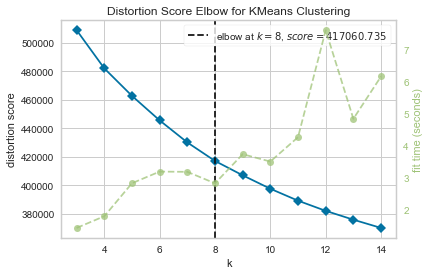

In [19]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [20]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
print(f"Number of clusters {num_clusters}")

Number of clusters 10


In [21]:
print(visualizer.elbow_value_)

8


In [22]:
from sklearn.mixture import GaussianMixture
from clearn.dao.idao import IDao

def decode_latent_vectors(model_type: str,
                          cluster_centers: np.ndarray,
                          exp_config: ExperimentConfig,
                          dao: IDao):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao, exp_config, model_type, num_epochs=0, sess=sess)
        z = np.zeros([cluster_centers.shape[0], exp_config.Z_DIM])
        for i in range(cluster_centers.shape[0]):
            z[i, :] = cluster_centers[i]
        decoded_images = decode(model, z, exp_config.BATCH_SIZE)
        return decoded_images

    
def cluster_and_decode_latent_vectors_gmm(model_type: str,
                                          num_clusters: int,
                                          latent_vectors: np.ndarray,
                                          exp_config: ExperimentConfig,
                                          dao: IDao):
    gm = GaussianMixture(n_components=num_clusters, random_state=0)
    cluster_labels = gm.fit_predict(latent_vectors)
    cluster_centers = gm.means_
    decoded_images = decode_latent_vectors(model_type, cluster_centers, exp_config, dao)

    return decoded_images, cluster_centers, cluster_labels


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
 
ckpt_name SemiSupervisedClassifierMnist.mod

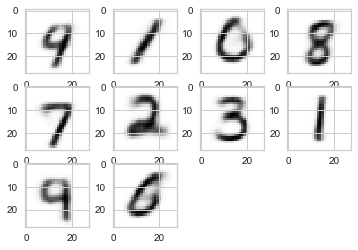

In [23]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [24]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [-1, 1, -1, 8,
                                               7, 2, 3, 1,
                                               -1,-1
                                              ]
    manual_annotation_json["manual_confidence"] = [0, 0.9, 0, 0.8,
                                                   0.8, 0.8, 0.7, 1,
                                                   0, 0
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [25]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [26]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [27]:
cluster_group_dict

{'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fc0e0638e90>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7fc0e0638bd0>,
 None: <clearn.analysis.ClusterGroup at 0x7fc0e05bcf10>}

In [28]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


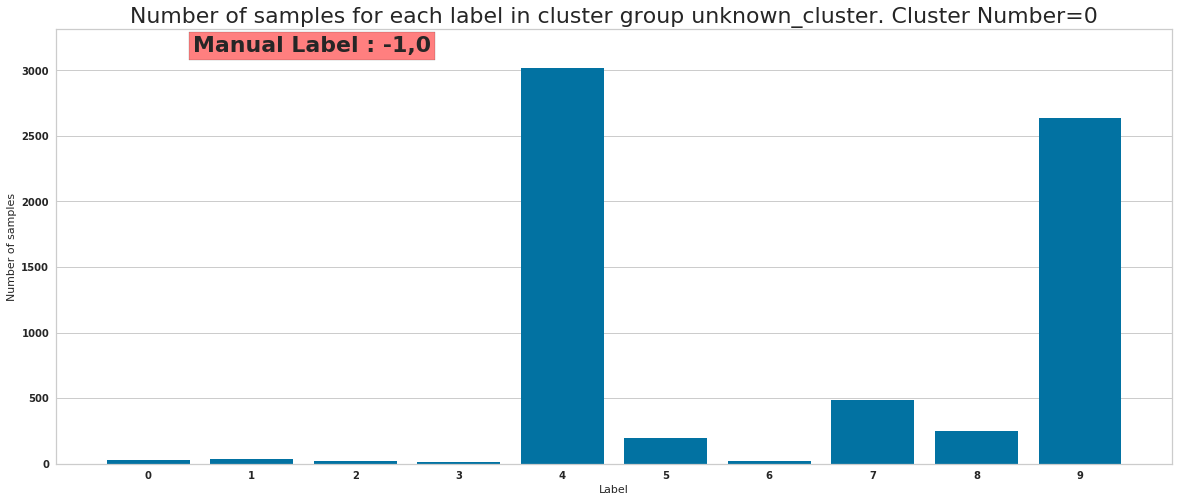

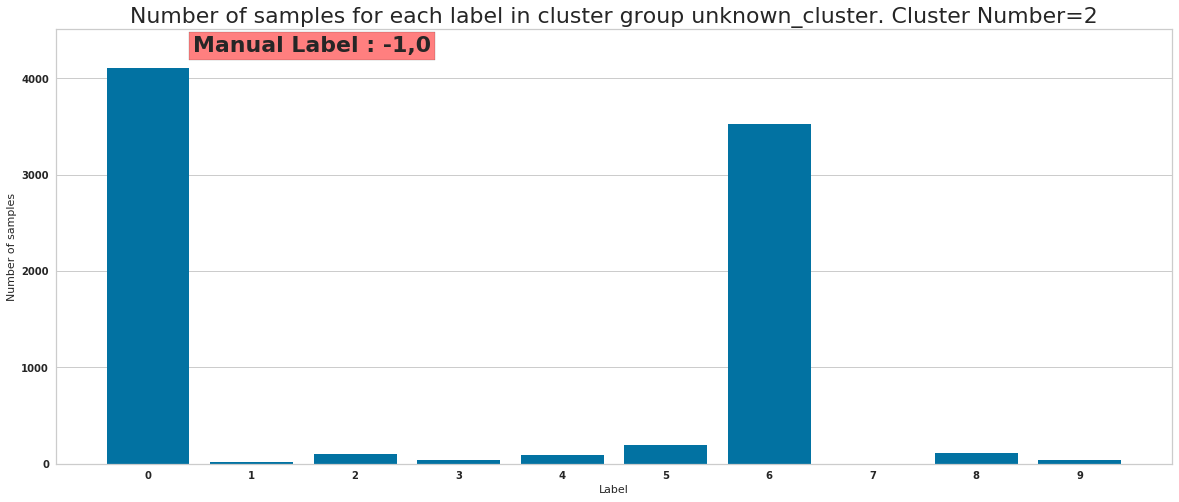

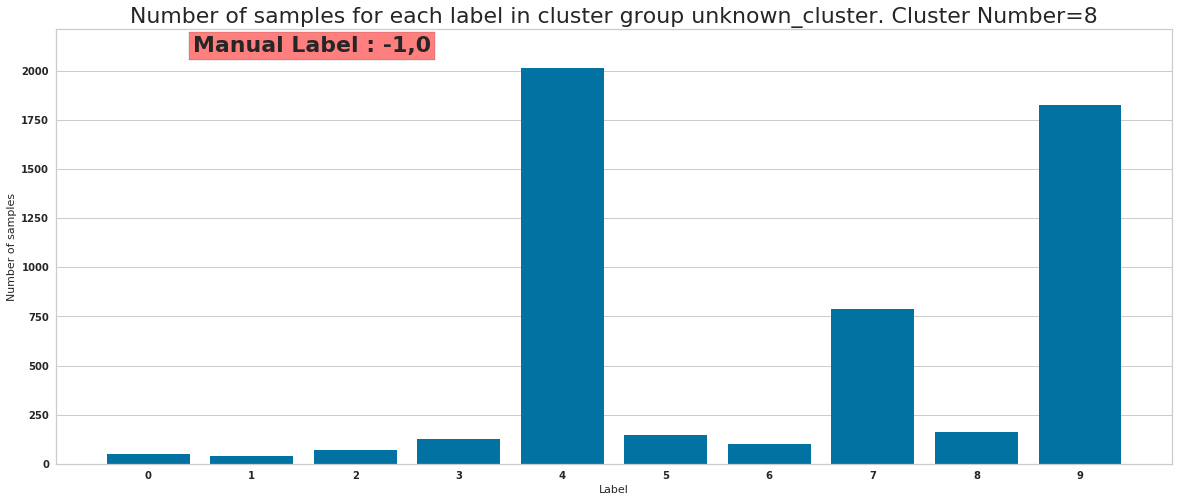

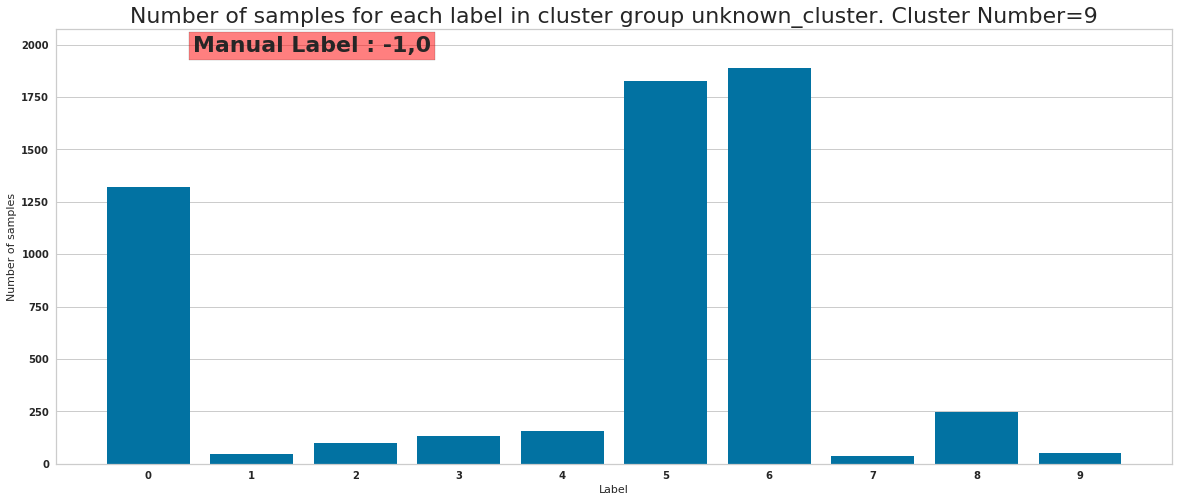

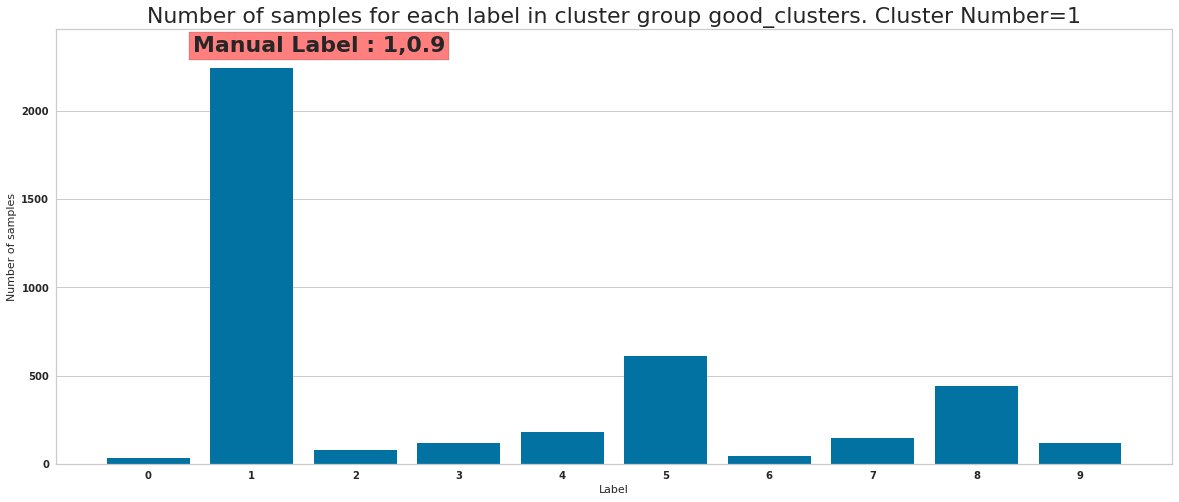

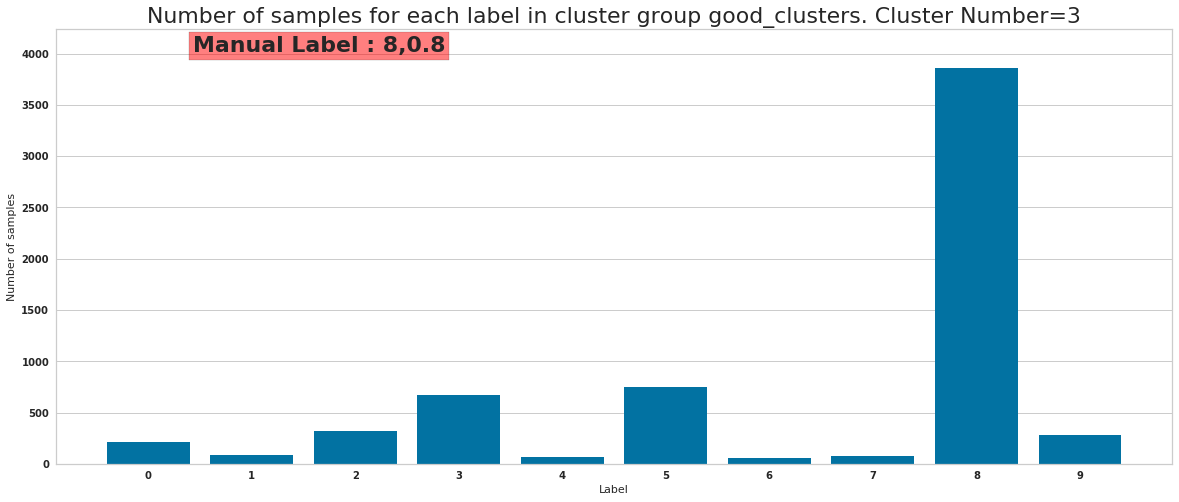

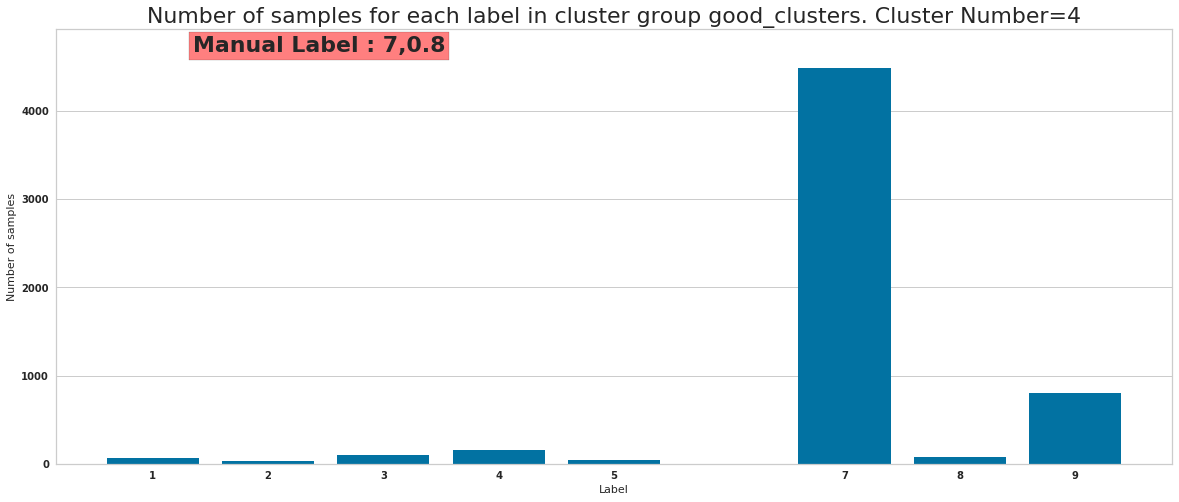

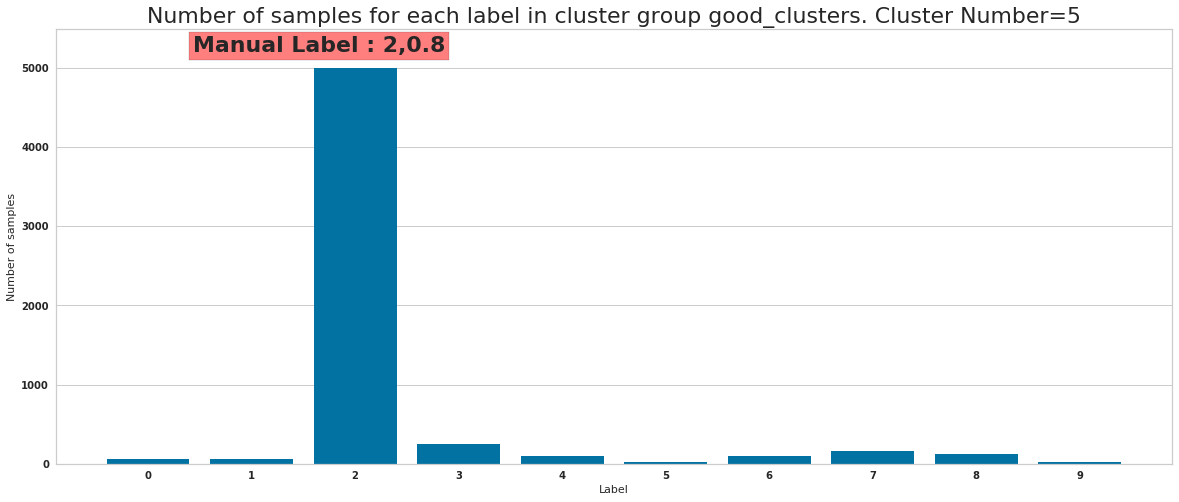

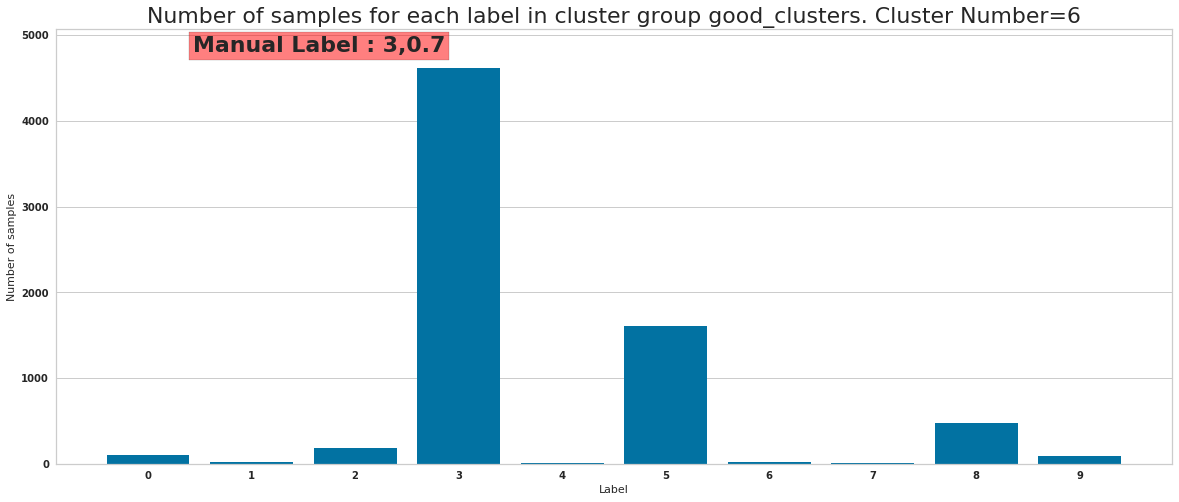

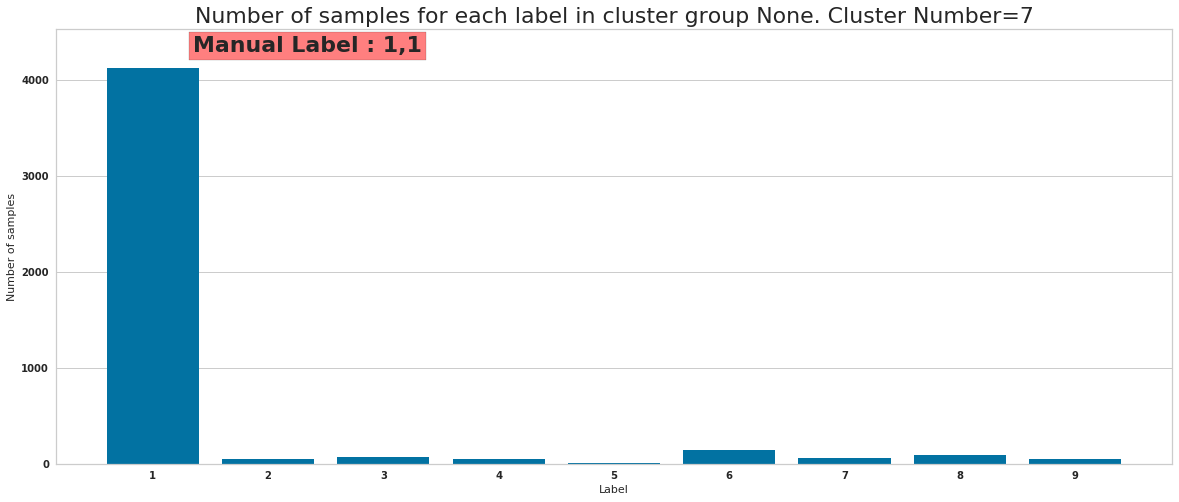

In [29]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [30]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(6720, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4004, 10)
(8211, 10)
(6372, 10)
(5759, 10)
(5878, 10)
(7130, 10)
(4651, 10)
(5315, 10)
(5800, 10)


In [31]:
from pandas import DataFrame
from typing import Dict
def cluster_next_level_gmm(exp_config: ExperimentConfig,
                       df: DataFrame,
                       cluster_column_name_2,
                       cluster_labels,
                       z_col_names,
                       model_type,
                       epochs_completed,
                       dao: IDao,
                       cluster_group_dict: Dict[str, ClusterGroup],
                       processed_clusters=[],
                       cluster_type="unknown_cluster"
                       ):
    if cluster_type in cluster_group_dict.keys():
        for cluster in cluster_group_dict[cluster_type]:
            print(cluster.id)
            if cluster.id in processed_clusters:
                continue
            _indices = np.where(cluster_labels == cluster.id)
            _df = df.iloc[_indices]

            _latent_vectors = _df[z_col_names].values
            tf.reset_default_graph()
            _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors_gmm(
                model_type,
                10,
                _latent_vectors,
                exp_config,
                dao
            )
            df[cluster_column_name_2].iloc[_indices] = _cluster_labels
            image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}_cluster_id_{cluster.id}.png"

            display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

            return cluster, _cluster_centers, _cluster_labels
    return None, None, None


0
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
 
ckpt_name SemiSupervisedClassifierMnist.m

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


2
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
 
ckpt_name SemiSupervisedClassifierMnist.m

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


8
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
 
ckpt_name SemiSupervisedClassifierMnist.m

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


9
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-1871"
 
ckpt_name SemiSupervisedClassifierMnist.m

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


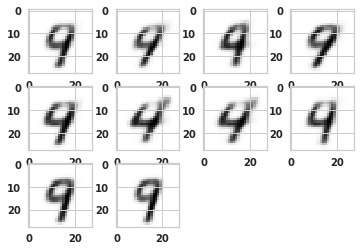

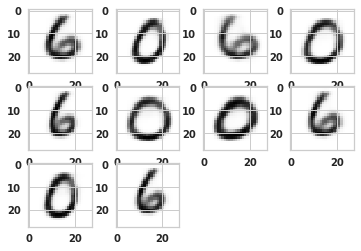

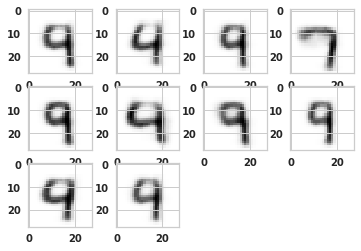

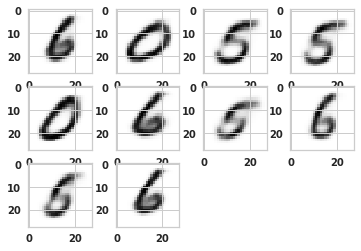

In [32]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [35]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [
                                         -1,-1,-1,-1,
                                         4,4,4,-1,
                                         9, 9
                                        ]
level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0,
                                              0.7, 0.7, 0.7, 0,
                                              0.7, 0.7
                                              ]
level2_manual_annotations[0] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [6,0,6,0,
                                         6,0,0,6,
                                         0, 6
                                        ]

level_2_cluster_dict["manual_confidences"] = [1,1,1,1,
                                              1,1,1,1,
                                              1,1
                                             ]

level2_manual_annotations[2] = level_2_cluster_dict



level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, -1, -1, 7,
                                        9, -1, -1, 9,
                                        -1, -1
                                         ]
level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0.6,
                                              0.8, 0, 0, 0.8,
                                              0, 0
                                             ]
level2_manual_annotations[8] = level_2_cluster_dict



level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [6,0,-1,-1,
                                        0,6,-1,6,
                                        -1,6]

level_2_cluster_dict["manual_confidences"] = [0.8, 0.8, 0, 0,
                                              0.7,0.7,0,0.7,
                                              0,0.7
                                             ]

level2_manual_annotations[9] = level_2_cluster_dict



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1,-1,-1,
#                                         -1,-1,0,-1,
#                                         -1,0]

# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0.9,0,
#                                               0,0.9
#                                              ]

# level2_manual_annotations[7] = level_2_cluster_dict



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [8,8,3,8,
#                                         3,3,8,-1,
#                                         -1,-1]

# level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.7,0.8,
#                                               0.7, 0.7, 0.8, 0,
#                                               0,0
#                                              ]

# level2_manual_annotations[8] = level_2_cluster_dict


In [36]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

0
2
8
9


In [37]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster,cluster_column_name_2)

10
Skipping distance computation for unknown cluster
4 (658,)
5 (754,)
6 (408,)
8 (685,)
9 (799,)
10
0 (745,)
1 (1073,)
2 (754,)
3 (920,)
4 (792,)
5 (864,)
6 (592,)
7 (907,)
8 (994,)
9 (570,)
10
Skipping distance computation for unknown cluster
3 (534,)
4 (556,)
7 (613,)
10
0 (343,)
1 (589,)
4 (624,)
5 (499,)
7 (786,)
9 (738,)
Skipping distance computation for unknown cluster


In [38]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [39]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [40]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [41]:
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

unknown
<class 'dict'>
['unknown_cluster', 'good_clusters']
********-1*******
Annotating individual samples (918,)
********-1*******
Annotating individual samples (424,)
********-1*******
Annotating individual samples (554,)
********-1*******
Annotating individual samples (1049,)
********-1*******
Annotating individual samples (471,)
********4*******
Manual_label 4
********4*******
Manual_label 4
********4*******
Manual_label 4
********9*******
Manual_label 9
********9*******
Manual_label 9
********************************
Manual Label 1
(4026, 87) (4004, 33)
Num correct=2263
Cluster 1 Manual Label 1 Percentage correct 56.20963735717834
********************************
unknown
<class 'dict'>
[None]
********6*******
Manual_label 6
********0*******
Manual_label 0
********6*******
Manual_label 6
********0*******
Manual_label 0
********6*******
Manual_label 6
********0*******
Manual_label 0
********0*******
Manual_label 0
********6*******
Manual_label 6
********0*******
Manual_label 0
****

In [42]:
num_individual_samples_annotated

9249

# Save the dataframe with manual annotations

In [43]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([6720., 4004., 8211., 6372., 5759., 5878., 7130., 4651., 5315.,
        5800.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

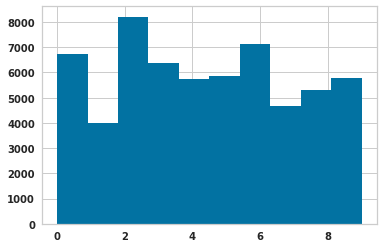

In [44]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [45]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


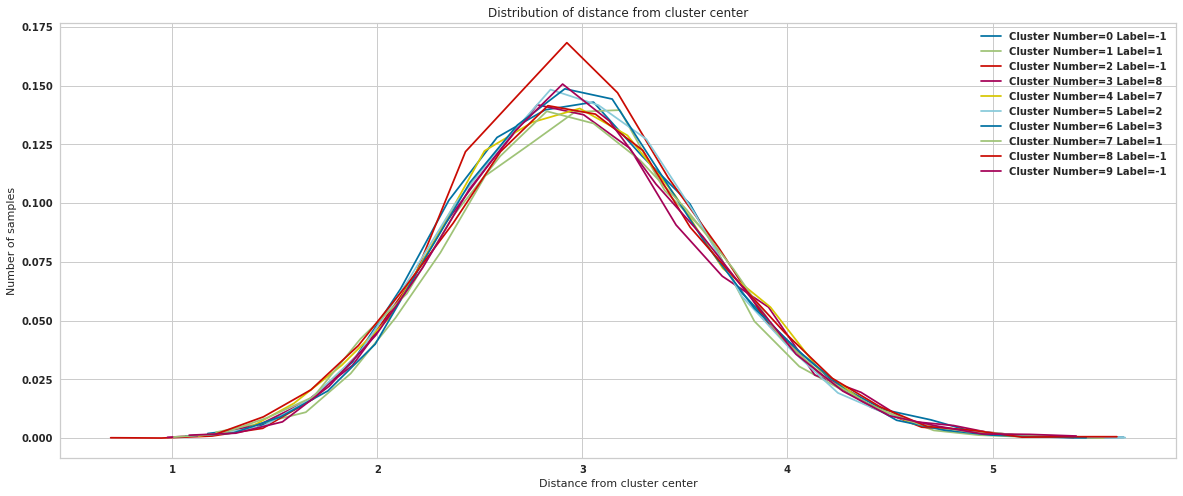

In [46]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

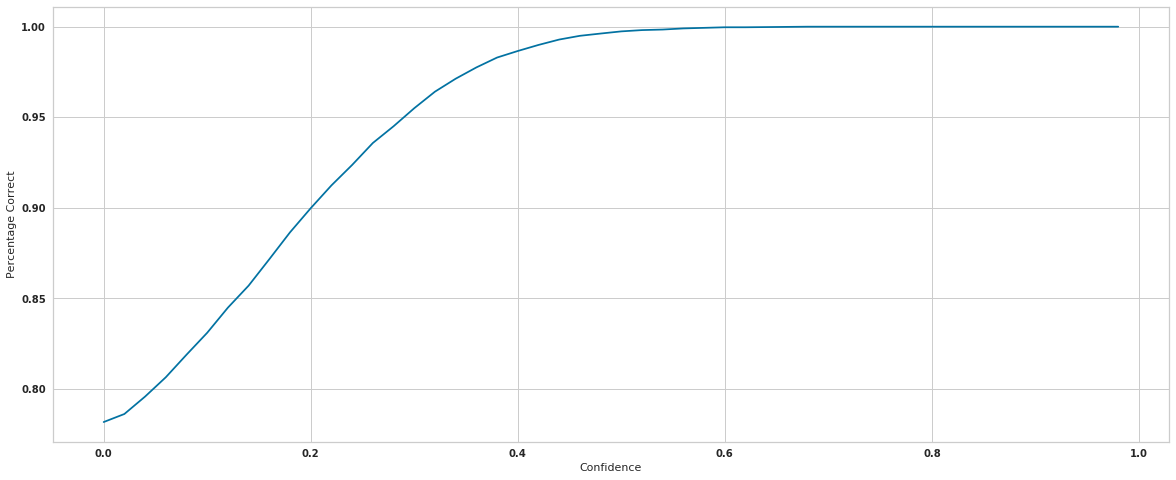

In [47]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

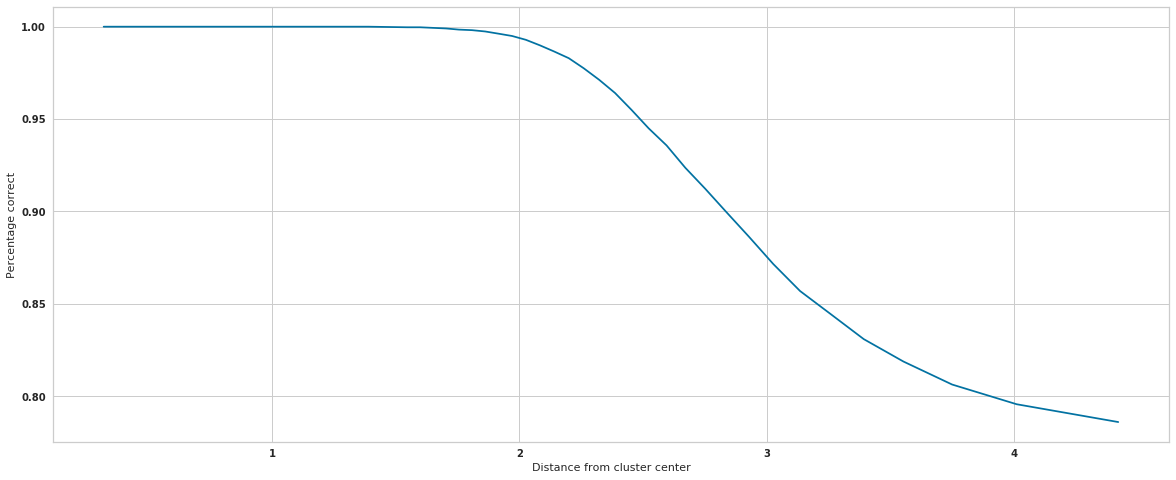

In [48]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [49]:
from shutil import copy2

In [50]:
num_epochs

2

In [51]:
epochs_completed

2.0

In [52]:
# manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
#                                       f"manual_annotation_epoch_{epochs_completed}.csv"
#                                      )
# if os.path.isfile(manual_annotation_file):
#     print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
#     copy2(manual_annotation_file, manual_annotation_file + ".backup")
# else:
#     df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

In [53]:
from typing import List

def get_manual_annotation_col_name(epochs_completed):
    epoch_col_confidence = f"manual_confidence_{int(epochs_completed)}"
    epoch_col_label = f"manual_label_{int(epochs_completed)}"
    return epoch_col_confidence, epoch_col_label

def get_overall_confidence(row, epochs_competed:List[int]):
    if len(epochs_competed) == 1:
        epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_competed[0])
        return row[epoch_col_confidence]
    else:
        confidences = [row[get_manual_annotation_col_name(epoch)[0]] for epoch in epochs_competed]
        if max(confidences) == 1:
            return 1
        else:
            return confidences[-1]


def get_overall_label(row, epochs_competed:List[int]):
    if len(epochs_competed) == 1:
        epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_competed[0])
        return row[epoch_col_label]
    else:
        confidences = [row[get_manual_annotation_col_name(epoch)[0]] for epoch in epochs_competed]
        labels = [row[get_manual_annotation_col_name(epoch)[1]] for epoch in epochs_competed]

        # argmax of confidences
        max_index = max(enumerate(confidences), key=lambda x: x[1])[0]
        if confidences[max_index] == 1:
            return labels[max_index]
        else:
            return labels[-1]


In [54]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

No existing manual annotation file. Creating new manual annotation dataframe
manual_label_0
manual_label_1
manual_label_2


In [55]:
manual_annotation_df.shape

(59840, 4)

In [56]:
manual_annotation_df.head()

manual_label_2  manual_confidence_2  manual_annotation  \
0             4.0             0.316997                4.0   
1             8.0             0.010451                8.0   
2             1.0             0.472231                1.0   
3             2.0             0.142906                2.0   
4             2.0             0.086844                2.0   

   manual_annotation_confidence  
0                      0.316997  
1                      0.010451  
2                      0.472231  
3                      0.142906  
4                      0.086844

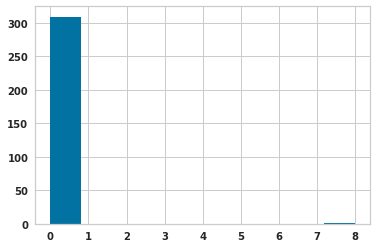

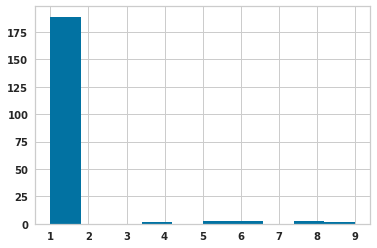

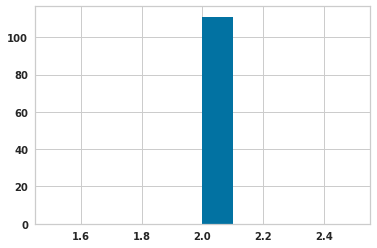

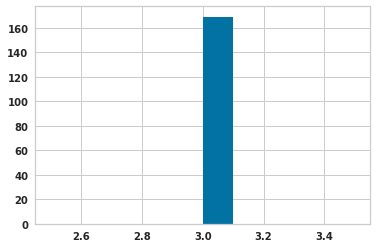

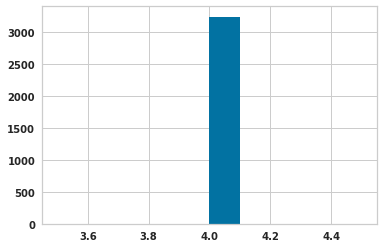

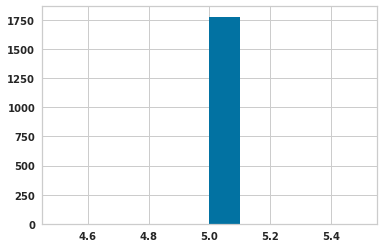

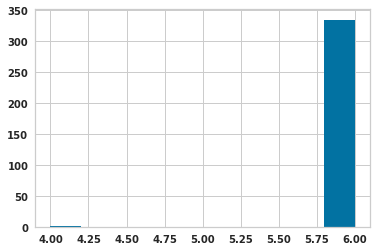

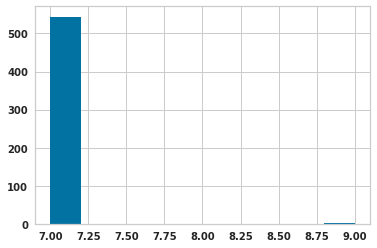

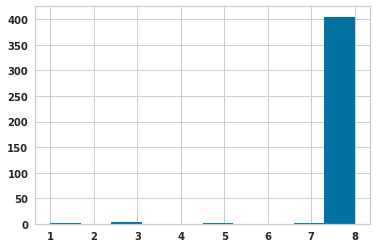

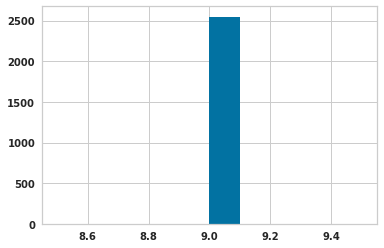

In [57]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 2

In [58]:
num_epochs

2

In [59]:
def get_num_samples_wrongly_annotated():
    df1 = df[df["manual_annotation_confidence"] > 0]
    if df1.shape[0] >  0:
        df2 = df1[df1["manual_annotation"] != df1["label"]]        
        return df2.shape[0]
    else:
        return 0


In [60]:
def get_sum_confidence_wrong():
    df1 = df[df["manual_annotation_confidence"] > 0]
    if df1.shape[0] >  0:
        df2 = df1[df1["manual_annotation"] != df1["label"]]        
        return df2["manual_annotation_confidence"].sum()
    else:
        return 0


# Get the number of samples annotated

In [61]:
epochs_completed

2.0

In [62]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

epoch  train_accuracy  val_accuracy  test_accuracy  \
0      1        0.119636      0.140625       0.123998   
1      2        0.125334      0.109375       0.131310   

   train_reconstruction_loss  val_reconstruction_loss  \
0                 135.270920               135.971893   
1                 127.960449               127.199921   

   test_reconstruction_loss  
0                134.464386  
1                126.894386

In [63]:
num_individual_samples_annotated

9249

In [64]:
num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()

epoch  train_accuracy  val_accuracy  test_accuracy  \
0      1        0.119636      0.140625       0.123998   
1      2        0.125334      0.109375       0.131310   

   train_reconstruction_loss  val_reconstruction_loss  \
0                 135.270920               135.971893   
1                 127.960449               127.199921   

   test_reconstruction_loss  num_individual_samples_annotated  \
0                134.464386                              9249   
1                126.894386                              9249   

   num_samples_wrongly_annotated  total_confidence_of_wrong_annotation  
0                          13068                           1600.579027  
1                          13068                           1600.579027

In [65]:
confidence

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

In [66]:
percentage_correct

array([0.78161765, 0.7860591 , 0.79568617, 0.80635327, 0.81879952,
       0.83092971, 0.84480943, 0.85695963, 0.87156328, 0.88641434,
       0.89974212, 0.91233209, 0.92363169, 0.93575402, 0.944989  ,
       0.95497051, 0.96410729, 0.97126343, 0.97749914, 0.98295811,
       0.98657343, 0.98991742, 0.99289661, 0.99496171, 0.99621057,
       0.99740852, 0.99811735, 0.99841922, 0.99904459, 0.99936034,
       0.99967935, 0.99967818, 0.99978492, 0.99989228, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [67]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

# Start training for one more epoch

In [68]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        learning_rate=5e-4,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0005, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 5, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual

Epoch: 2/60, Nll_loss : 121.47212219238281 KLD:8.24200439453125  Supervised loss:0.5510173439979553
Epoch: 2/61, Nll_loss : 122.75485229492188 KLD:8.482107162475586  Supervised loss:0.2823728621006012
Epoch: 2/62, Nll_loss : 121.47313690185547 KLD:8.754501342773438  Supervised loss:0.4517860412597656
Epoch: 2/63, Nll_loss : 136.99948120117188 KLD:8.917505264282227  Supervised loss:0.4245717525482178
Epoch: 2/64, Nll_loss : 125.74266815185547 KLD:8.576099395751953  Supervised loss:0.3793007731437683
Epoch: 2/65, Nll_loss : 121.9652328491211 KLD:8.794490814208984  Supervised loss:0.44427117705345154
Epoch: 2/66, Nll_loss : 135.35023498535156 KLD:8.656057357788086  Supervised loss:0.4013214707374573
Epoch: 2/67, Nll_loss : 116.11065673828125 KLD:8.304763793945312  Supervised loss:0.37865230441093445
Epoch: 2/68, Nll_loss : 121.96162414550781 KLD:7.94940185546875  Supervised loss:0.32955196499824524
Epoch: 2/69, Nll_loss : 130.4048309326172 KLD:8.432540893554688  Supervised loss:0.40716987

Epoch: 2/143, Nll_loss : 131.27996826171875 KLD:8.944793701171875  Supervised loss:0.34061315655708313
Epoch: 2/144, Nll_loss : 131.17849731445312 KLD:8.515848159790039  Supervised loss:0.36984550952911377
Epoch: 2/145, Nll_loss : 123.44622039794922 KLD:8.613667488098145  Supervised loss:0.32551389932632446
Epoch: 2/146, Nll_loss : 128.9195098876953 KLD:8.426023483276367  Supervised loss:0.25723397731781006
Epoch: 2/147, Nll_loss : 124.30374145507812 KLD:8.714502334594727  Supervised loss:0.3496783375740051
Epoch: 2/148, Nll_loss : 129.79476928710938 KLD:9.050901412963867  Supervised loss:0.333286315202713
Epoch: 2/149, Nll_loss : 135.5887451171875 KLD:8.972097396850586  Supervised loss:0.3717253804206848
Epoch: 2/150, Nll_loss : 124.36215209960938 KLD:8.76466178894043  Supervised loss:0.2662599980831146
Epoch: 2/151, Nll_loss : 130.5347900390625 KLD:9.480712890625  Supervised loss:0.24980203807353973
Epoch: 2/152, Nll_loss : 123.15982055664062 KLD:9.332317352294922  Supervised loss:0.

Epoch: 2/224, Nll_loss : 127.42474365234375 KLD:8.911508560180664  Supervised loss:0.2778100371360779
Epoch: 2/225, Nll_loss : 132.51083374023438 KLD:9.433127403259277  Supervised loss:0.2607764005661011
Epoch: 2/226, Nll_loss : 129.90066528320312 KLD:9.000345230102539  Supervised loss:0.28276506066322327
Epoch: 2/227, Nll_loss : 125.31657409667969 KLD:8.928467750549316  Supervised loss:0.21200592815876007
Epoch: 2/228, Nll_loss : 127.27091979980469 KLD:8.695219039916992  Supervised loss:0.27993184328079224
Epoch: 2/229, Nll_loss : 129.42529296875 KLD:8.958126068115234  Supervised loss:0.2512655258178711
Epoch: 2/230, Nll_loss : 122.92338562011719 KLD:9.579519271850586  Supervised loss:0.3083497881889343
Epoch: 2/231, Nll_loss : 129.19309997558594 KLD:9.000380516052246  Supervised loss:0.20333686470985413
Epoch: 2/232, Nll_loss : 130.84584045410156 KLD:8.927499771118164  Supervised loss:0.3398069441318512
Epoch: 2/233, Nll_loss : 125.5185546875 KLD:8.807205200195312  Supervised loss:0.

Epoch: 2/305, Nll_loss : 126.1716537475586 KLD:8.98984146118164  Supervised loss:0.2909313440322876
Epoch: 2/306, Nll_loss : 120.89007568359375 KLD:8.672492980957031  Supervised loss:0.20404349267482758
Epoch: 2/307, Nll_loss : 129.7631378173828 KLD:9.060906410217285  Supervised loss:0.25368914008140564
Epoch: 2/308, Nll_loss : 122.02436828613281 KLD:8.92972183227539  Supervised loss:0.22170022130012512
Epoch: 2/309, Nll_loss : 131.60415649414062 KLD:8.903630256652832  Supervised loss:0.1844300925731659
Epoch: 2/310, Nll_loss : 122.69601440429688 KLD:8.650100708007812  Supervised loss:0.2129455953836441
Epoch: 2/311, Nll_loss : 132.50839233398438 KLD:8.668874740600586  Supervised loss:0.27802231907844543
Epoch: 2/312, Nll_loss : 135.08279418945312 KLD:8.581023216247559  Supervised loss:0.31136631965637207
Epoch: 2/313, Nll_loss : 129.13601684570312 KLD:9.184285163879395  Supervised loss:0.18375320732593536
Epoch: 2/314, Nll_loss : 130.85687255859375 KLD:8.93194580078125  Supervised los

Epoch: 2/386, Nll_loss : 130.660400390625 KLD:9.025457382202148  Supervised loss:0.15404266119003296
Epoch: 2/387, Nll_loss : 128.3807373046875 KLD:8.750619888305664  Supervised loss:0.26652055978775024
Epoch: 2/388, Nll_loss : 123.57177734375 KLD:8.494668960571289  Supervised loss:0.22736617922782898
Epoch: 2/389, Nll_loss : 126.28410339355469 KLD:8.628945350646973  Supervised loss:0.21997949481010437
Epoch: 2/390, Nll_loss : 125.87452697753906 KLD:8.586013793945312  Supervised loss:0.2151850014925003
Epoch: 2/391, Nll_loss : 126.88424682617188 KLD:9.050674438476562  Supervised loss:0.22346144914627075
Epoch: 2/392, Nll_loss : 119.31575012207031 KLD:8.990273475646973  Supervised loss:0.22056680917739868
Epoch: 2/393, Nll_loss : 121.61131286621094 KLD:9.354280471801758  Supervised loss:0.1619948148727417
Epoch: 2/394, Nll_loss : 128.52291870117188 KLD:9.379472732543945  Supervised loss:0.18093079328536987
Epoch: 2/395, Nll_loss : 125.06869506835938 KLD:9.698498725891113  Supervised los

Epoch: 2/467, Nll_loss : 120.22769165039062 KLD:8.649019241333008  Supervised loss:0.23341089487075806
Epoch: 2/468, Nll_loss : 119.6671142578125 KLD:9.037708282470703  Supervised loss:0.20072025060653687
Epoch: 2/469, Nll_loss : 132.1470947265625 KLD:9.330358505249023  Supervised loss:0.3069339990615845
Epoch: 2/470, Nll_loss : 120.5509033203125 KLD:8.826501846313477  Supervised loss:0.2044573575258255
Epoch: 2/471, Nll_loss : 120.49436950683594 KLD:9.55470085144043  Supervised loss:0.1767665445804596
Epoch: 2/472, Nll_loss : 122.37362670898438 KLD:9.003212928771973  Supervised loss:0.2150876224040985
Epoch: 2/473, Nll_loss : 126.47224426269531 KLD:9.094564437866211  Supervised loss:0.2935548424720764
Epoch: 2/474, Nll_loss : 122.74518585205078 KLD:9.23168659210205  Supervised loss:0.23759184777736664
Epoch: 2/475, Nll_loss : 122.82084655761719 KLD:8.918612480163574  Supervised loss:0.2529279589653015
Epoch: 2/476, Nll_loss : 125.18022155761719 KLD:9.07184886932373  Supervised loss:0.

Epoch: 2/548, Nll_loss : 130.3494415283203 KLD:9.037458419799805  Supervised loss:0.19580858945846558
Epoch: 2/549, Nll_loss : 121.16773986816406 KLD:9.18387222290039  Supervised loss:0.22372987866401672
Epoch: 2/550, Nll_loss : 117.16610717773438 KLD:9.05218505859375  Supervised loss:0.2505766451358795
Epoch: 2/551, Nll_loss : 121.11367797851562 KLD:9.40971851348877  Supervised loss:0.19005323946475983
Epoch: 2/552, Nll_loss : 123.33084869384766 KLD:9.216954231262207  Supervised loss:0.1779668927192688
Epoch: 2/553, Nll_loss : 117.22462463378906 KLD:8.750913619995117  Supervised loss:0.19610843062400818
Epoch: 2/554, Nll_loss : 124.94253540039062 KLD:9.260786056518555  Supervised loss:0.17749536037445068
Epoch: 2/555, Nll_loss : 127.02593994140625 KLD:8.648533821105957  Supervised loss:0.231948584318161
Epoch: 2/556, Nll_loss : 128.29043579101562 KLD:8.981471061706543  Supervised loss:0.16790983080863953
Epoch: 2/557, Nll_loss : 130.44003295898438 KLD:9.05160140991211  Supervised loss

Epoch: 2/629, Nll_loss : 122.24415588378906 KLD:8.739242553710938  Supervised loss:0.20451052486896515
Epoch: 2/630, Nll_loss : 124.8521957397461 KLD:8.601784706115723  Supervised loss:0.20633049309253693
Epoch: 2/631, Nll_loss : 126.2482681274414 KLD:8.89076042175293  Supervised loss:0.1682005524635315
Epoch: 2/632, Nll_loss : 122.2482681274414 KLD:8.706344604492188  Supervised loss:0.20577481389045715
Epoch: 2/633, Nll_loss : 120.35250854492188 KLD:9.118325233459473  Supervised loss:0.1450541615486145
Epoch: 2/634, Nll_loss : 121.54637145996094 KLD:8.885724067687988  Supervised loss:0.18213677406311035
Epoch: 2/635, Nll_loss : 124.79121398925781 KLD:8.978902816772461  Supervised loss:0.19836166501045227
Epoch: 2/636, Nll_loss : 123.18330383300781 KLD:9.716618537902832  Supervised loss:0.20288801193237305
Epoch: 2/637, Nll_loss : 118.53694152832031 KLD:9.387688636779785  Supervised loss:0.16823533177375793
Epoch: 2/638, Nll_loss : 115.84903717041016 KLD:9.44410228729248  Supervised lo

Epoch: 2/710, Nll_loss : 128.01620483398438 KLD:9.349223136901855  Supervised loss:0.2339014708995819
Epoch: 2/711, Nll_loss : 124.12156677246094 KLD:9.216322898864746  Supervised loss:0.17386937141418457
Epoch: 2/712, Nll_loss : 124.66133117675781 KLD:8.821380615234375  Supervised loss:0.2112426459789276
Epoch: 2/713, Nll_loss : 125.23983764648438 KLD:9.410324096679688  Supervised loss:0.2020634412765503
Epoch: 2/714, Nll_loss : 123.79792785644531 KLD:8.935205459594727  Supervised loss:0.21209311485290527
Epoch: 2/715, Nll_loss : 118.07852172851562 KLD:9.677192687988281  Supervised loss:0.18208566308021545
Epoch: 2/716, Nll_loss : 123.07472229003906 KLD:8.601602554321289  Supervised loss:0.22757801413536072
Epoch: 2/717, Nll_loss : 118.38170623779297 KLD:8.883403778076172  Supervised loss:0.17027169466018677
Epoch: 2/718, Nll_loss : 129.54014587402344 KLD:9.235736846923828  Supervised loss:0.21146461367607117
Epoch: 2/719, Nll_loss : 115.10710906982422 KLD:8.835956573486328  Supervise

Epoch: 2/791, Nll_loss : 126.71795654296875 KLD:8.370059967041016  Supervised loss:0.2918115258216858
Epoch: 2/792, Nll_loss : 119.04252624511719 KLD:8.300106048583984  Supervised loss:0.21426358819007874
Epoch: 2/793, Nll_loss : 125.44558715820312 KLD:9.002328872680664  Supervised loss:0.21484969556331635
Epoch: 2/794, Nll_loss : 115.63050842285156 KLD:8.466157913208008  Supervised loss:0.21932537853717804
Epoch: 2/795, Nll_loss : 124.02848815917969 KLD:9.425724029541016  Supervised loss:0.16370466351509094
Epoch: 2/796, Nll_loss : 123.48078918457031 KLD:8.893689155578613  Supervised loss:0.17877238988876343
Epoch: 2/797, Nll_loss : 128.76853942871094 KLD:9.175398826599121  Supervised loss:0.16558155417442322
Epoch: 2/798, Nll_loss : 119.16473388671875 KLD:9.270398139953613  Supervised loss:0.19615623354911804
Epoch: 2/799, Nll_loss : 125.44637298583984 KLD:8.674652099609375  Supervised loss:0.26068687438964844
Epoch: 2/800, Nll_loss : 127.943115234375 KLD:9.305581092834473  Supervise

Epoch: 2/874, Nll_loss : 125.51639556884766 KLD:8.881793022155762  Supervised loss:0.20310759544372559
Epoch: 2/875, Nll_loss : 121.22689819335938 KLD:9.375360488891602  Supervised loss:0.13405567407608032
Epoch: 2/876, Nll_loss : 121.28582763671875 KLD:9.292855262756348  Supervised loss:0.25578320026397705
Epoch: 2/877, Nll_loss : 117.0473861694336 KLD:9.142524719238281  Supervised loss:0.15608930587768555
Epoch: 2/878, Nll_loss : 124.42669677734375 KLD:9.451343536376953  Supervised loss:0.1705169677734375
Epoch: 2/879, Nll_loss : 129.30108642578125 KLD:9.335092544555664  Supervised loss:0.18756841123104095
Epoch: 2/880, Nll_loss : 115.98446655273438 KLD:9.294526100158691  Supervised loss:0.16966119408607483
Epoch: 2/881, Nll_loss : 117.93305969238281 KLD:8.892452239990234  Supervised loss:0.22541731595993042
Epoch: 2/882, Nll_loss : 122.26644134521484 KLD:9.052399635314941  Supervised loss:0.20138654112815857
Epoch: 2/883, Nll_loss : 124.05314636230469 KLD:8.976694107055664  Supervis

In [69]:
num_epochs

3

In [70]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassi

In [71]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=5 z_min=-4.6562347 z_max=4.805038
Latent vectors shape (59840, 10)


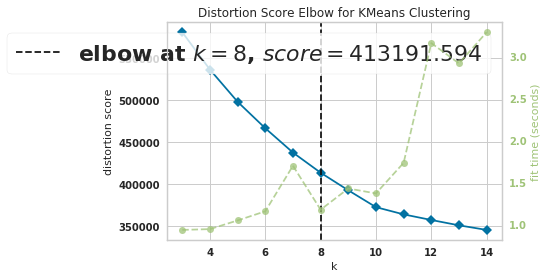

In [72]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [73]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
print(f"Number of clusters {num_clusters}")

Number of clusters 10


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassi

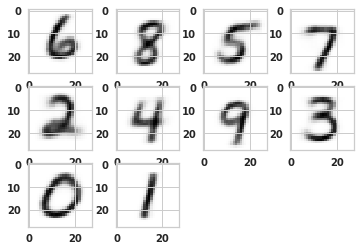

In [74]:
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [75]:
import json
# TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 8, 5, 7,
                                           2, 4, 9, 3,
                                           0, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [76]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [77]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

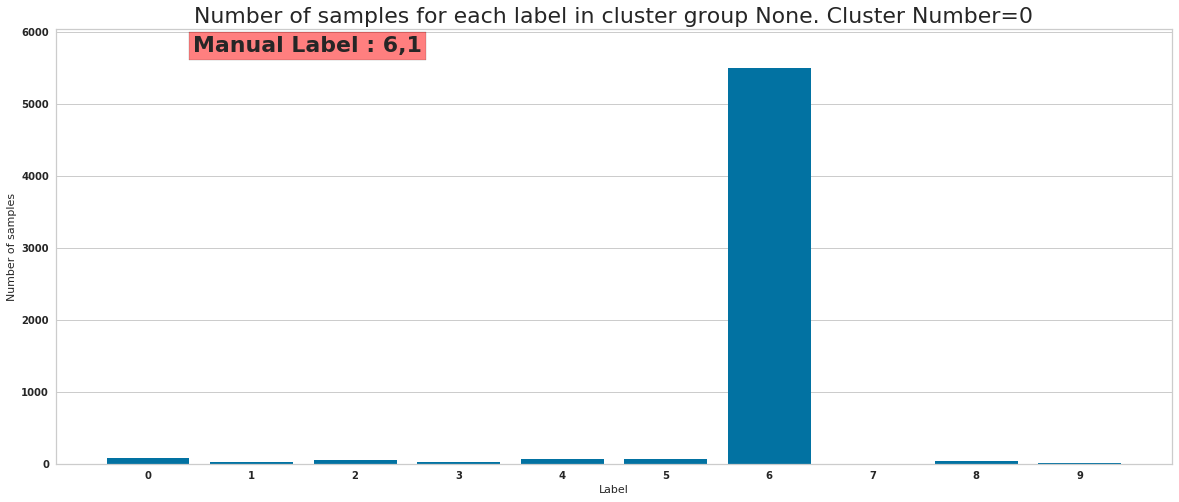

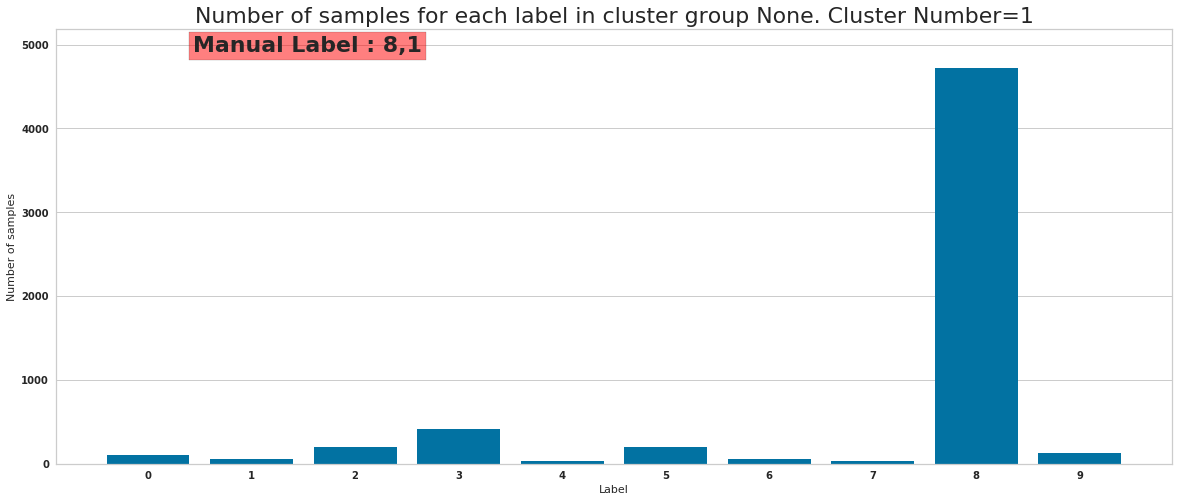

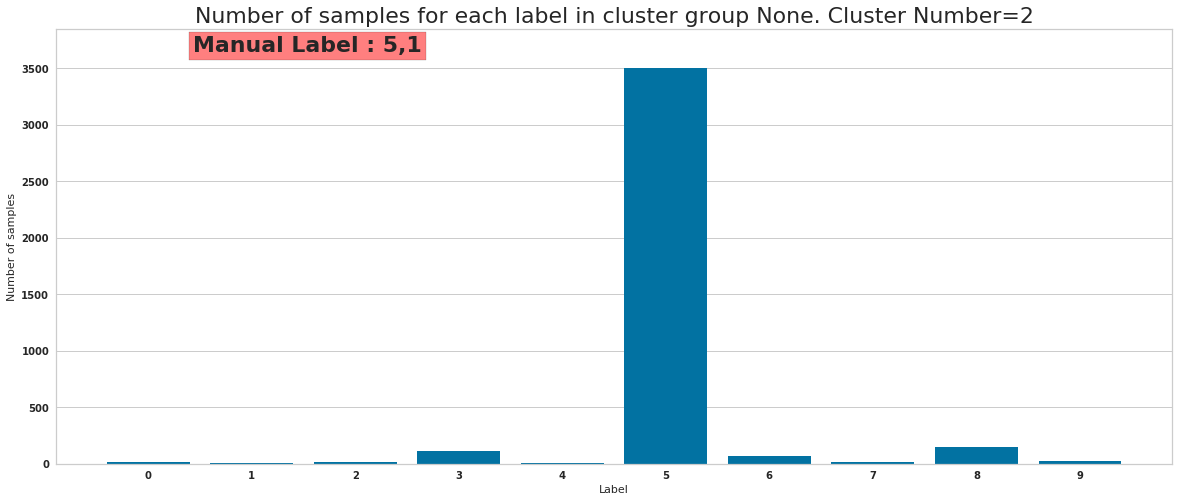

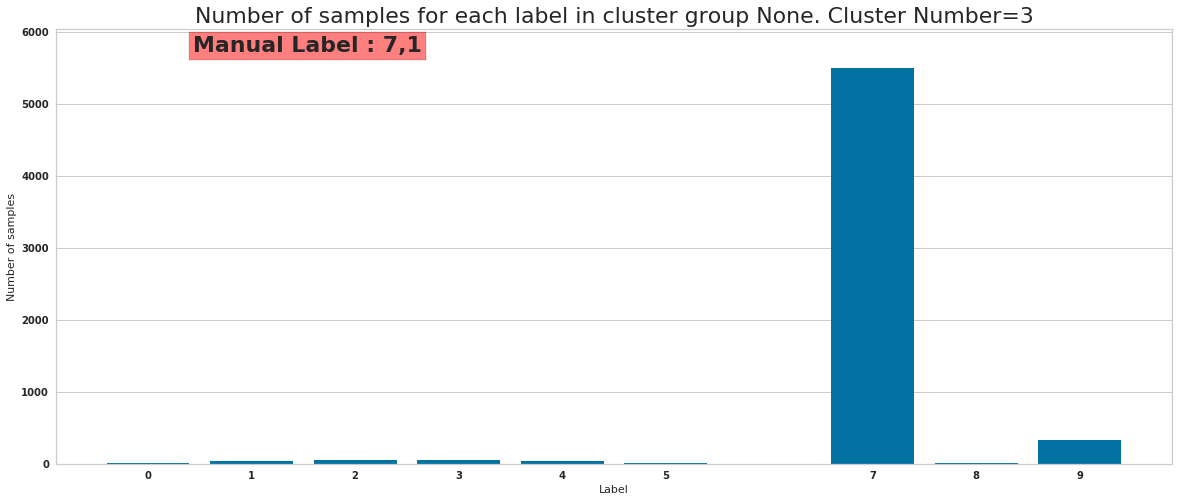

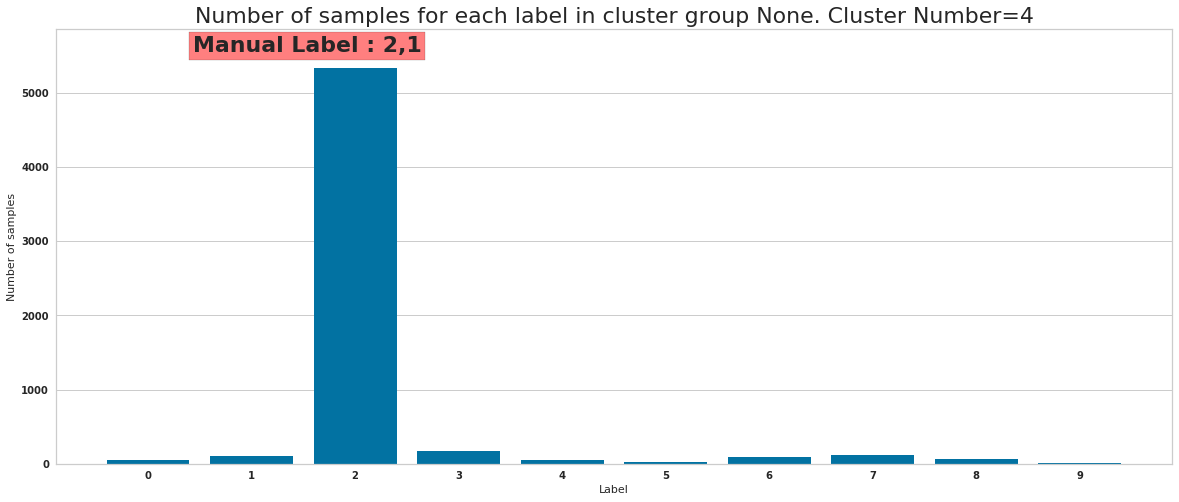

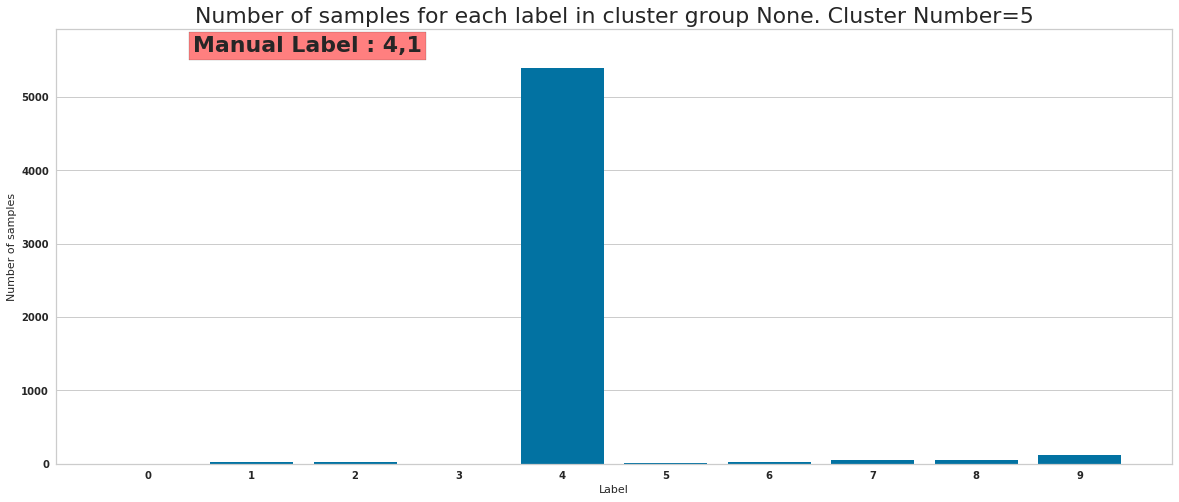

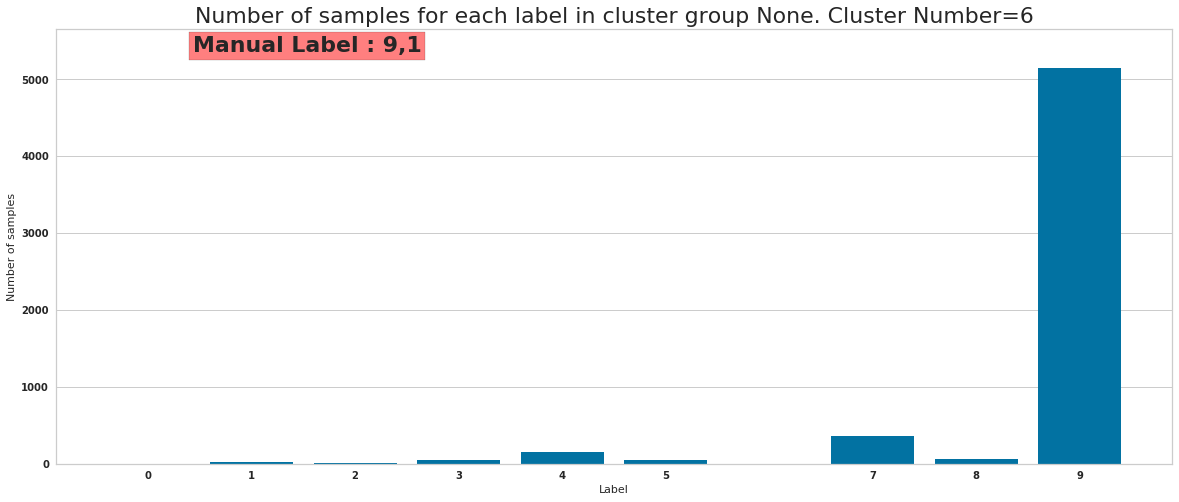

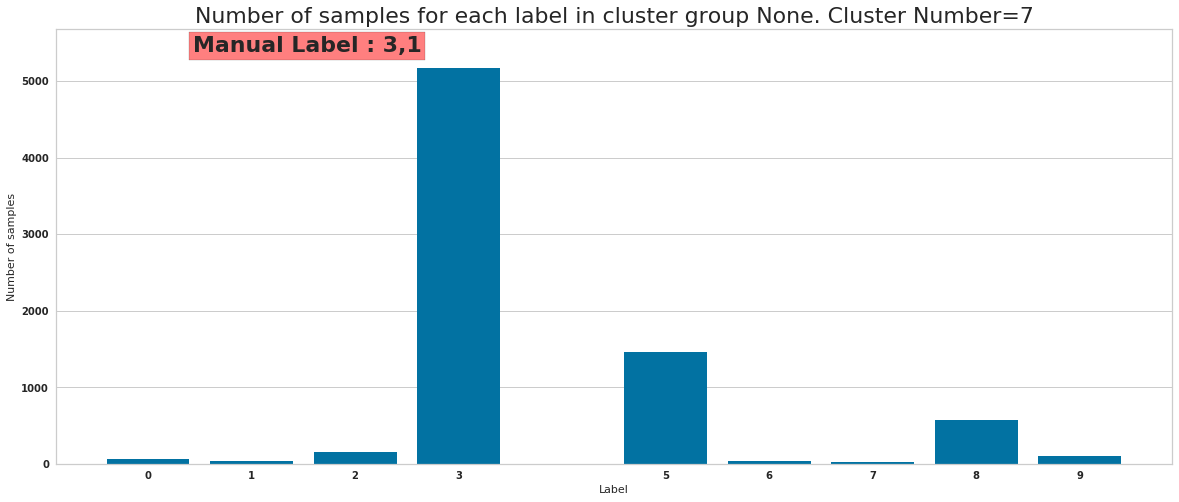

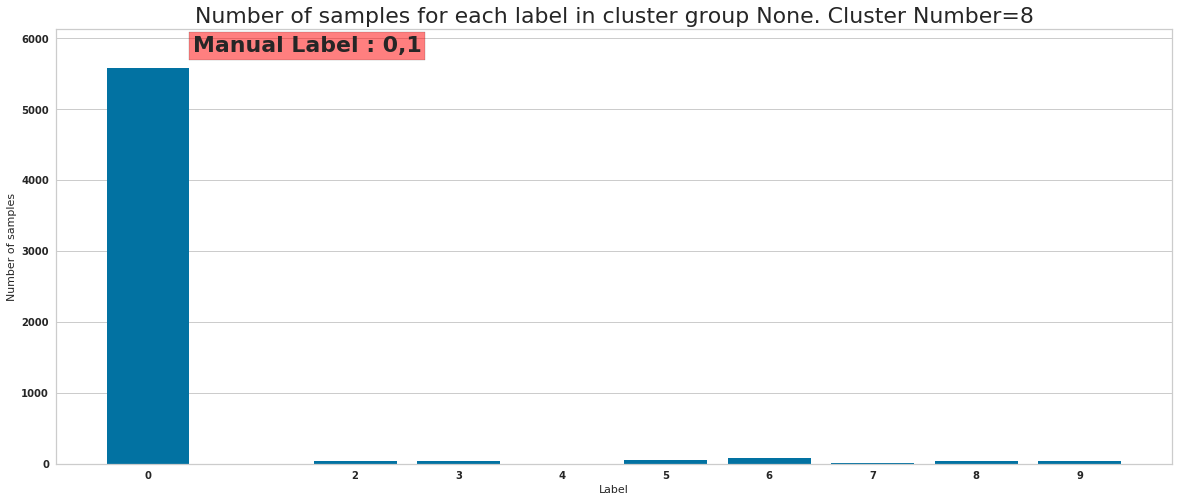

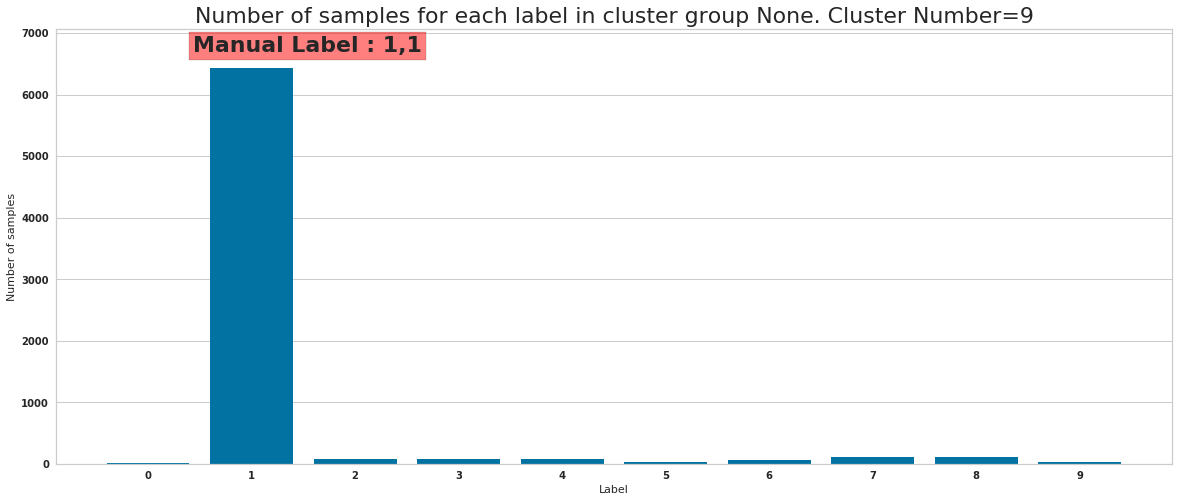

In [78]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [79]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5842, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5958, 10)
(3926, 10)
(6038, 10)
(6020, 10)
(5696, 10)
(5856, 10)
(7603, 10)
(5894, 10)
(7007, 10)


In [80]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [81]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, -1, 0,
#                                         -1, -1, -1, -1,
#                                         5, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0.7,
#                                              0, 0, 0, 0,
#                                              0.7, 0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4, 9, 4, 9,
#                                         9, 4, 9, 4,
#                                         4, -1]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.8,0.8,
#                                              0.8,0.8,0.8,0.8,
#                                              0.8, 0]
# level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [82]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster,cluster_column_name_2)    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5842, 47) (5842, 33)
Num correct=5495
Cluster 0 Manual Label 6 Percentage correct 94.06025333789798
********************************
Manual Label 8
(5958, 47) (5958, 33)
Num correct=4715
Cluster 1 Manual Label 8 Percentage correct 79.13729439409198
********************************
Manual Label 5
(3926, 47) (3926, 33)
Num correct=3498
Cluster 2 Manual Label 5 Percentage correct 89.0983188996434
********************************
Manual Label 7
(6038, 47) (6038, 33)
Num correct=5492
Cluster 3 Manual Label 7 Percentage correct 90.9572706194104
********************************
Manual Label 2
(6020, 47) (6020, 33)
Num correct=5325
Cluster 4 Manual Label 2 Percentage correct 88.45514950166113
********************************
Manual Label 4
(5696, 47) (5696, 33)
Num correct=5389
Cluster 5 Manual Label 4 Percentage correct 94.61025280898876
********************************
Manual Label 9
(5856, 47) (5856, 33)
Num correct=5140
Cluster 6 Manual Label 9 Percentage correct 87.7732240

In [83]:
num_individual_samples_annotated

0

In [84]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5842., 5958., 3926., 6038., 6020., 5696., 5856., 7603., 5894.,
        7007.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

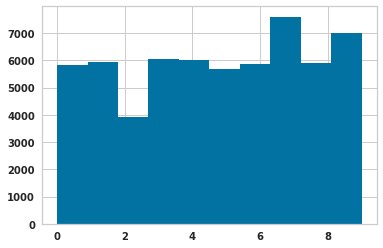

In [85]:
plt.hist(cluster_labels)

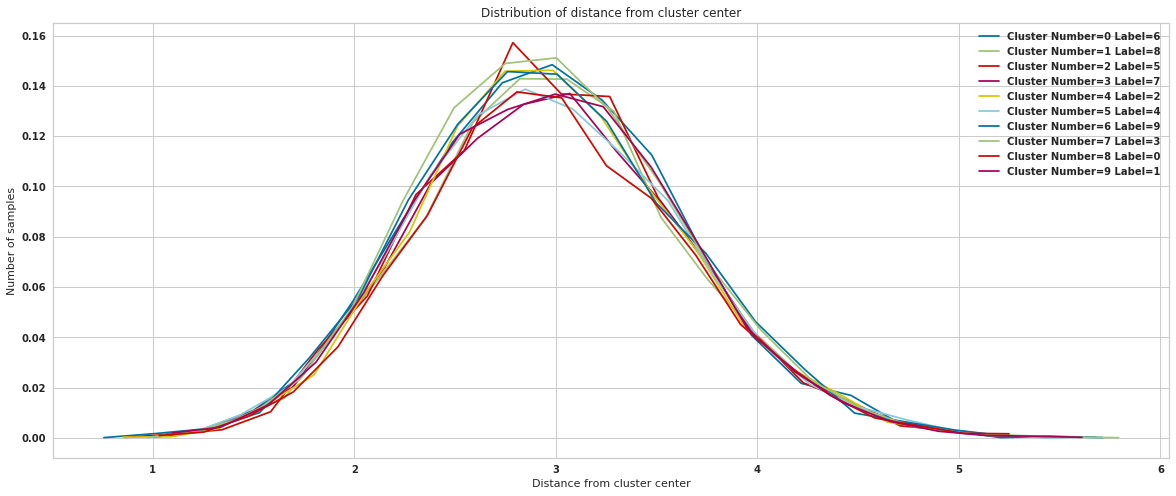

In [86]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

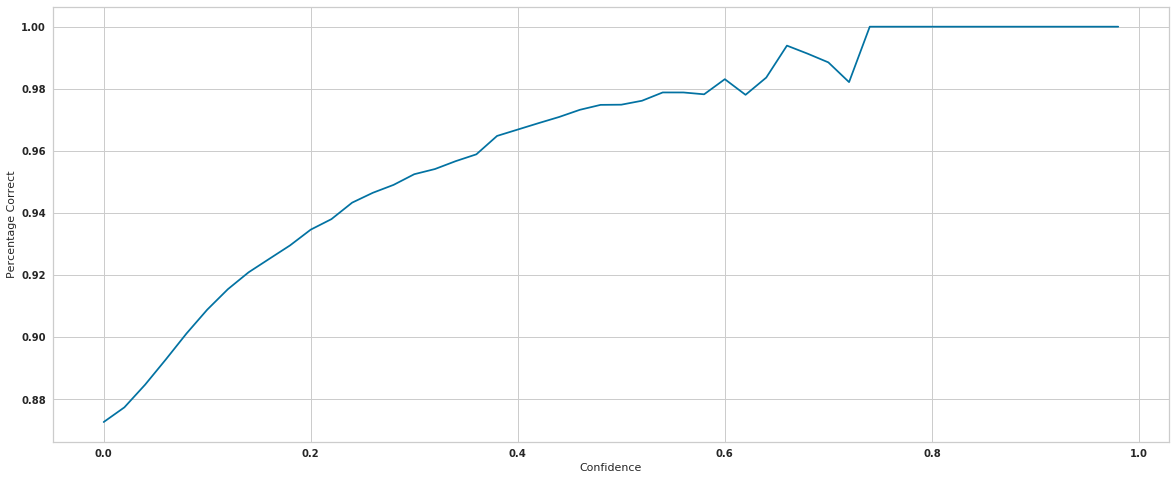

In [87]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

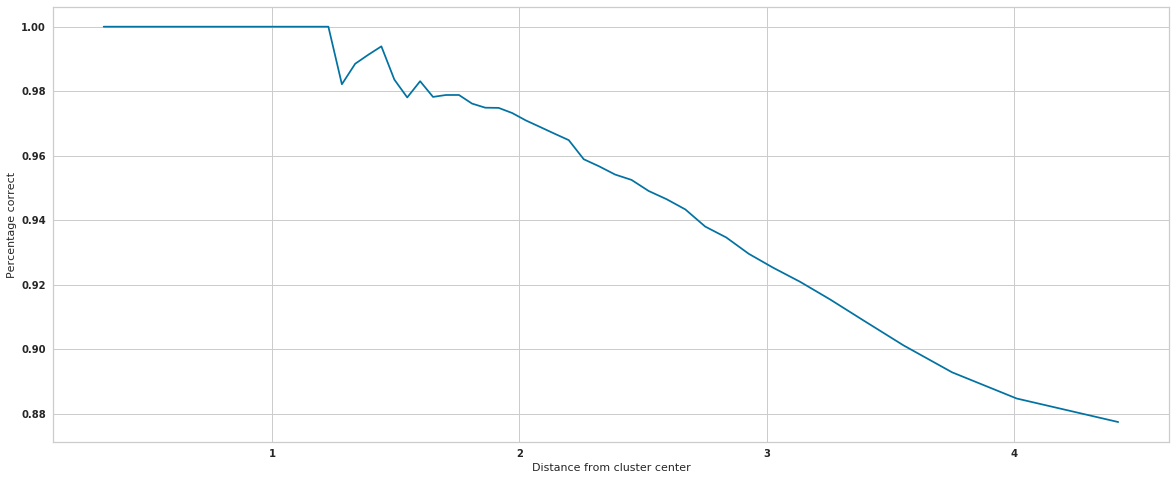

In [88]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [89]:
# manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
#                                       "manual_annotation_epoch_{}.csv".format(epochs_completed )
#                                      )
# if os.path.isfile(manual_annotation_file):
#     # TODO change print to logging x
#     print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
#     copy2(manual_annotation_file, manual_annotation_file + ".backup")
# else:
#     df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

In [90]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3


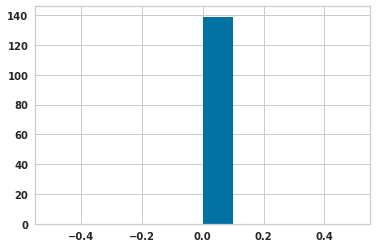

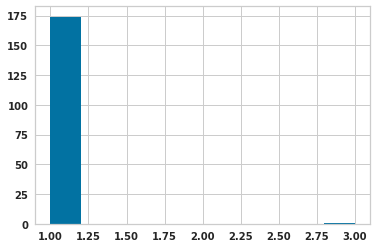

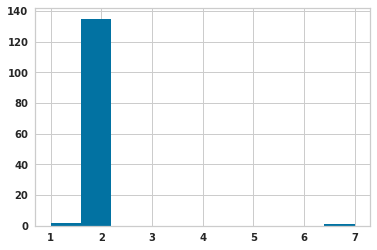

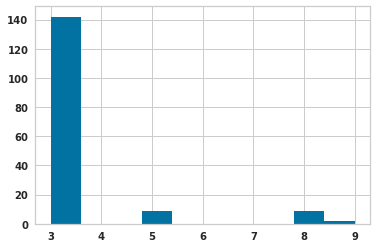

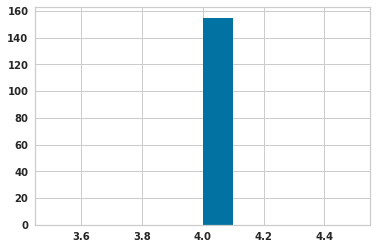

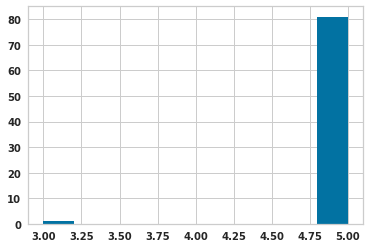

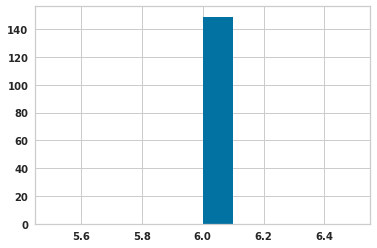

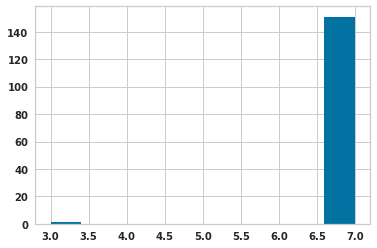

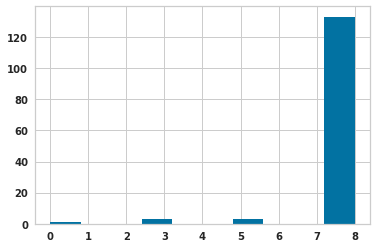

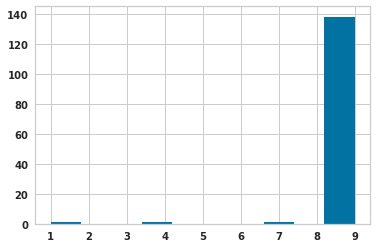

In [91]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [92]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)

In [93]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [94]:
num_epochs
num_epochs += 1
print(num_epochs)

4


In [95]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        learning_rate=1e-4,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 5, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual

Epoch: 3/61, Nll_loss : 115.66104125976562 KLD:9.94012451171875  Supervised loss:0.1865103542804718
Epoch: 3/62, Nll_loss : 133.25051879882812 KLD:10.24254035949707  Supervised loss:0.16276249289512634
Epoch: 3/63, Nll_loss : 121.87413024902344 KLD:9.91495132446289  Supervised loss:0.1429656744003296
Epoch: 3/64, Nll_loss : 114.8703384399414 KLD:9.904563903808594  Supervised loss:0.14258340001106262
Epoch: 3/65, Nll_loss : 125.3503189086914 KLD:10.009560585021973  Supervised loss:0.13829778134822845
Epoch: 3/66, Nll_loss : 109.70873260498047 KLD:9.912290573120117  Supervised loss:0.11477454751729965
Epoch: 3/67, Nll_loss : 113.66119384765625 KLD:9.25986099243164  Supervised loss:0.14457301795482635
Epoch: 3/68, Nll_loss : 120.73542785644531 KLD:10.030792236328125  Supervised loss:0.1418570876121521
Epoch: 3/69, Nll_loss : 123.61912536621094 KLD:9.865341186523438  Supervised loss:0.1695445477962494
Epoch: 3/70, Nll_loss : 115.28754425048828 KLD:9.918904304504395  Supervised loss:0.11771

Epoch: 3/143, Nll_loss : 119.0181884765625 KLD:9.23805046081543  Supervised loss:0.1848561018705368
Epoch: 3/144, Nll_loss : 120.08389282226562 KLD:9.418416976928711  Supervised loss:0.13190600275993347
Epoch: 3/145, Nll_loss : 123.70106506347656 KLD:8.970428466796875  Supervised loss:0.11979832500219345
Epoch: 3/146, Nll_loss : 117.63457489013672 KLD:9.411052703857422  Supervised loss:0.16589030623435974
Epoch: 3/147, Nll_loss : 127.34443664550781 KLD:9.576210021972656  Supervised loss:0.1586768627166748
Epoch: 3/148, Nll_loss : 128.8134765625 KLD:9.488578796386719  Supervised loss:0.17414414882659912
Epoch: 3/149, Nll_loss : 117.7406005859375 KLD:9.358787536621094  Supervised loss:0.14630649983882904
Epoch: 3/150, Nll_loss : 123.2545166015625 KLD:9.935711860656738  Supervised loss:0.11581599712371826
Epoch: 3/151, Nll_loss : 116.38643646240234 KLD:9.682247161865234  Supervised loss:0.09150160849094391
Epoch: 3/152, Nll_loss : 119.76520538330078 KLD:9.230785369873047  Supervised loss:

Epoch: 3/225, Nll_loss : 128.05181884765625 KLD:9.483511924743652  Supervised loss:0.1388234794139862
Epoch: 3/226, Nll_loss : 119.61077880859375 KLD:9.32535171508789  Supervised loss:0.08667543530464172
Epoch: 3/227, Nll_loss : 121.13221740722656 KLD:9.031905174255371  Supervised loss:0.17360764741897583
Epoch: 3/228, Nll_loss : 125.01837158203125 KLD:9.315245628356934  Supervised loss:0.12433014065027237
Epoch: 3/229, Nll_loss : 121.01004791259766 KLD:9.58195686340332  Supervised loss:0.2136186957359314
Epoch: 3/230, Nll_loss : 124.30393981933594 KLD:9.293417930603027  Supervised loss:0.14527803659439087
Epoch: 3/231, Nll_loss : 125.99436950683594 KLD:9.458236694335938  Supervised loss:0.1864975094795227
Epoch: 3/232, Nll_loss : 118.96440887451172 KLD:9.301591873168945  Supervised loss:0.12074911594390869
Epoch: 3/233, Nll_loss : 121.43031311035156 KLD:9.867950439453125  Supervised loss:0.14047914743423462
Epoch: 3/234, Nll_loss : 119.58984375 KLD:9.429229736328125  Supervised loss:0

Epoch: 3/307, Nll_loss : 116.62950134277344 KLD:9.600723266601562  Supervised loss:0.149070143699646
Epoch: 3/308, Nll_loss : 128.7129669189453 KLD:9.777575492858887  Supervised loss:0.14039669930934906
Epoch: 3/309, Nll_loss : 119.2464370727539 KLD:9.52759838104248  Supervised loss:0.1282811462879181
Epoch: 3/310, Nll_loss : 124.58915710449219 KLD:9.57933235168457  Supervised loss:0.134089857339859
Epoch: 3/311, Nll_loss : 129.60964965820312 KLD:9.447967529296875  Supervised loss:0.18131908774375916
Epoch: 3/312, Nll_loss : 123.12174987792969 KLD:9.907583236694336  Supervised loss:0.10487707704305649
Epoch: 3/313, Nll_loss : 123.86153411865234 KLD:9.55648422241211  Supervised loss:0.08527544885873795
Epoch: 3/314, Nll_loss : 117.18452453613281 KLD:9.440963745117188  Supervised loss:0.1197696402668953
Epoch: 3/315, Nll_loss : 118.56855010986328 KLD:9.520048141479492  Supervised loss:0.1173863559961319
Epoch: 3/316, Nll_loss : 119.0782470703125 KLD:9.69659423828125  Supervised loss:0.10

Epoch: 3/388, Nll_loss : 122.7186508178711 KLD:9.23845100402832  Supervised loss:0.13050460815429688
Epoch: 3/389, Nll_loss : 121.82725524902344 KLD:9.186391830444336  Supervised loss:0.11402490735054016
Epoch: 3/390, Nll_loss : 125.13154602050781 KLD:9.335222244262695  Supervised loss:0.09767921268939972
Epoch: 3/391, Nll_loss : 116.72413635253906 KLD:9.142219543457031  Supervised loss:0.16399236023426056
Epoch: 3/392, Nll_loss : 122.69737243652344 KLD:9.296253204345703  Supervised loss:0.11276492476463318
Epoch: 3/393, Nll_loss : 125.74935150146484 KLD:9.340933799743652  Supervised loss:0.1365831196308136
Epoch: 3/394, Nll_loss : 119.37690734863281 KLD:9.621414184570312  Supervised loss:0.1829107105731964
Epoch: 3/395, Nll_loss : 119.72465515136719 KLD:9.049981117248535  Supervised loss:0.1377955675125122
Epoch: 3/396, Nll_loss : 116.48429870605469 KLD:9.687175750732422  Supervised loss:0.15878477692604065
Epoch: 3/397, Nll_loss : 115.31621551513672 KLD:9.054872512817383  Supervised 

Epoch: 3/469, Nll_loss : 120.30899047851562 KLD:9.176315307617188  Supervised loss:0.160100057721138
Epoch: 3/470, Nll_loss : 114.34852600097656 KLD:9.883461952209473  Supervised loss:0.08429860323667526
Epoch: 3/471, Nll_loss : 118.31464385986328 KLD:9.280292510986328  Supervised loss:0.1261604130268097
Epoch: 3/472, Nll_loss : 122.37602233886719 KLD:9.532477378845215  Supervised loss:0.22199587523937225
Epoch: 3/473, Nll_loss : 117.74636840820312 KLD:9.441394805908203  Supervised loss:0.14403025805950165
Epoch: 3/474, Nll_loss : 117.45301818847656 KLD:9.124149322509766  Supervised loss:0.19346150755882263
Epoch: 3/475, Nll_loss : 124.65825653076172 KLD:9.323236465454102  Supervised loss:0.17199257016181946
Epoch: 3/476, Nll_loss : 118.51275634765625 KLD:9.475078582763672  Supervised loss:0.14736180007457733
Epoch: 3/477, Nll_loss : 120.56214141845703 KLD:9.425368309020996  Supervised loss:0.1459408700466156
Epoch: 3/478, Nll_loss : 120.07632446289062 KLD:9.236982345581055  Supervised

Epoch: 3/551, Nll_loss : 123.49833679199219 KLD:9.46075439453125  Supervised loss:0.1251118928194046
Epoch: 3/552, Nll_loss : 113.22004699707031 KLD:9.080530166625977  Supervised loss:0.13886503875255585
Epoch: 3/553, Nll_loss : 119.94175720214844 KLD:9.66598129272461  Supervised loss:0.09534457325935364
Epoch: 3/554, Nll_loss : 123.03314971923828 KLD:8.97244644165039  Supervised loss:0.19247792661190033
Epoch: 3/555, Nll_loss : 125.57747650146484 KLD:9.457744598388672  Supervised loss:0.11857277154922485
Epoch: 3/556, Nll_loss : 127.76541900634766 KLD:9.542081832885742  Supervised loss:0.1251916140317917
Epoch: 3/557, Nll_loss : 118.24187469482422 KLD:9.432950973510742  Supervised loss:0.1726066917181015
Epoch: 3/558, Nll_loss : 119.4468994140625 KLD:9.171669006347656  Supervised loss:0.1021454930305481
Epoch: 3/559, Nll_loss : 120.87458801269531 KLD:9.750036239624023  Supervised loss:0.18329280614852905
Epoch: 3/560, Nll_loss : 116.40687561035156 KLD:9.251311302185059  Supervised los

Epoch: 3/632, Nll_loss : 115.4957046508789 KLD:9.472867965698242  Supervised loss:0.10650268197059631
Epoch: 3/633, Nll_loss : 116.00674438476562 KLD:9.205022811889648  Supervised loss:0.10151208192110062
Epoch: 3/634, Nll_loss : 119.59591674804688 KLD:9.15721321105957  Supervised loss:0.1630972921848297
Epoch: 3/635, Nll_loss : 122.88654327392578 KLD:9.630353927612305  Supervised loss:0.15096035599708557
Epoch: 3/636, Nll_loss : 117.56852722167969 KLD:9.537092208862305  Supervised loss:0.14262568950653076
Epoch: 3/637, Nll_loss : 110.14488220214844 KLD:9.332721710205078  Supervised loss:0.1824435293674469
Epoch: 3/638, Nll_loss : 120.24787902832031 KLD:9.25753402709961  Supervised loss:0.19627413153648376
Epoch: 3/639, Nll_loss : 128.56124877929688 KLD:9.569425582885742  Supervised loss:0.17046672105789185
Epoch: 3/640, Nll_loss : 116.5143051147461 KLD:9.631782531738281  Supervised loss:0.15570148825645447
Epoch: 3/641, Nll_loss : 121.37165832519531 KLD:9.483352661132812  Supervised l

Epoch: 3/713, Nll_loss : 123.29920196533203 KLD:9.13371467590332  Supervised loss:0.14848127961158752
Epoch: 3/714, Nll_loss : 114.66761779785156 KLD:9.899431228637695  Supervised loss:0.11407015472650528
Epoch: 3/715, Nll_loss : 119.50672149658203 KLD:8.995550155639648  Supervised loss:0.18147258460521698
Epoch: 3/716, Nll_loss : 117.88202667236328 KLD:9.302586555480957  Supervised loss:0.12479425221681595
Epoch: 3/717, Nll_loss : 124.92575073242188 KLD:9.643706321716309  Supervised loss:0.18720512092113495
Epoch: 3/718, Nll_loss : 112.38272094726562 KLD:9.125497817993164  Supervised loss:0.12195247411727905
Epoch: 3/719, Nll_loss : 123.89263916015625 KLD:9.135644912719727  Supervised loss:0.20215028524398804
Epoch: 3/720, Nll_loss : 119.18904113769531 KLD:9.260183334350586  Supervised loss:0.14140479266643524
Epoch: 3/721, Nll_loss : 121.19857788085938 KLD:9.240241050720215  Supervised loss:0.2009923905134201
Epoch: 3/722, Nll_loss : 113.39413452148438 KLD:9.333669662475586  Supervis

Epoch: 3/794, Nll_loss : 120.95294189453125 KLD:9.935993194580078  Supervised loss:0.09569567441940308
Epoch: 3/795, Nll_loss : 121.35833740234375 KLD:9.454839706420898  Supervised loss:0.09900493919849396
Epoch: 3/796, Nll_loss : 126.73047637939453 KLD:9.682907104492188  Supervised loss:0.12560293078422546
Epoch: 3/797, Nll_loss : 118.14828491210938 KLD:9.623173713684082  Supervised loss:0.10404103994369507
Epoch: 3/798, Nll_loss : 124.27421569824219 KLD:8.989046096801758  Supervised loss:0.21602068841457367
Epoch: 3/799, Nll_loss : 126.08221435546875 KLD:9.804523468017578  Supervised loss:0.12395083904266357
Epoch: 3/800, Nll_loss : 122.22294616699219 KLD:9.703893661499023  Supervised loss:0.12440746277570724
Epoch: 3/801, Nll_loss : 114.53466796875 KLD:9.565112113952637  Supervised loss:0.10803192853927612
Epoch: 3/802, Nll_loss : 114.7518310546875 KLD:9.696921348571777  Supervised loss:0.09278710931539536
Epoch: 3/803, Nll_loss : 117.15172576904297 KLD:9.193241119384766  Supervised

Epoch: 3/876, Nll_loss : 114.18492126464844 KLD:9.637569427490234  Supervised loss:0.11705335974693298
Epoch: 3/877, Nll_loss : 120.23046875 KLD:9.984197616577148  Supervised loss:0.14126676321029663
Epoch: 3/878, Nll_loss : 127.29487609863281 KLD:9.897031784057617  Supervised loss:0.11813153326511383
Epoch: 3/879, Nll_loss : 110.1822509765625 KLD:9.875126838684082  Supervised loss:0.09512759000062943
Epoch: 3/880, Nll_loss : 113.87904357910156 KLD:9.46355152130127  Supervised loss:0.16594356298446655
Epoch: 3/881, Nll_loss : 119.26201629638672 KLD:9.64488697052002  Supervised loss:0.2044735550880432
Epoch: 3/882, Nll_loss : 120.16581726074219 KLD:9.542140007019043  Supervised loss:0.1978796124458313
Epoch: 3/883, Nll_loss : 108.87413024902344 KLD:9.61970329284668  Supervised loss:0.16143718361854553
Epoch: 3/884, Nll_loss : 121.70989227294922 KLD:9.792473793029785  Supervised loss:0.11247912794351578
Epoch: 3/885, Nll_loss : 113.12202453613281 KLD:9.404431343078613  Supervised loss:0.

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassi

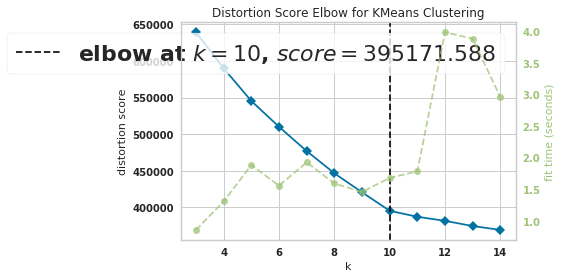

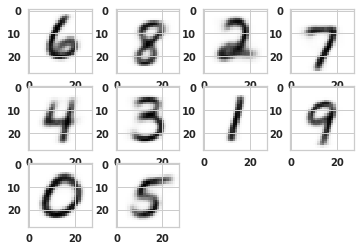

In [96]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
print(f"Number of clusters {num_clusters}")

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [98]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 8, 2, 7,
                                           4, 3, 1, 9,
                                           0, 5
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


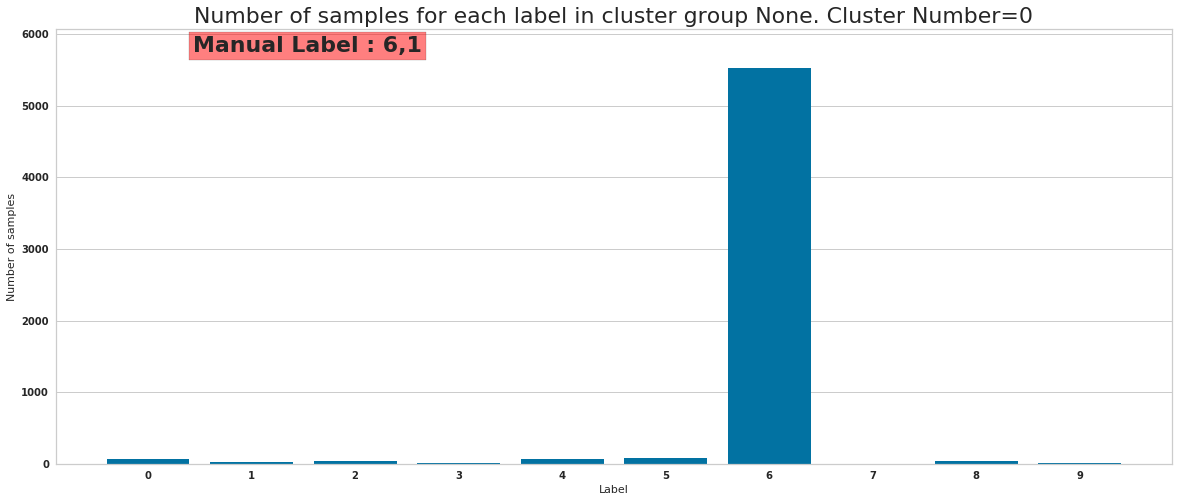

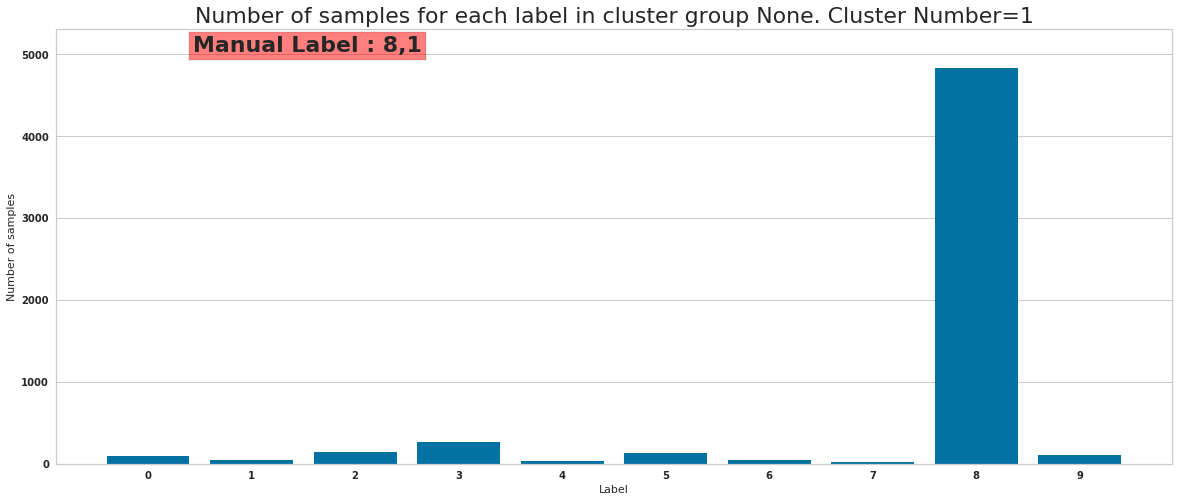

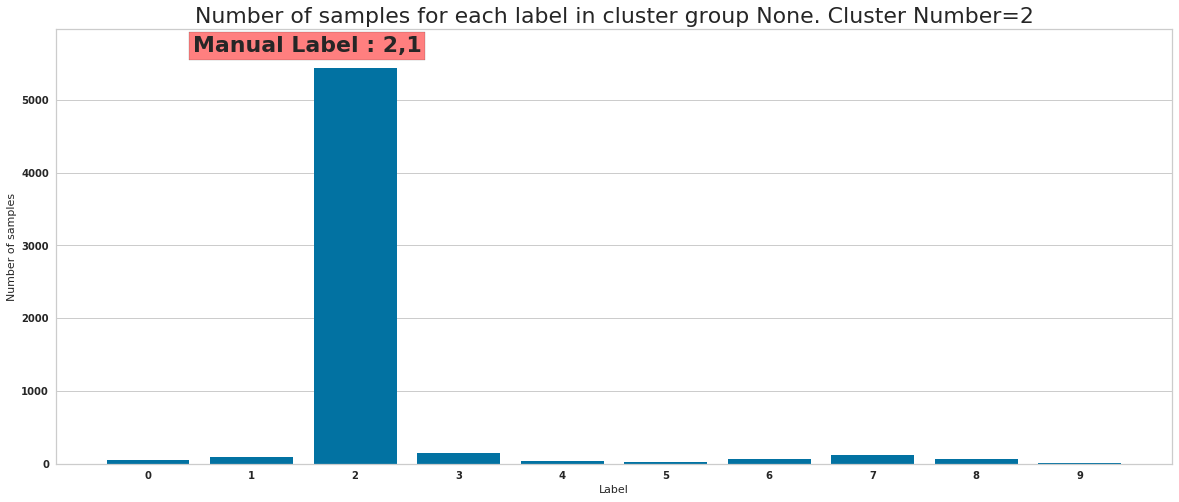

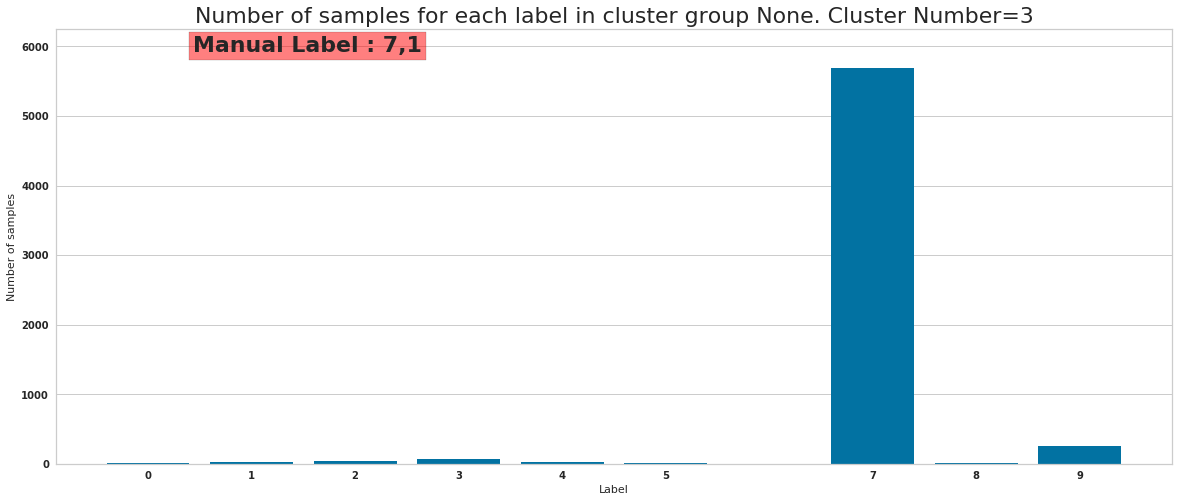

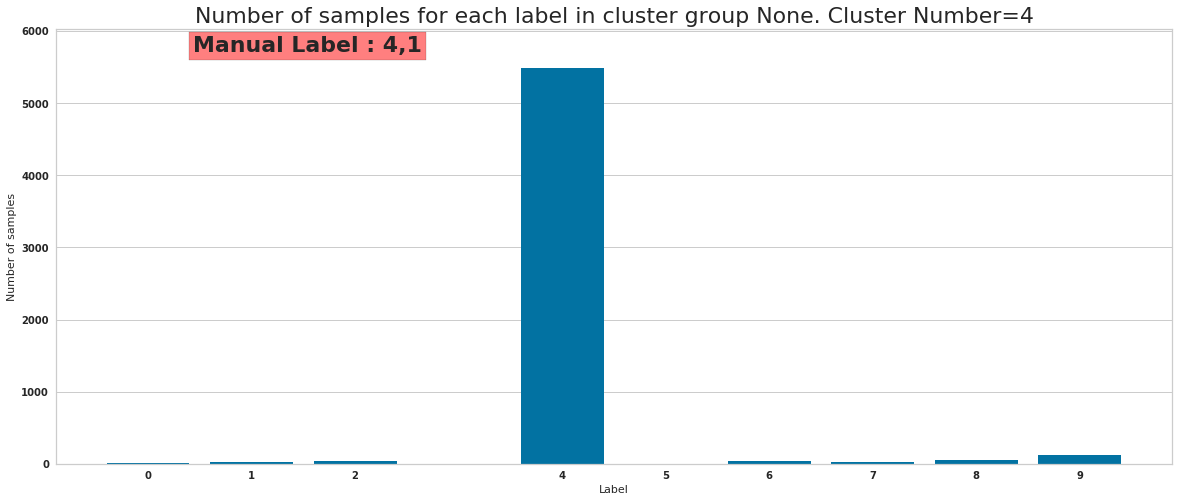

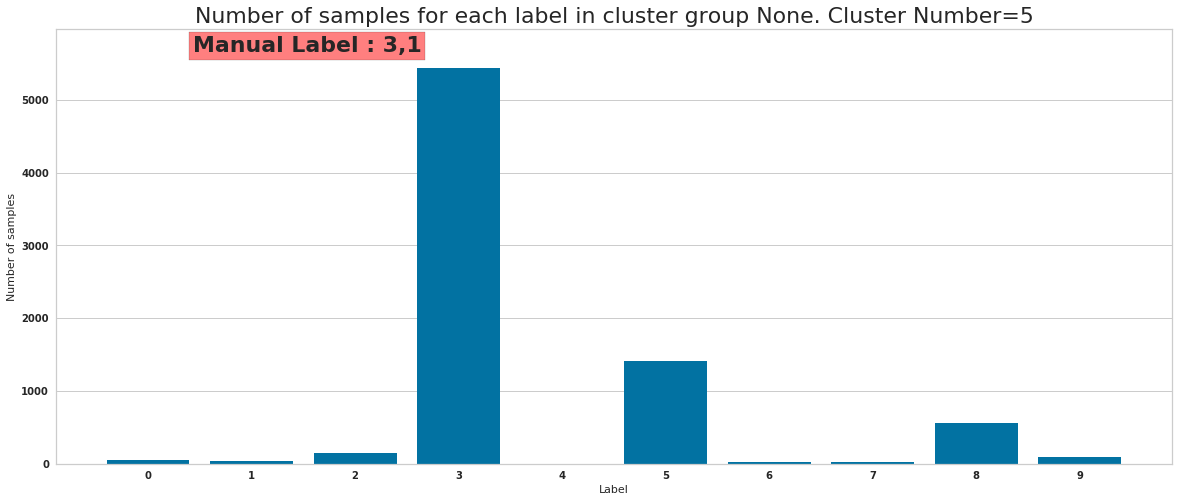

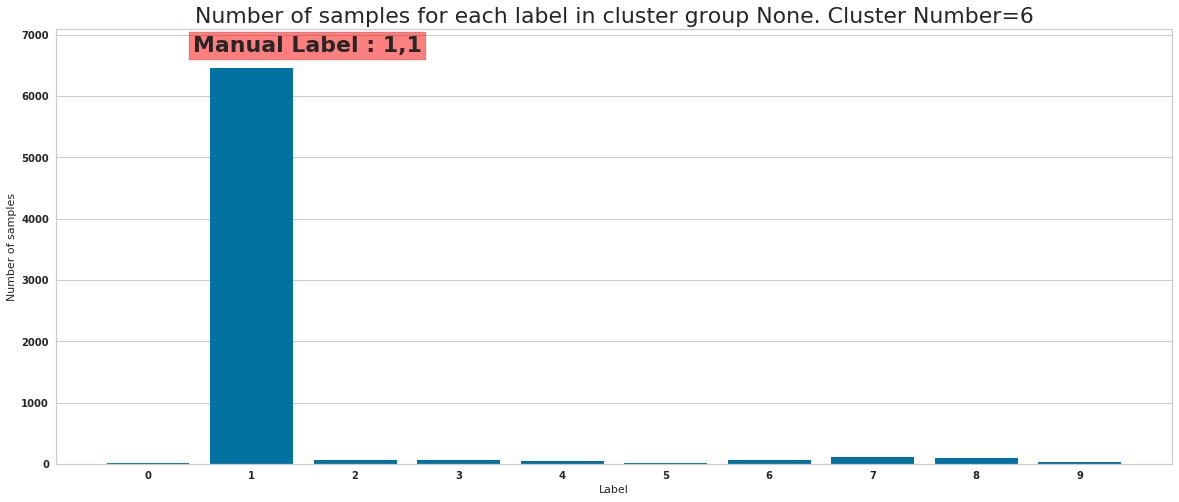

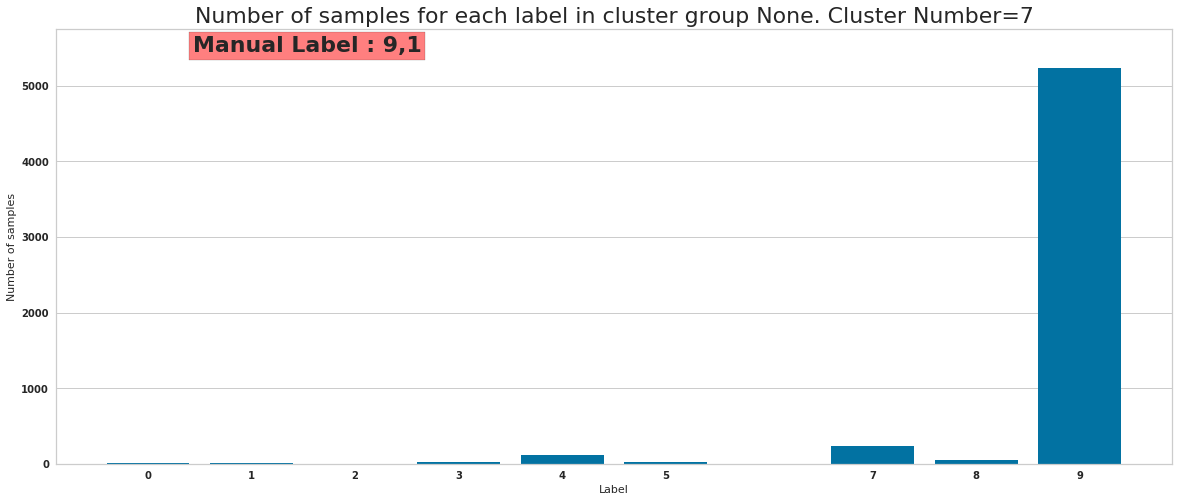

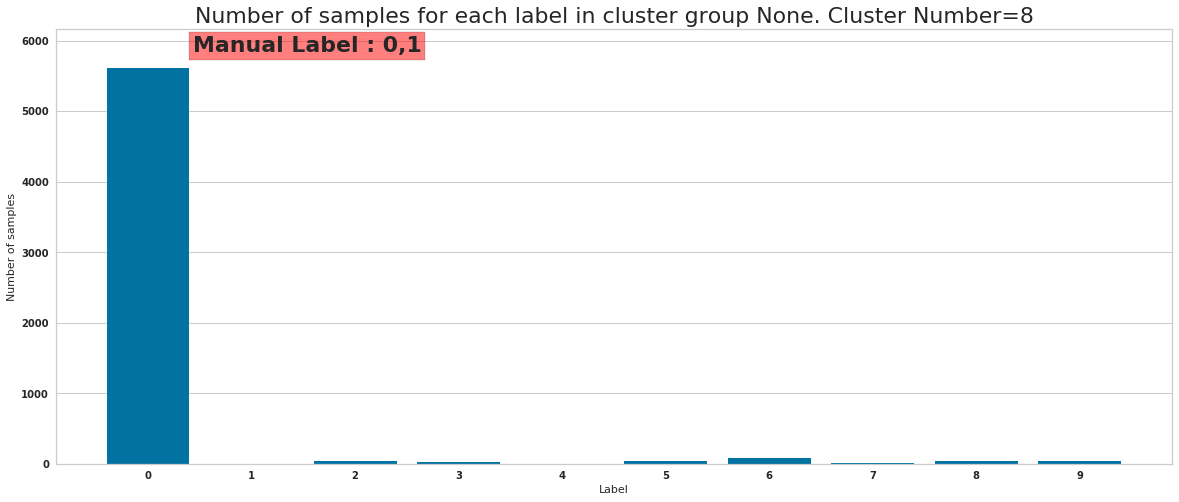

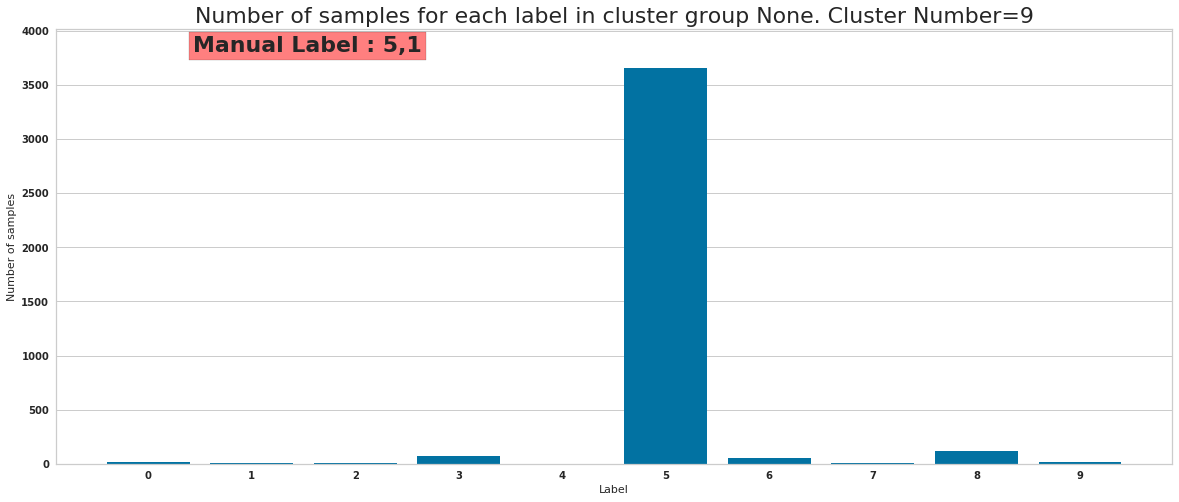

In [99]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [100]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5862, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5738, 10)
(6041, 10)
(6126, 10)
(5787, 10)
(7787, 10)
(6935, 10)
(5710, 10)
(5898, 10)
(3956, 10)


In [101]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5, 3, 3, 3,
#                                          5, -1, 3, 5,
#                                          5,3
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.9,0.9,0.9,0.9,
#                                              0.9,0.9,0.9,0.9,
#                                              0.9,0.9]
# level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [102]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster,cluster_column_name_2)    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5862, 47) (5862, 33)
Num correct=5518
Cluster 0 Manual Label 6 Percentage correct 94.13169566700785
********************************
Manual Label 8
(5738, 47) (5738, 33)
Num correct=4829
Cluster 1 Manual Label 8 Percentage correct 84.15824329034507
********************************
Manual Label 2
(6041, 47) (6041, 33)
Num correct=5429
Cluster 2 Manual Label 2 Percentage correct 89.8692269491806
********************************
Manual Label 7
(6126, 47) (6126, 33)
Num correct=5683
Cluster 3 Manual Label 7 Percentage correct 92.76852758733268
********************************
Manual Label 4
(5787, 47) (5787, 33)
Num correct=5483
Cluster 4 Manual Label 4 Percentage correct 94.74684637981683
********************************
Manual Label 3
(7787, 47) (7787, 33)
Num correct=5429
Cluster 5 Manual Label 3 Percentage correct 69.71876203929627
********************************
Manual Label 1
(6935, 47) (6935, 33)
Num correct=6452
Cluster 6 Manual Label 1 Percentage correct 93.035328

In [103]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [104]:
# manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
#                                       "manual_annotation_epoch_{}.csv".format(epochs_completed )
#                                      )
# if os.path.isfile(manual_annotation_file):
#     # TODO change print to logging x
#     print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
#     copy2(manual_annotation_file, manual_annotation_file + ".backup")
# else:
#     df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

In [105]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4


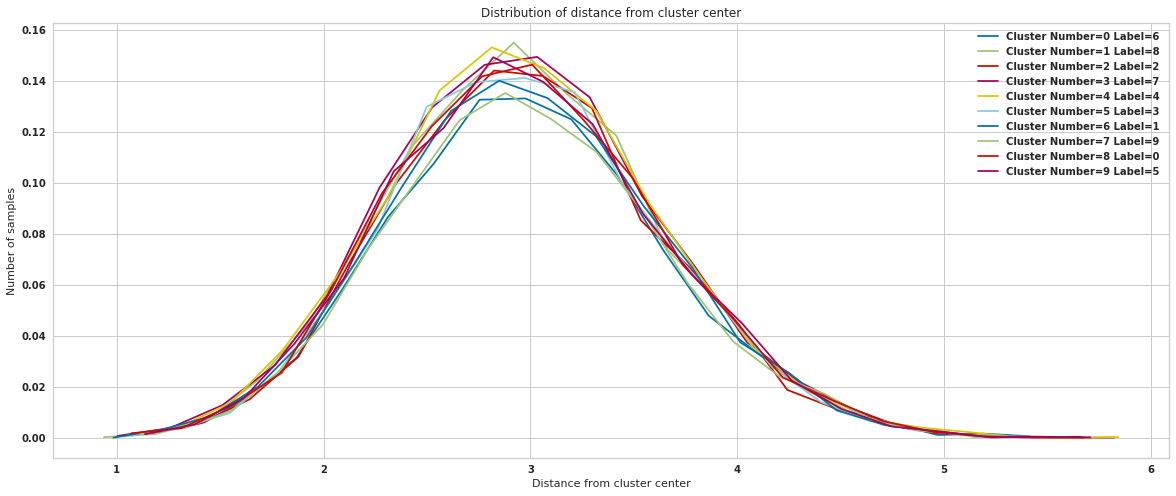

In [111]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

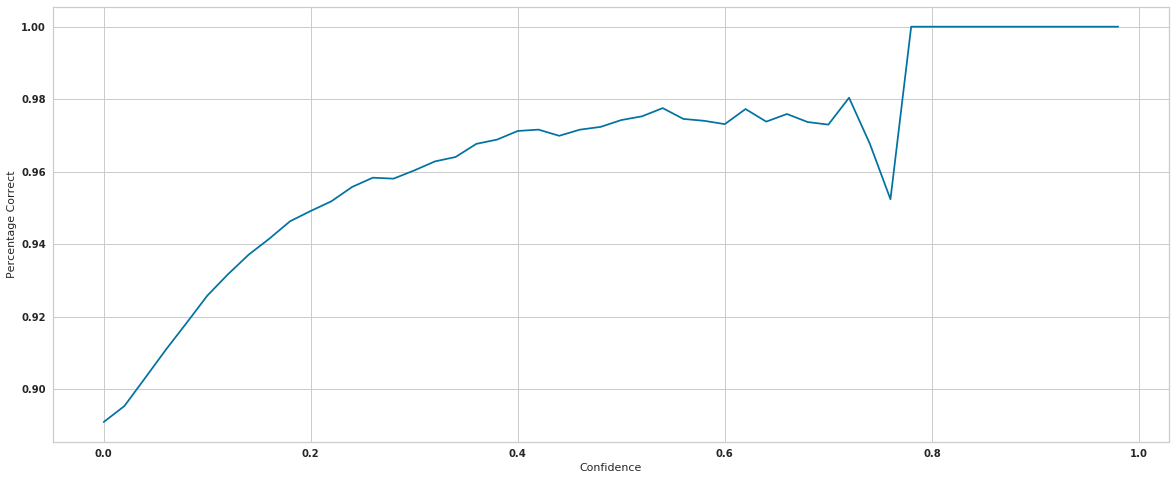

In [112]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

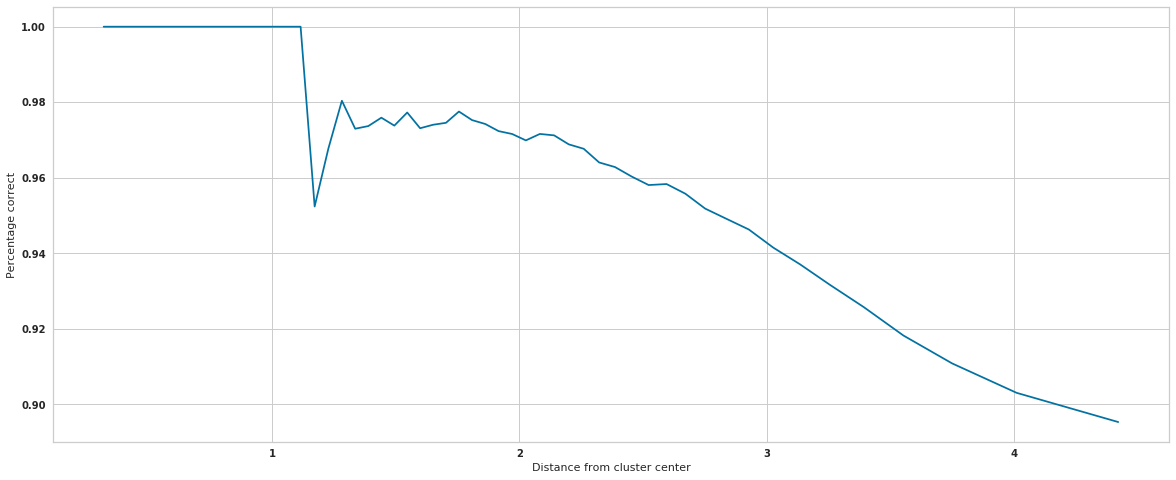

In [113]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

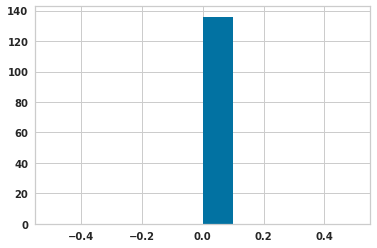

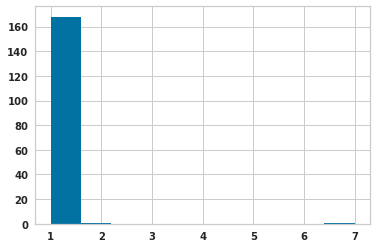

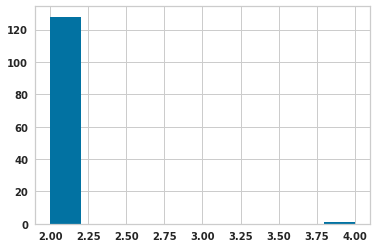

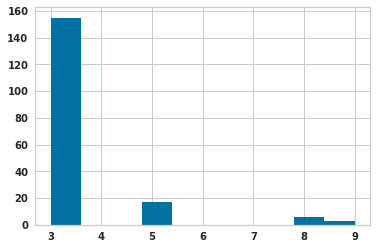

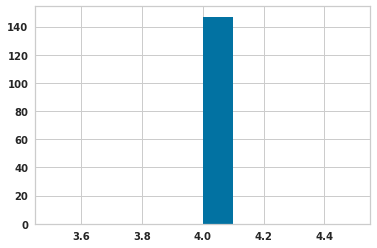

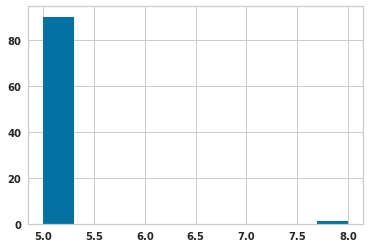

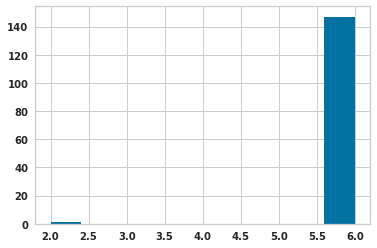

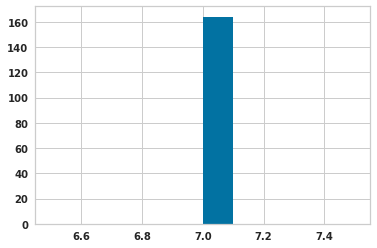

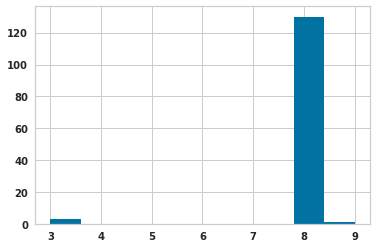

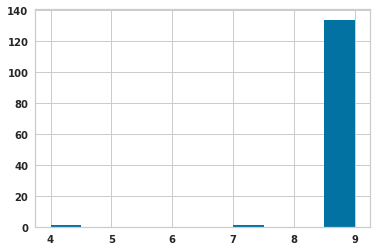

In [114]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [115]:
# manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

# manual_annotation_df = None
# if os.path.isfile(manual_annotation_file):
#     print("Reading existing manual annotation file")
#     manual_annotation_df = pd.read_csv(manual_annotation_file)

# epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

# if manual_annotation_df is not None:
#     manual_annotation_df[epoch_col_label] = df["manual_annotation"]
#     manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
# else:
#     print("No existing manual annotation file. Creating new manual annotation dataframe")
#     manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
#     manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

# all_columns = list(manual_annotation_df.columns)
# previous_epochs_completed = []
# for i in range(int(epochs_completed) + 1):
#     epoch_col_label = f"manual_label_{i}"
#     print(epoch_col_label)
#     if epoch_col_label in all_columns:
#         previous_epochs_completed.append(i)


# manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
#                                                                                        previous_epochs_completed),
#                                                      axis=1)
# manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
#                                                                                                   previous_epochs_completed),
#                                                                 axis=1)

        

# manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

# Iteration 4

In [116]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [117]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        root_path=root_path,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 5, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual 

Epoch: 4/59, Nll_loss : 110.23745727539062 KLD:10.152189254760742  Supervised loss:0.1358221173286438
Epoch: 4/60, Nll_loss : 117.75496673583984 KLD:9.542551040649414  Supervised loss:0.15719248354434967
Epoch: 4/61, Nll_loss : 118.29945373535156 KLD:9.377065658569336  Supervised loss:0.10242021828889847
Epoch: 4/62, Nll_loss : 138.06777954101562 KLD:9.05804443359375  Supervised loss:0.16424870491027832
Epoch: 4/63, Nll_loss : 129.0569305419922 KLD:8.702156066894531  Supervised loss:0.13782088458538055
Epoch: 4/64, Nll_loss : 124.59235382080078 KLD:8.416070938110352  Supervised loss:0.16395974159240723
Epoch: 4/65, Nll_loss : 130.77444458007812 KLD:8.677153587341309  Supervised loss:0.1144355982542038
Epoch: 4/66, Nll_loss : 117.29181671142578 KLD:8.861307144165039  Supervised loss:0.10447117686271667
Epoch: 4/67, Nll_loss : 119.54765319824219 KLD:8.595510482788086  Supervised loss:0.14076027274131775
Epoch: 4/68, Nll_loss : 125.75660705566406 KLD:9.634648323059082  Supervised loss:0.1

Epoch: 4/141, Nll_loss : 122.6197509765625 KLD:9.408096313476562  Supervised loss:0.0753752812743187
Epoch: 4/142, Nll_loss : 121.79777526855469 KLD:9.773740768432617  Supervised loss:0.12296473979949951
Epoch: 4/143, Nll_loss : 121.98126220703125 KLD:9.599432945251465  Supervised loss:0.16850140690803528
Epoch: 4/144, Nll_loss : 120.06770324707031 KLD:9.622103691101074  Supervised loss:0.11002834141254425
Epoch: 4/145, Nll_loss : 121.55203247070312 KLD:9.266424179077148  Supervised loss:0.10278643667697906
Epoch: 4/146, Nll_loss : 116.67327880859375 KLD:9.67238712310791  Supervised loss:0.12862396240234375
Epoch: 4/147, Nll_loss : 123.8492431640625 KLD:9.509747505187988  Supervised loss:0.10992158204317093
Epoch: 4/148, Nll_loss : 136.0893096923828 KLD:9.272672653198242  Supervised loss:0.18184298276901245
Epoch: 4/149, Nll_loss : 117.19586181640625 KLD:9.385400772094727  Supervised loss:0.09375438094139099
Epoch: 4/150, Nll_loss : 128.56216430664062 KLD:9.93699836730957  Supervised l

Epoch: 4/224, Nll_loss : 129.9386749267578 KLD:9.525629043579102  Supervised loss:0.10508748888969421
Epoch: 4/225, Nll_loss : 129.9693145751953 KLD:9.169143676757812  Supervised loss:0.13393902778625488
Epoch: 4/226, Nll_loss : 121.51823425292969 KLD:9.35837459564209  Supervised loss:0.07651887834072113
Epoch: 4/227, Nll_loss : 122.81285095214844 KLD:9.032261848449707  Supervised loss:0.16757114231586456
Epoch: 4/228, Nll_loss : 122.47665405273438 KLD:9.563102722167969  Supervised loss:0.08805419504642487
Epoch: 4/229, Nll_loss : 117.30387115478516 KLD:10.12385368347168  Supervised loss:0.15902432799339294
Epoch: 4/230, Nll_loss : 126.8636474609375 KLD:9.837971687316895  Supervised loss:0.11368386447429657
Epoch: 4/231, Nll_loss : 124.48690795898438 KLD:10.029218673706055  Supervised loss:0.13057675957679749
Epoch: 4/232, Nll_loss : 118.24984741210938 KLD:9.589648246765137  Supervised loss:0.0785531997680664
Epoch: 4/233, Nll_loss : 117.71900939941406 KLD:10.15297794342041  Supervised

Epoch: 4/307, Nll_loss : 119.65414428710938 KLD:9.295827865600586  Supervised loss:0.09988496452569962
Epoch: 4/308, Nll_loss : 129.97744750976562 KLD:9.770295143127441  Supervised loss:0.08815509080886841
Epoch: 4/309, Nll_loss : 117.05404663085938 KLD:9.72413444519043  Supervised loss:0.0630088821053505
Epoch: 4/310, Nll_loss : 129.03578186035156 KLD:9.864424705505371  Supervised loss:0.12094594538211823
Epoch: 4/311, Nll_loss : 128.58453369140625 KLD:9.702998161315918  Supervised loss:0.19816604256629944
Epoch: 4/312, Nll_loss : 123.31256103515625 KLD:10.14256763458252  Supervised loss:0.08724001049995422
Epoch: 4/313, Nll_loss : 122.5483627319336 KLD:9.719301223754883  Supervised loss:0.07686847448348999
Epoch: 4/314, Nll_loss : 114.20970153808594 KLD:9.3266019821167  Supervised loss:0.08431622385978699
Epoch: 4/315, Nll_loss : 118.7595443725586 KLD:9.112358093261719  Supervised loss:0.09263262152671814
Epoch: 4/316, Nll_loss : 123.1325912475586 KLD:9.023651123046875  Supervised lo

Epoch: 4/388, Nll_loss : 120.17305755615234 KLD:9.856222152709961  Supervised loss:0.12077786028385162
Epoch: 4/389, Nll_loss : 119.72727966308594 KLD:9.814002990722656  Supervised loss:0.07324956357479095
Epoch: 4/390, Nll_loss : 121.177734375 KLD:10.224864959716797  Supervised loss:0.09907452017068863
Epoch: 4/391, Nll_loss : 115.92982482910156 KLD:9.78529167175293  Supervised loss:0.11654435843229294
Epoch: 4/392, Nll_loss : 119.58439636230469 KLD:9.966081619262695  Supervised loss:0.06778515875339508
Epoch: 4/393, Nll_loss : 127.51068878173828 KLD:9.533884048461914  Supervised loss:0.08110591769218445
Epoch: 4/394, Nll_loss : 122.81617736816406 KLD:9.496447563171387  Supervised loss:0.10130424797534943
Epoch: 4/395, Nll_loss : 122.80937957763672 KLD:8.80813217163086  Supervised loss:0.12676715850830078
Epoch: 4/396, Nll_loss : 119.79515075683594 KLD:9.31581974029541  Supervised loss:0.11882005631923676
Epoch: 4/397, Nll_loss : 115.70863342285156 KLD:8.78178882598877  Supervised los

Epoch: 4/471, Nll_loss : 118.9353256225586 KLD:9.125585556030273  Supervised loss:0.10316675901412964
Epoch: 4/472, Nll_loss : 123.43944549560547 KLD:9.403352737426758  Supervised loss:0.167581707239151
Epoch: 4/473, Nll_loss : 119.4764404296875 KLD:9.402615547180176  Supervised loss:0.094915971159935
Epoch: 4/474, Nll_loss : 117.75999450683594 KLD:9.13102912902832  Supervised loss:0.10412245243787766
Epoch: 4/475, Nll_loss : 124.84819030761719 KLD:9.372130393981934  Supervised loss:0.08926810324192047
Epoch: 4/476, Nll_loss : 116.90381622314453 KLD:9.466434478759766  Supervised loss:0.13196460902690887
Epoch: 4/477, Nll_loss : 121.70425415039062 KLD:9.289875030517578  Supervised loss:0.10270345956087112
Epoch: 4/478, Nll_loss : 119.53556823730469 KLD:8.866531372070312  Supervised loss:0.22018174827098846
Epoch: 4/479, Nll_loss : 129.57806396484375 KLD:8.744473457336426  Supervised loss:0.09291387349367142
Epoch: 4/480, Nll_loss : 121.21051788330078 KLD:8.621225357055664  Supervised lo

Epoch: 4/553, Nll_loss : 125.94918060302734 KLD:8.905952453613281  Supervised loss:0.11849090456962585
Epoch: 4/554, Nll_loss : 122.20808410644531 KLD:8.783605575561523  Supervised loss:0.1635442078113556
Epoch: 4/555, Nll_loss : 122.5203857421875 KLD:9.682682037353516  Supervised loss:0.07739713788032532
Epoch: 4/556, Nll_loss : 124.64273834228516 KLD:9.909431457519531  Supervised loss:0.07587151974439621
Epoch: 4/557, Nll_loss : 115.58268737792969 KLD:9.688406944274902  Supervised loss:0.07548009604215622
Epoch: 4/558, Nll_loss : 118.63555908203125 KLD:9.568536758422852  Supervised loss:0.06615283340215683
Epoch: 4/559, Nll_loss : 118.89527893066406 KLD:9.972099304199219  Supervised loss:0.155292347073555
Epoch: 4/560, Nll_loss : 114.80726623535156 KLD:9.179886817932129  Supervised loss:0.1725919544696808
Epoch: 4/561, Nll_loss : 117.43387603759766 KLD:9.078307151794434  Supervised loss:0.10311131179332733
Epoch: 4/562, Nll_loss : 122.00096130371094 KLD:8.742738723754883  Supervised 

Epoch: 4/634, Nll_loss : 120.78031921386719 KLD:9.075582504272461  Supervised loss:0.07476069033145905
Epoch: 4/635, Nll_loss : 122.30850219726562 KLD:9.369407653808594  Supervised loss:0.10222011804580688
Epoch: 4/636, Nll_loss : 119.00668334960938 KLD:9.181148529052734  Supervised loss:0.10534406453371048
Epoch: 4/637, Nll_loss : 116.02662658691406 KLD:9.160726547241211  Supervised loss:0.1597941815853119
Epoch: 4/638, Nll_loss : 121.74523162841797 KLD:8.930816650390625  Supervised loss:0.15062063932418823
Epoch: 4/639, Nll_loss : 131.25750732421875 KLD:9.043807983398438  Supervised loss:0.10954602062702179
Epoch: 4/640, Nll_loss : 118.80941009521484 KLD:9.104438781738281  Supervised loss:0.127654567360878
Epoch: 4/641, Nll_loss : 121.61788940429688 KLD:8.876401901245117  Supervised loss:0.06188169866800308
Epoch: 4/642, Nll_loss : 132.45440673828125 KLD:9.396867752075195  Supervised loss:0.07935987412929535
Epoch: 4/643, Nll_loss : 124.46519470214844 KLD:9.346857070922852  Supervise

Epoch: 4/715, Nll_loss : 120.32804870605469 KLD:8.678569793701172  Supervised loss:0.07542578876018524
Epoch: 4/716, Nll_loss : 115.71987915039062 KLD:9.008078575134277  Supervised loss:0.06975137442350388
Epoch: 4/717, Nll_loss : 123.59561920166016 KLD:9.45828628540039  Supervised loss:0.07965298742055893
Epoch: 4/718, Nll_loss : 112.4126968383789 KLD:9.018672943115234  Supervised loss:0.08576645702123642
Epoch: 4/719, Nll_loss : 123.38710021972656 KLD:9.09415054321289  Supervised loss:0.16270780563354492
Epoch: 4/720, Nll_loss : 121.57400512695312 KLD:9.04365348815918  Supervised loss:0.08055050671100616
Epoch: 4/721, Nll_loss : 120.8365707397461 KLD:8.84012222290039  Supervised loss:0.15874136984348297
Epoch: 4/722, Nll_loss : 115.40425109863281 KLD:9.125930786132812  Supervised loss:0.12464539706707001
Epoch: 4/723, Nll_loss : 117.30911254882812 KLD:9.356081008911133  Supervised loss:0.0811249241232872
Epoch: 4/724, Nll_loss : 121.97904968261719 KLD:9.218714714050293  Supervised lo

Epoch: 4/797, Nll_loss : 121.17400360107422 KLD:9.151788711547852  Supervised loss:0.08112744987010956
Epoch: 4/798, Nll_loss : 125.65049743652344 KLD:8.587784767150879  Supervised loss:0.15520387887954712
Epoch: 4/799, Nll_loss : 128.6942138671875 KLD:9.458586692810059  Supervised loss:0.0674145370721817
Epoch: 4/800, Nll_loss : 123.20176696777344 KLD:9.25265121459961  Supervised loss:0.10458937287330627
Epoch: 4/801, Nll_loss : 116.87584686279297 KLD:9.169717788696289  Supervised loss:0.08324513584375381
Epoch: 4/802, Nll_loss : 114.37995910644531 KLD:9.623546600341797  Supervised loss:0.04197894409298897
Epoch: 4/803, Nll_loss : 116.70823669433594 KLD:9.113036155700684  Supervised loss:0.06759579479694366
Epoch: 4/804, Nll_loss : 118.1380615234375 KLD:9.435532569885254  Supervised loss:0.10651429742574692
Epoch: 4/805, Nll_loss : 124.83529663085938 KLD:9.010818481445312  Supervised loss:0.14832422137260437
Epoch: 4/806, Nll_loss : 117.1049575805664 KLD:9.161035537719727  Supervised 

Epoch: 4/879, Nll_loss : 111.61885833740234 KLD:9.725421905517578  Supervised loss:0.06515185534954071
Epoch: 4/880, Nll_loss : 115.29464721679688 KLD:9.180907249450684  Supervised loss:0.1689886599779129
Epoch: 4/881, Nll_loss : 118.9551010131836 KLD:9.402738571166992  Supervised loss:0.13777261972427368
Epoch: 4/882, Nll_loss : 118.14741516113281 KLD:9.206214904785156  Supervised loss:0.1265796273946762
Epoch: 4/883, Nll_loss : 113.08366394042969 KLD:9.105123519897461  Supervised loss:0.10466881096363068
Epoch: 4/884, Nll_loss : 122.09717559814453 KLD:9.272254943847656  Supervised loss:0.09469015896320343
Epoch: 4/885, Nll_loss : 113.25093841552734 KLD:8.925131797790527  Supervised loss:0.05287332460284233
Epoch: 4/886, Nll_loss : 123.2328872680664 KLD:9.01197624206543  Supervised loss:0.15409404039382935
Epoch: 4/887, Nll_loss : 121.75640106201172 KLD:8.87142276763916  Supervised loss:0.10173360258340836
Epoch: 4/888, Nll_loss : 116.30414581298828 KLD:9.038063049316406  Supervised l

In [118]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassi

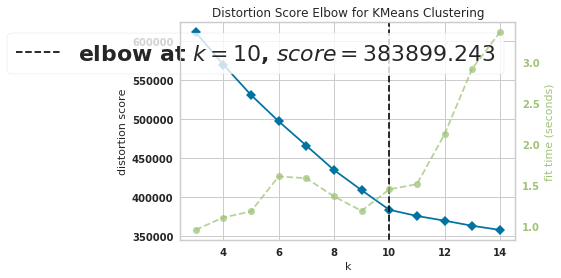

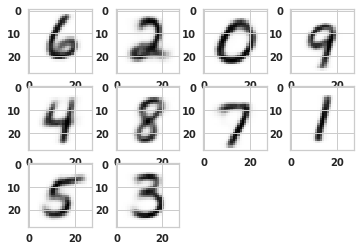

In [119]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [120]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 2, 0, 9,
                                           4, 8, 7, 1,
                                           5, 3
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


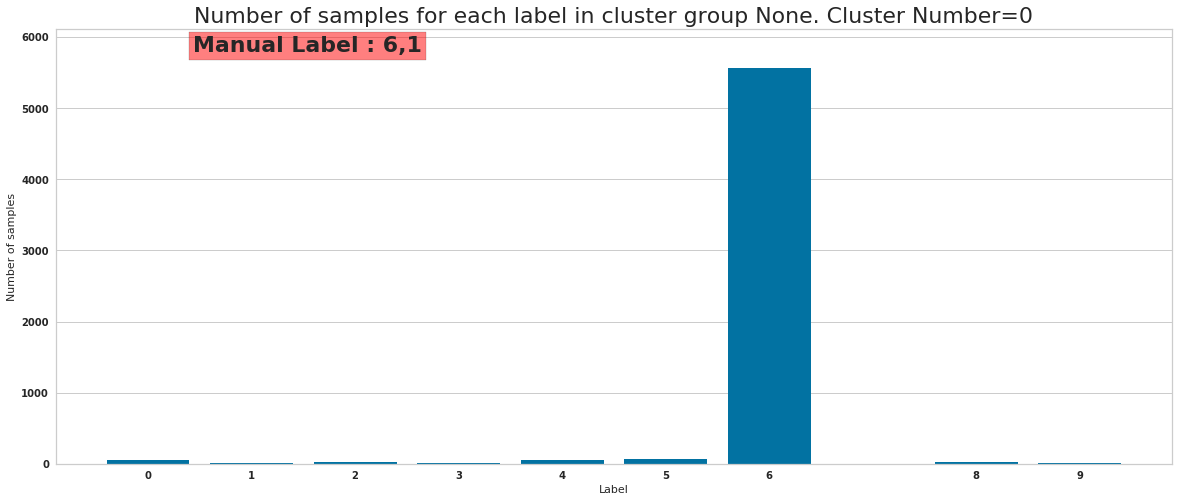

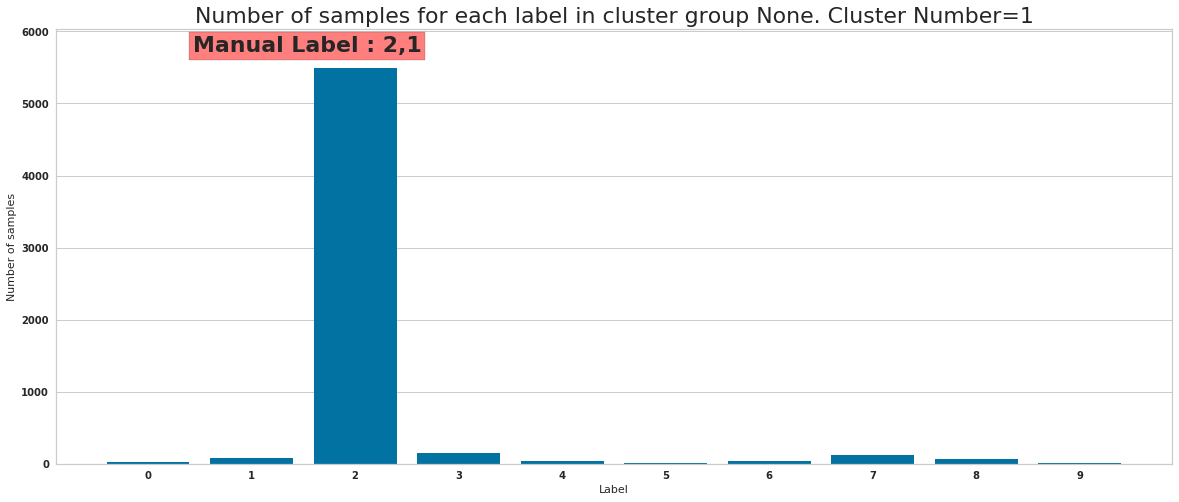

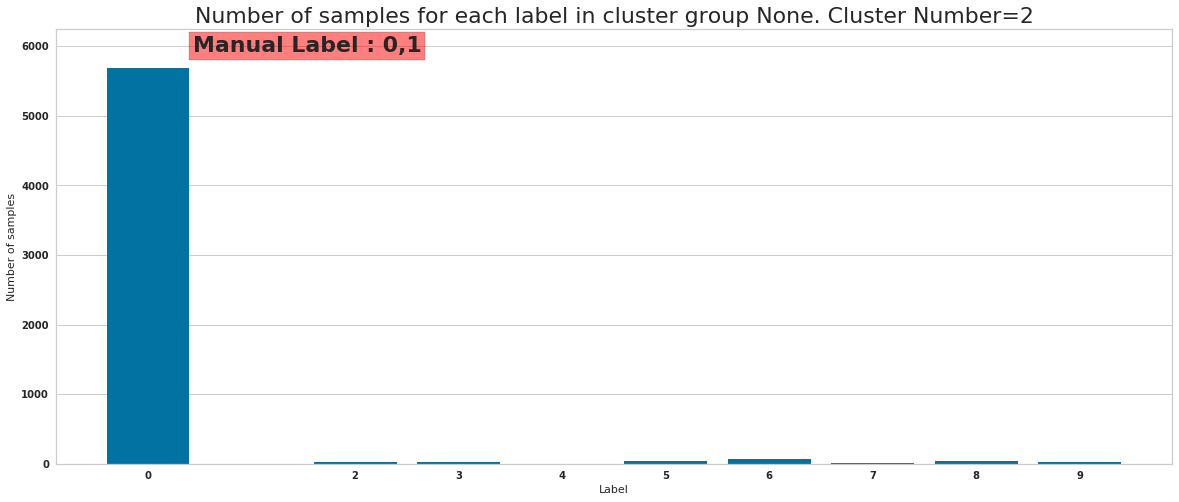

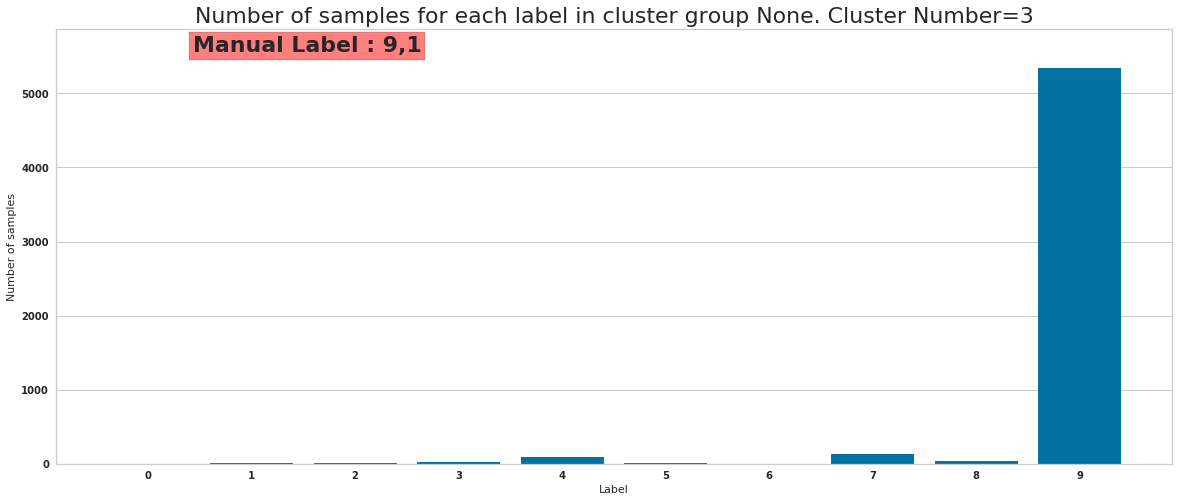

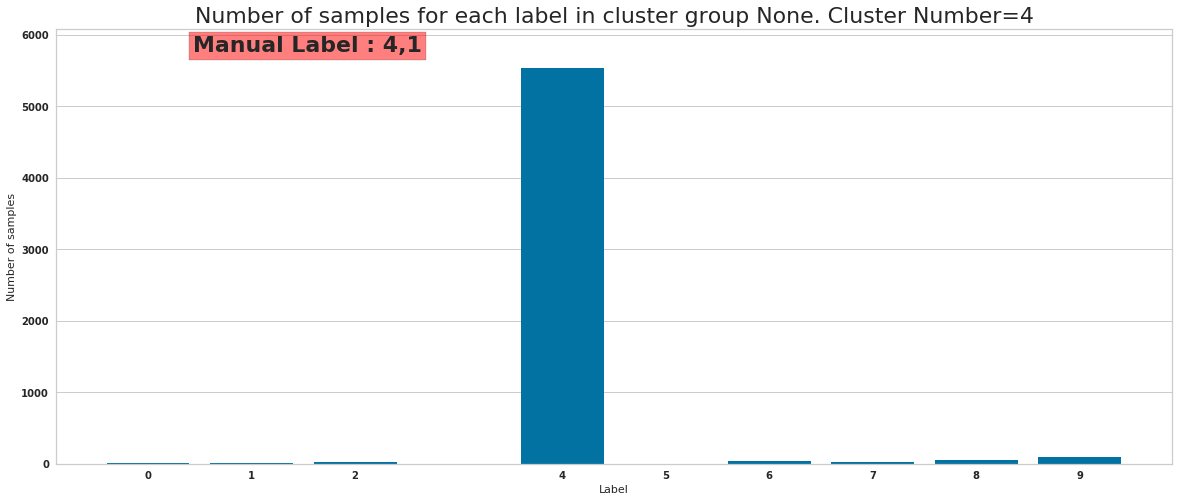

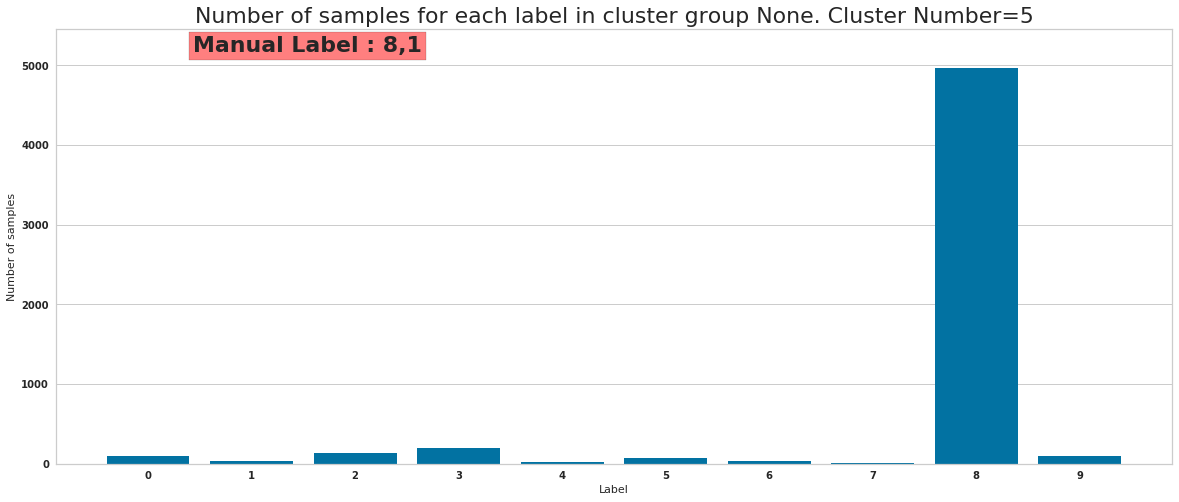

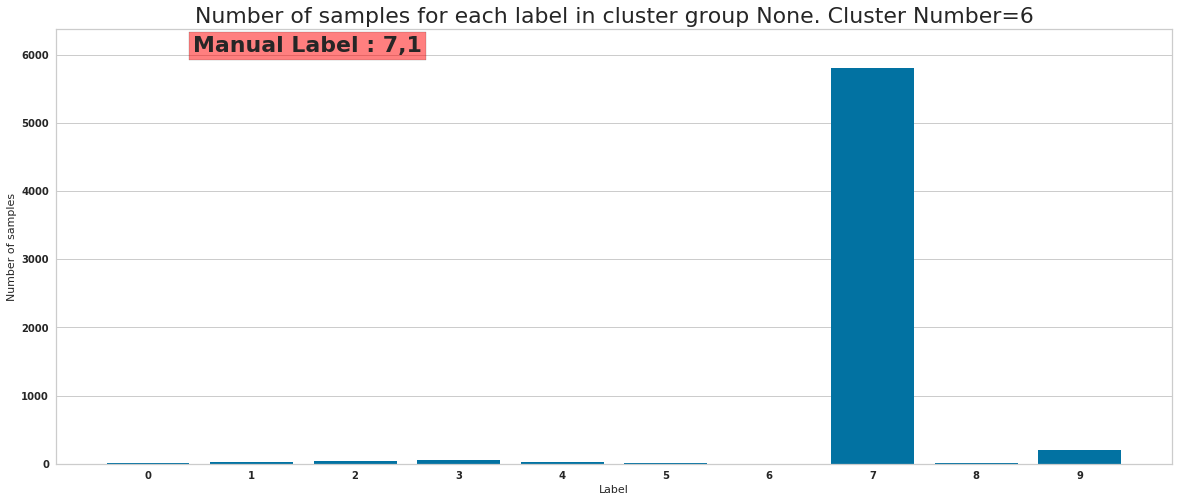

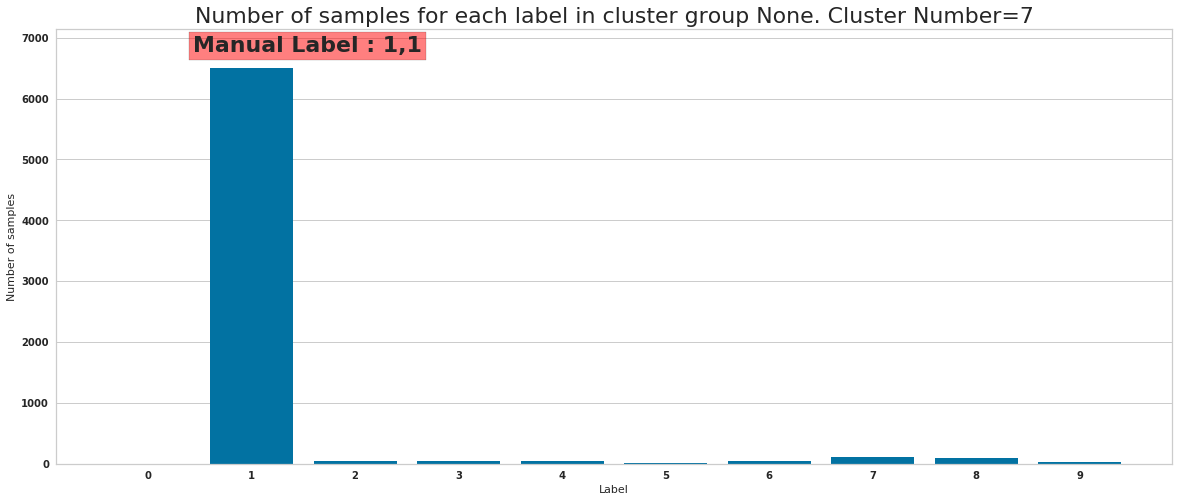

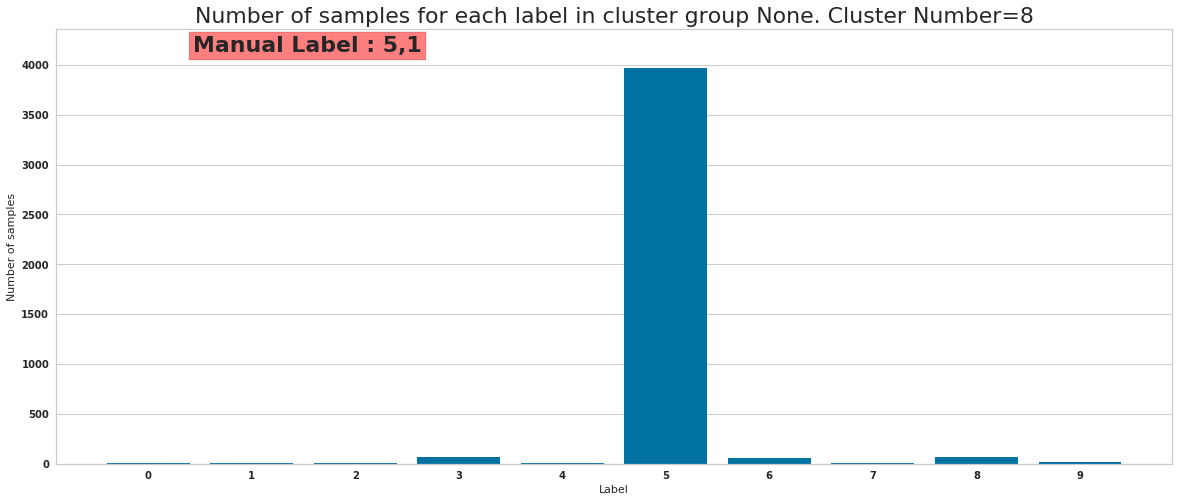

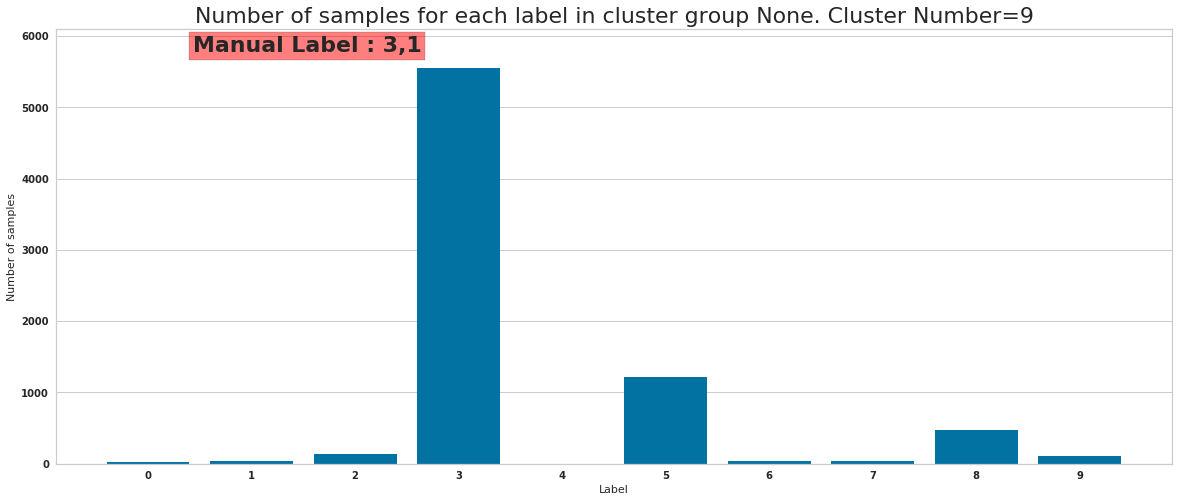

In [121]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [122]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5808, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6020, 10)
(5922, 10)
(5647, 10)
(5788, 10)
(5685, 10)
(6163, 10)
(6951, 10)
(4218, 10)
(7638, 10)


In [123]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [124]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster, cluster_column_name_2)    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5808, 47) (5808, 33)
Num correct=5560
Cluster 0 Manual Label 6 Percentage correct 95.73002754820936
********************************
Manual Label 2
(6020, 47) (6020, 33)
Num correct=5486
Cluster 1 Manual Label 2 Percentage correct 91.12956810631229
********************************
Manual Label 0
(5922, 47) (5922, 33)
Num correct=5680
Cluster 2 Manual Label 0 Percentage correct 95.91354272205336
********************************
Manual Label 9
(5647, 47) (5647, 33)
Num correct=5336
Cluster 3 Manual Label 9 Percentage correct 94.49265096511422
********************************
Manual Label 4
(5788, 47) (5788, 33)
Num correct=5530
Cluster 4 Manual Label 4 Percentage correct 95.5425017277125
********************************
Manual Label 8
(5685, 47) (5685, 33)
Num correct=4961
Cluster 5 Manual Label 8 Percentage correct 87.26473175021988
********************************
Manual Label 7
(6163, 47) (6163, 33)
Num correct=5797
Cluster 6 Manual Label 7 Percentage correct 94.061333

In [125]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5


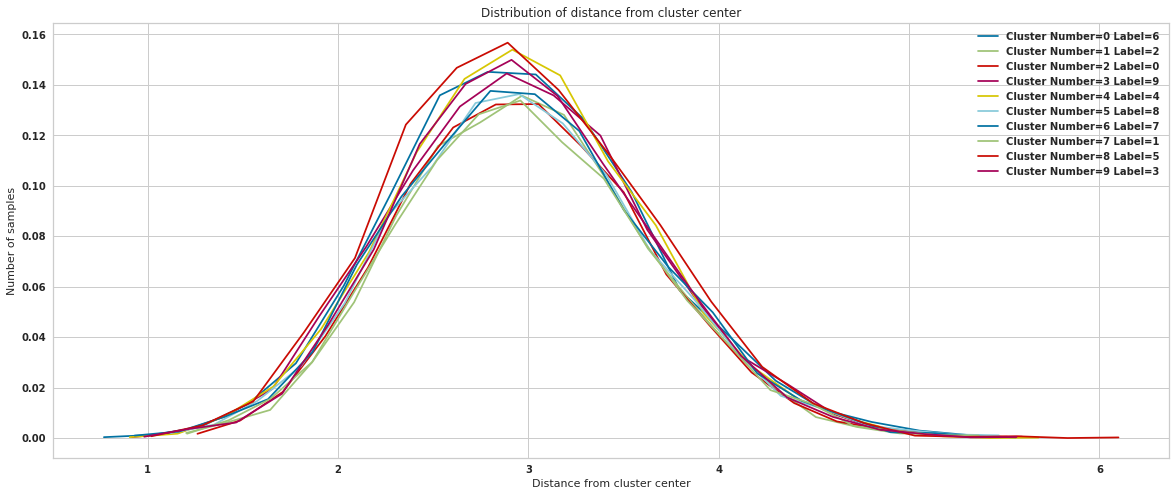

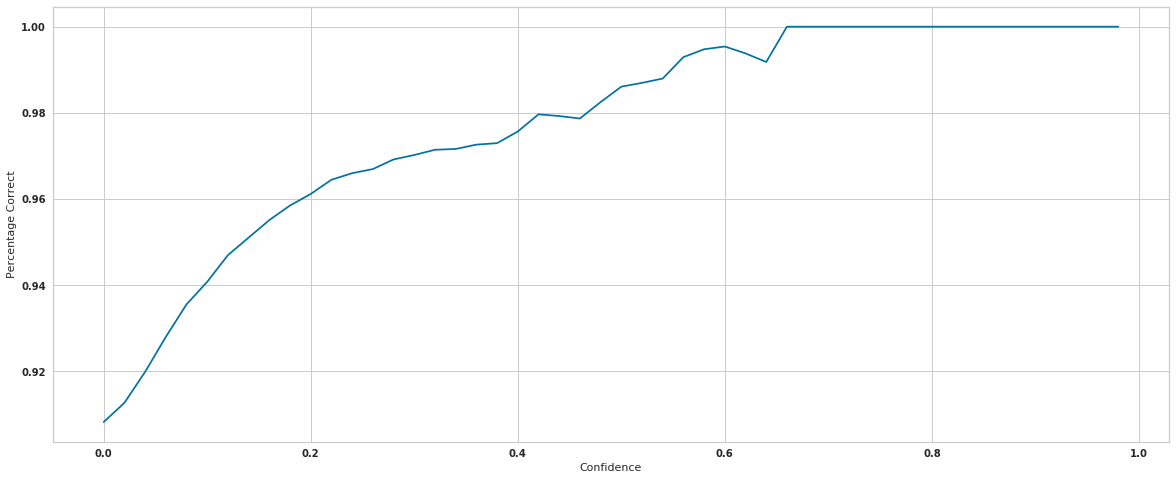

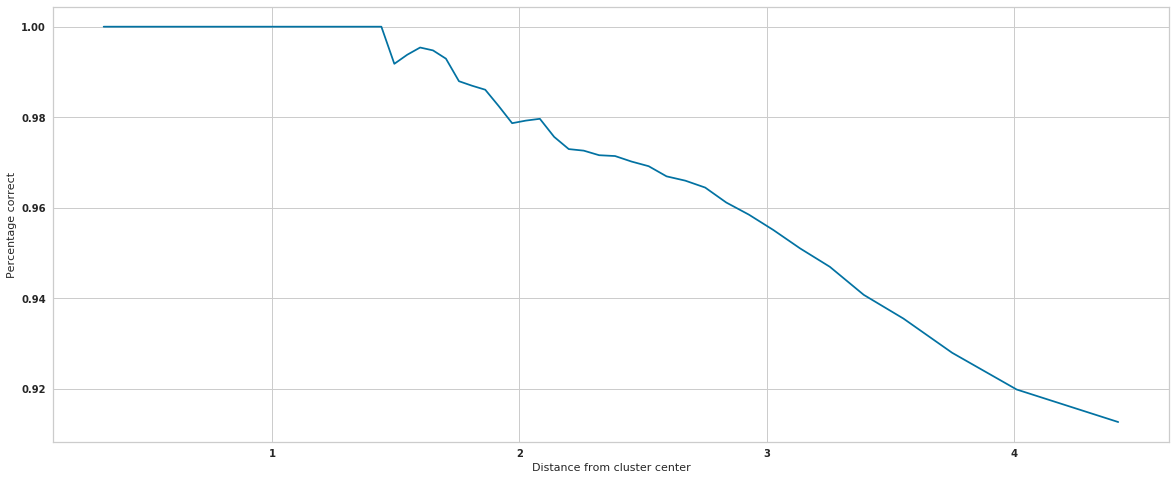

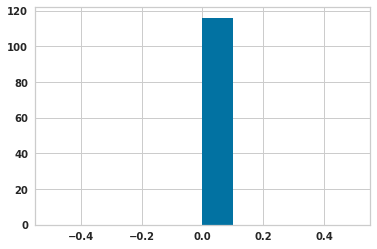

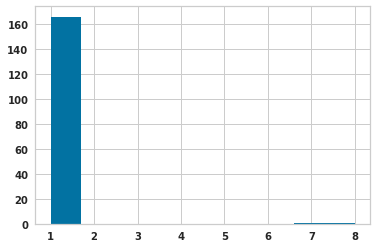

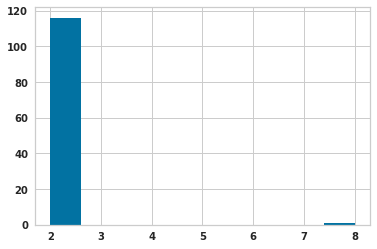

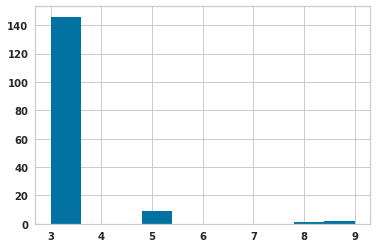

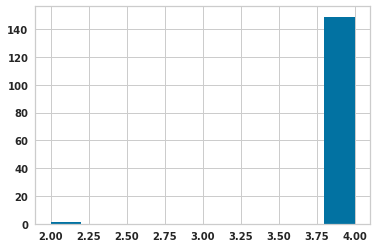

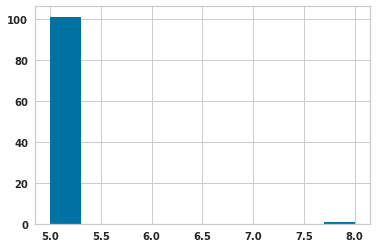

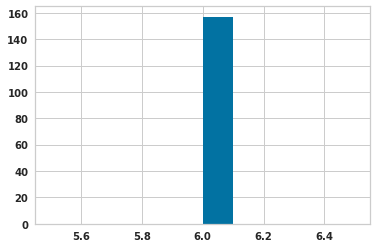

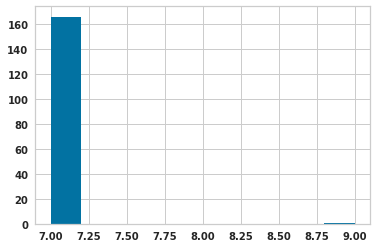

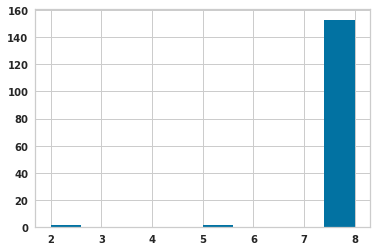

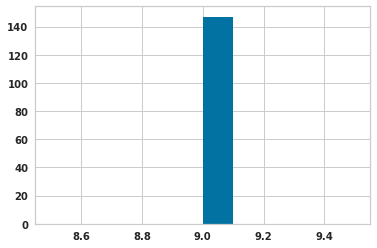

In [126]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [127]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [128]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 5, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual 

Epoch: 5/60, Nll_loss : 115.4195785522461 KLD:9.487687110900879  Supervised loss:0.10137486457824707
Epoch: 5/61, Nll_loss : 116.70503997802734 KLD:9.584512710571289  Supervised loss:0.05801558494567871
Epoch: 5/62, Nll_loss : 129.8948211669922 KLD:9.656280517578125  Supervised loss:0.09053336083889008
Epoch: 5/63, Nll_loss : 123.51554870605469 KLD:9.351760864257812  Supervised loss:0.06726428121328354
Epoch: 5/64, Nll_loss : 122.30390167236328 KLD:8.998054504394531  Supervised loss:0.07111978530883789
Epoch: 5/65, Nll_loss : 124.05635070800781 KLD:9.270050048828125  Supervised loss:0.06211107224225998
Epoch: 5/66, Nll_loss : 109.68217468261719 KLD:8.955767631530762  Supervised loss:0.06288999319076538
Epoch: 5/67, Nll_loss : 115.1744384765625 KLD:8.379156112670898  Supervised loss:0.06061195954680443
Epoch: 5/68, Nll_loss : 121.78578186035156 KLD:8.680742263793945  Supervised loss:0.10943064838647842
Epoch: 5/69, Nll_loss : 126.24205017089844 KLD:8.811441421508789  Supervised loss:0.1

Epoch: 5/141, Nll_loss : 120.36933898925781 KLD:9.030841827392578  Supervised loss:0.06543336808681488
Epoch: 5/142, Nll_loss : 120.90721130371094 KLD:9.245132446289062  Supervised loss:0.059847790747880936
Epoch: 5/143, Nll_loss : 119.3940200805664 KLD:9.056405067443848  Supervised loss:0.14927710592746735
Epoch: 5/144, Nll_loss : 116.96983337402344 KLD:9.382631301879883  Supervised loss:0.060329899191856384
Epoch: 5/145, Nll_loss : 122.77814483642578 KLD:9.121817588806152  Supervised loss:0.07286779582500458
Epoch: 5/146, Nll_loss : 114.0420150756836 KLD:9.679826736450195  Supervised loss:0.0828779935836792
Epoch: 5/147, Nll_loss : 118.97203063964844 KLD:9.89165210723877  Supervised loss:0.0626382827758789
Epoch: 5/148, Nll_loss : 125.83883666992188 KLD:9.71104621887207  Supervised loss:0.09218516200780869
Epoch: 5/149, Nll_loss : 114.121337890625 KLD:9.504249572753906  Supervised loss:0.07126475870609283
Epoch: 5/150, Nll_loss : 121.6763916015625 KLD:9.730311393737793  Supervised lo

Epoch: 5/223, Nll_loss : 124.07878112792969 KLD:8.845057487487793  Supervised loss:0.07166889309883118
Epoch: 5/224, Nll_loss : 121.7384033203125 KLD:9.278382301330566  Supervised loss:0.055524252355098724
Epoch: 5/225, Nll_loss : 126.64920806884766 KLD:8.783500671386719  Supervised loss:0.06475594639778137
Epoch: 5/226, Nll_loss : 123.30345153808594 KLD:8.793840408325195  Supervised loss:0.08721800148487091
Epoch: 5/227, Nll_loss : 122.7864990234375 KLD:8.69074535369873  Supervised loss:0.13452181220054626
Epoch: 5/228, Nll_loss : 124.42250061035156 KLD:9.107941627502441  Supervised loss:0.07570207118988037
Epoch: 5/229, Nll_loss : 114.89456176757812 KLD:9.861312866210938  Supervised loss:0.07326298952102661
Epoch: 5/230, Nll_loss : 122.98674011230469 KLD:9.748268127441406  Supervised loss:0.06828486919403076
Epoch: 5/231, Nll_loss : 124.02520751953125 KLD:9.73449993133545  Supervised loss:0.07999417185783386
Epoch: 5/232, Nll_loss : 113.5452880859375 KLD:9.588190078735352  Supervised

Epoch: 5/305, Nll_loss : 114.13517761230469 KLD:9.470789909362793  Supervised loss:0.04354626685380936
Epoch: 5/306, Nll_loss : 122.8713607788086 KLD:9.502449035644531  Supervised loss:0.06871636211872101
Epoch: 5/307, Nll_loss : 117.87889099121094 KLD:9.369006156921387  Supervised loss:0.07691876590251923
Epoch: 5/308, Nll_loss : 130.6754150390625 KLD:9.361872673034668  Supervised loss:0.09444573521614075
Epoch: 5/309, Nll_loss : 117.6572494506836 KLD:9.12368392944336  Supervised loss:0.042763203382492065
Epoch: 5/310, Nll_loss : 131.3494110107422 KLD:9.311689376831055  Supervised loss:0.08107288181781769
Epoch: 5/311, Nll_loss : 127.42961120605469 KLD:9.381240844726562  Supervised loss:0.08038976043462753
Epoch: 5/312, Nll_loss : 123.04496765136719 KLD:9.591275215148926  Supervised loss:0.05001557618379593
Epoch: 5/313, Nll_loss : 125.47322082519531 KLD:9.107669830322266  Supervised loss:0.05708153173327446
Epoch: 5/314, Nll_loss : 114.82489013671875 KLD:8.998001098632812  Supervised

Epoch: 5/385, Nll_loss : 120.41654968261719 KLD:9.33529281616211  Supervised loss:0.09773628413677216
Epoch: 5/386, Nll_loss : 123.74835205078125 KLD:9.453060150146484  Supervised loss:0.036684997379779816
Epoch: 5/387, Nll_loss : 115.4840316772461 KLD:9.128837585449219  Supervised loss:0.0759313553571701
Epoch: 5/388, Nll_loss : 118.853515625 KLD:9.133392333984375  Supervised loss:0.06728271394968033
Epoch: 5/389, Nll_loss : 121.21759033203125 KLD:9.011968612670898  Supervised loss:0.062821164727211
Epoch: 5/390, Nll_loss : 121.11320495605469 KLD:9.246382713317871  Supervised loss:0.11415208876132965
Epoch: 5/391, Nll_loss : 111.228515625 KLD:9.101213455200195  Supervised loss:0.07744753360748291
Epoch: 5/392, Nll_loss : 115.22465515136719 KLD:9.307071685791016  Supervised loss:0.05152147263288498
Epoch: 5/393, Nll_loss : 122.95581817626953 KLD:9.374279022216797  Supervised loss:0.09378700703382492
Epoch: 5/394, Nll_loss : 119.91986083984375 KLD:9.66671371459961  Supervised loss:0.086

Epoch: 5/468, Nll_loss : 122.81939697265625 KLD:9.284167289733887  Supervised loss:0.10722575336694717
Epoch: 5/469, Nll_loss : 115.49601745605469 KLD:8.935810089111328  Supervised loss:0.057779643684625626
Epoch: 5/470, Nll_loss : 113.36122131347656 KLD:9.249326705932617  Supervised loss:0.04989119619131088
Epoch: 5/471, Nll_loss : 118.33263397216797 KLD:8.842893600463867  Supervised loss:0.0702100396156311
Epoch: 5/472, Nll_loss : 123.22026824951172 KLD:8.81911849975586  Supervised loss:0.13600248098373413
Epoch: 5/473, Nll_loss : 117.25965881347656 KLD:8.782523155212402  Supervised loss:0.07912661135196686
Epoch: 5/474, Nll_loss : 118.80377197265625 KLD:8.667586326599121  Supervised loss:0.07543677091598511
Epoch: 5/475, Nll_loss : 122.48956298828125 KLD:8.925281524658203  Supervised loss:0.05736074596643448
Epoch: 5/476, Nll_loss : 117.40678405761719 KLD:9.103004455566406  Supervised loss:0.08791284263134003
Epoch: 5/477, Nll_loss : 123.00128173828125 KLD:9.153297424316406  Supervi

Epoch: 5/549, Nll_loss : 117.42250061035156 KLD:8.594085693359375  Supervised loss:0.13277766108512878
Epoch: 5/550, Nll_loss : 117.52189636230469 KLD:8.65512752532959  Supervised loss:0.05036493390798569
Epoch: 5/551, Nll_loss : 120.35619354248047 KLD:8.705615997314453  Supervised loss:0.07957135885953903
Epoch: 5/552, Nll_loss : 114.58786010742188 KLD:8.522335052490234  Supervised loss:0.07718555629253387
Epoch: 5/553, Nll_loss : 120.74407958984375 KLD:9.14822769165039  Supervised loss:0.0709739625453949
Epoch: 5/554, Nll_loss : 119.97564697265625 KLD:8.945663452148438  Supervised loss:0.12351925671100616
Epoch: 5/555, Nll_loss : 121.63636779785156 KLD:9.601263046264648  Supervised loss:0.05723769962787628
Epoch: 5/556, Nll_loss : 120.85862731933594 KLD:9.896419525146484  Supervised loss:0.03449223190546036
Epoch: 5/557, Nll_loss : 114.69058227539062 KLD:9.612143516540527  Supervised loss:0.04299091547727585
Epoch: 5/558, Nll_loss : 119.89450073242188 KLD:9.3411283493042  Supervised 

Epoch: 5/630, Nll_loss : 119.05122375488281 KLD:9.641777038574219  Supervised loss:0.053505316376686096
Epoch: 5/631, Nll_loss : 115.64495086669922 KLD:9.165964126586914  Supervised loss:0.06897174566984177
Epoch: 5/632, Nll_loss : 115.61375427246094 KLD:9.170511245727539  Supervised loss:0.0788068100810051
Epoch: 5/633, Nll_loss : 114.14549255371094 KLD:8.883129119873047  Supervised loss:0.057530492544174194
Epoch: 5/634, Nll_loss : 118.01564025878906 KLD:8.895040512084961  Supervised loss:0.0804678350687027
Epoch: 5/635, Nll_loss : 117.15936279296875 KLD:9.084915161132812  Supervised loss:0.0790928527712822
Epoch: 5/636, Nll_loss : 120.01956939697266 KLD:8.822936058044434  Supervised loss:0.06830737739801407
Epoch: 5/637, Nll_loss : 111.542236328125 KLD:8.599973678588867  Supervised loss:0.11369523406028748
Epoch: 5/638, Nll_loss : 120.21382141113281 KLD:8.462117195129395  Supervised loss:0.1587853729724884
Epoch: 5/639, Nll_loss : 127.60865783691406 KLD:8.834506034851074  Supervised

Epoch: 5/711, Nll_loss : 116.94657897949219 KLD:9.077731132507324  Supervised loss:0.11874009668827057
Epoch: 5/712, Nll_loss : 121.258056640625 KLD:9.105809211730957  Supervised loss:0.07455490529537201
Epoch: 5/713, Nll_loss : 119.90312957763672 KLD:8.71389389038086  Supervised loss:0.14588451385498047
Epoch: 5/714, Nll_loss : 115.15766906738281 KLD:9.33350658416748  Supervised loss:0.04000905901193619
Epoch: 5/715, Nll_loss : 117.0234603881836 KLD:8.464628219604492  Supervised loss:0.08497556298971176
Epoch: 5/716, Nll_loss : 114.43440246582031 KLD:8.694748878479004  Supervised loss:0.06538473814725876
Epoch: 5/717, Nll_loss : 122.50022888183594 KLD:9.00103759765625  Supervised loss:0.11771048605442047
Epoch: 5/718, Nll_loss : 112.78797912597656 KLD:8.550326347351074  Supervised loss:0.05377379059791565
Epoch: 5/719, Nll_loss : 120.92279052734375 KLD:8.71282958984375  Supervised loss:0.10600446164608002
Epoch: 5/720, Nll_loss : 121.34162902832031 KLD:8.740106582641602  Supervised lo

Epoch: 5/792, Nll_loss : 122.95393371582031 KLD:8.95704460144043  Supervised loss:0.09393748641014099
Epoch: 5/793, Nll_loss : 110.80549621582031 KLD:8.631403923034668  Supervised loss:0.06110347807407379
Epoch: 5/794, Nll_loss : 120.72281646728516 KLD:9.077272415161133  Supervised loss:0.07607480138540268
Epoch: 5/795, Nll_loss : 119.08040618896484 KLD:9.090126037597656  Supervised loss:0.041596949100494385
Epoch: 5/796, Nll_loss : 127.56840515136719 KLD:9.355351448059082  Supervised loss:0.06709504872560501
Epoch: 5/797, Nll_loss : 115.31895446777344 KLD:9.573575019836426  Supervised loss:0.07945697009563446
Epoch: 5/798, Nll_loss : 119.70025634765625 KLD:9.180046081542969  Supervised loss:0.12438705563545227
Epoch: 5/799, Nll_loss : 126.15276336669922 KLD:10.10462760925293  Supervised loss:0.05828767269849777
Epoch: 5/800, Nll_loss : 115.13119506835938 KLD:9.963109970092773  Supervised loss:0.05251211300492287
Epoch: 5/801, Nll_loss : 113.45402526855469 KLD:9.537894248962402  Superv

Epoch: 5/874, Nll_loss : 120.9256591796875 KLD:9.147231101989746  Supervised loss:0.05909772962331772
Epoch: 5/875, Nll_loss : 118.6124496459961 KLD:9.118457794189453  Supervised loss:0.10305967926979065
Epoch: 5/876, Nll_loss : 112.98526000976562 KLD:8.988912582397461  Supervised loss:0.04756700247526169
Epoch: 5/877, Nll_loss : 119.25497436523438 KLD:9.3367919921875  Supervised loss:0.06279788166284561
Epoch: 5/878, Nll_loss : 125.23346710205078 KLD:9.272685050964355  Supervised loss:0.04968152940273285
Epoch: 5/879, Nll_loss : 110.2812271118164 KLD:9.270370483398438  Supervised loss:0.08291459083557129
Epoch: 5/880, Nll_loss : 115.0014419555664 KLD:8.865976333618164  Supervised loss:0.10532059520483017
Epoch: 5/881, Nll_loss : 120.02314758300781 KLD:9.24525260925293  Supervised loss:0.10735573619604111
Epoch: 5/882, Nll_loss : 119.6368408203125 KLD:9.171141624450684  Supervised loss:0.09342274814844131
Epoch: 5/883, Nll_loss : 106.39844512939453 KLD:9.27973461151123  Supervised loss

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassi

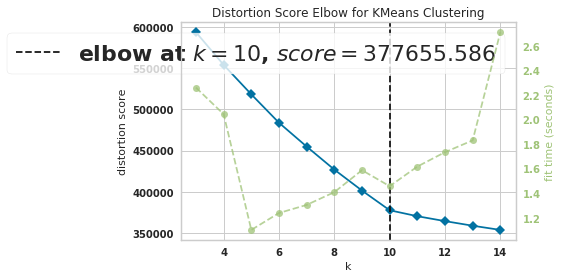

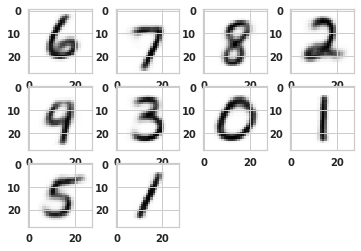

In [129]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


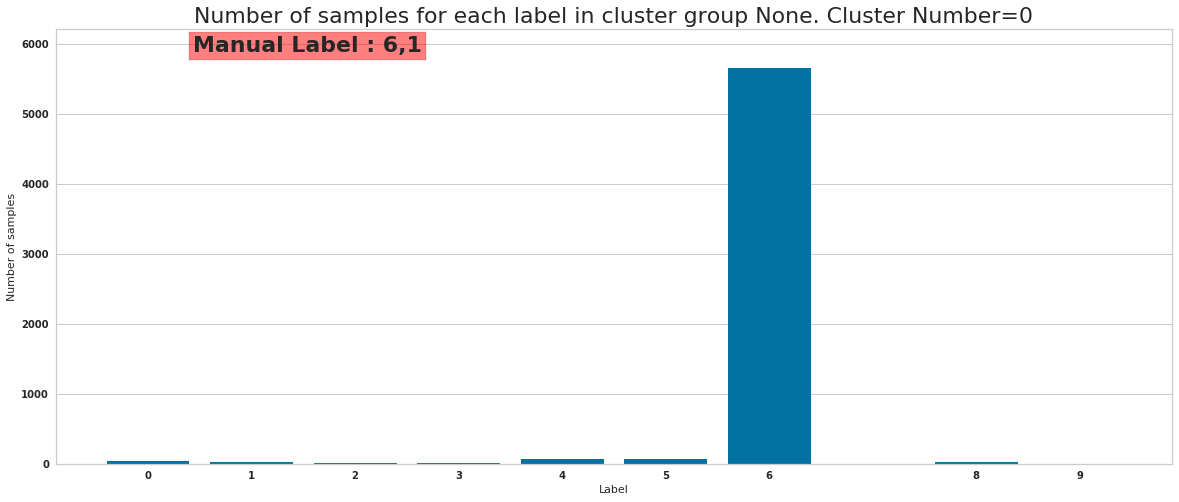

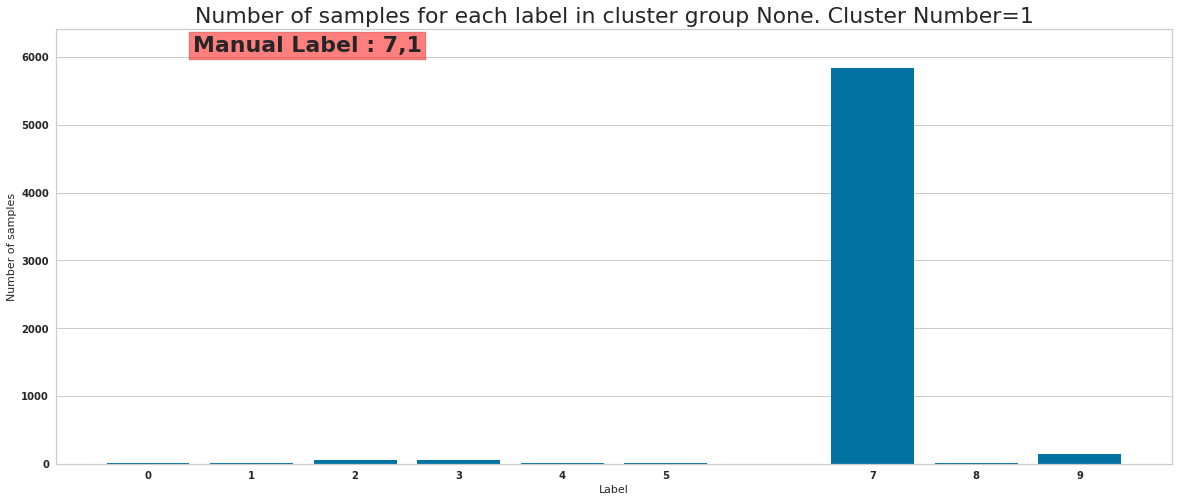

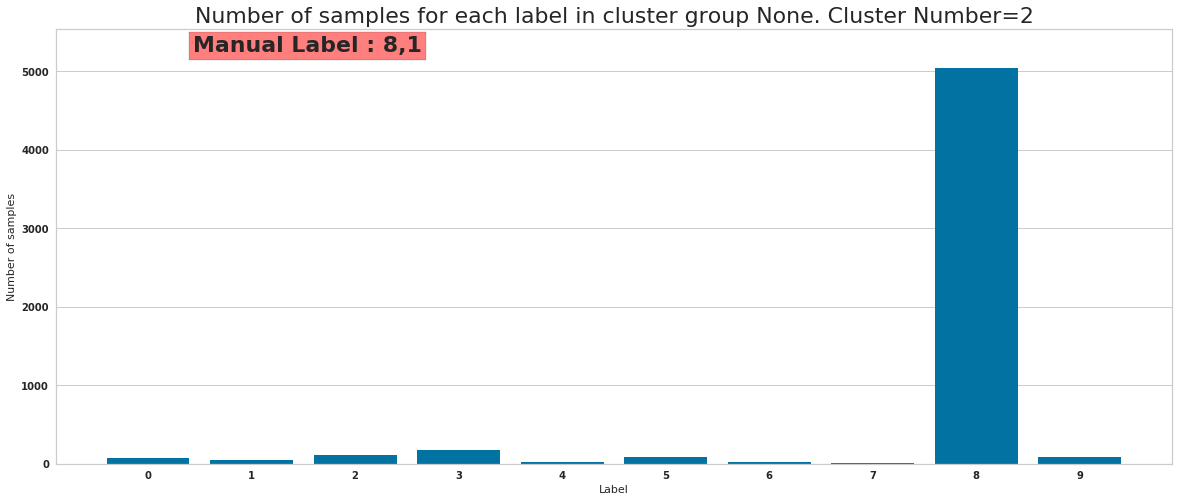

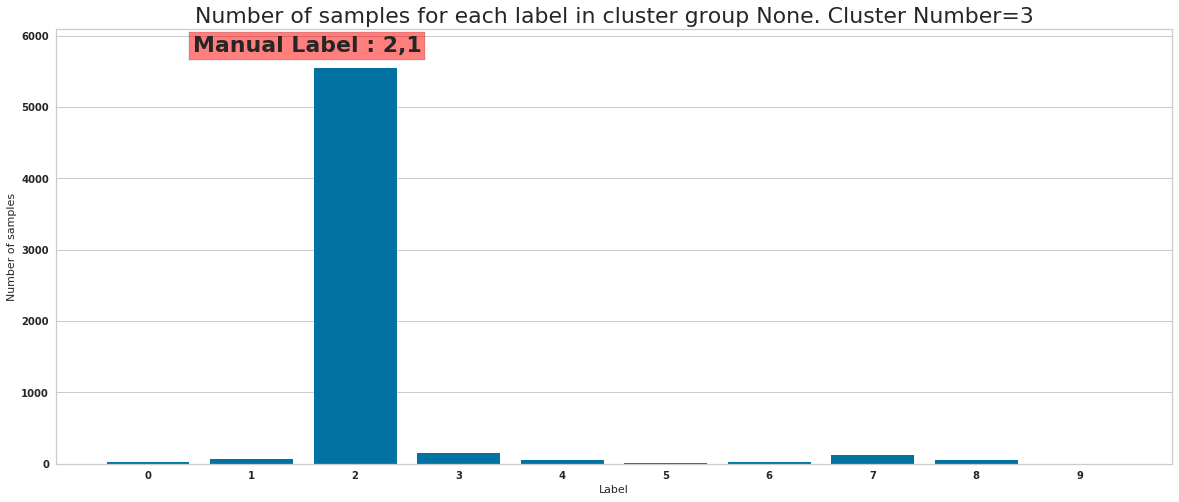

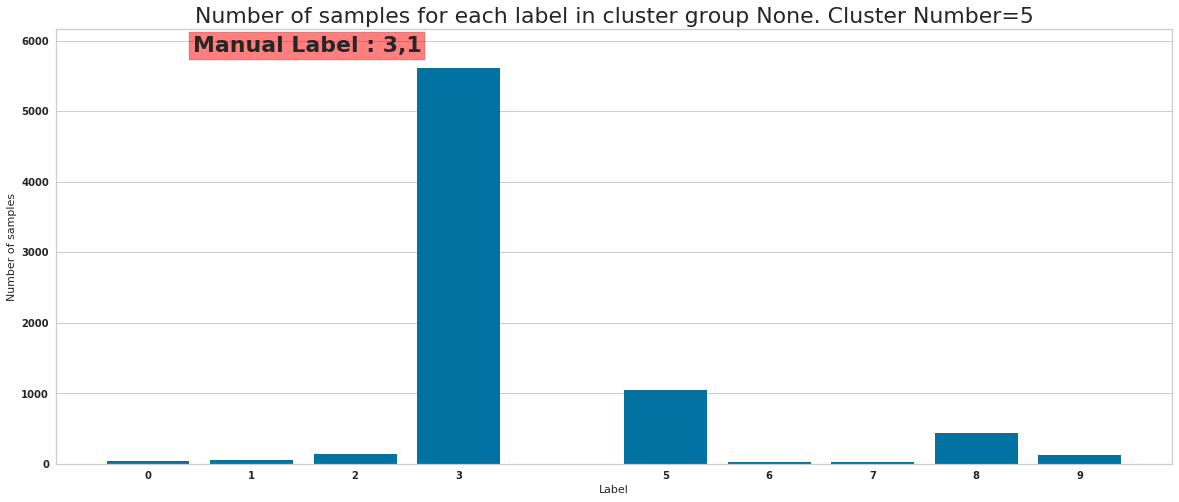

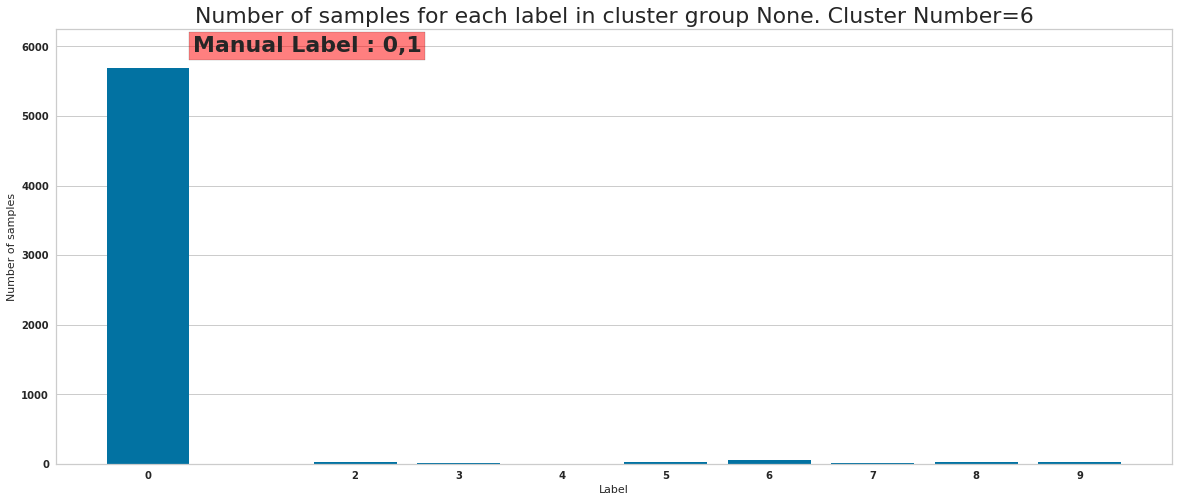

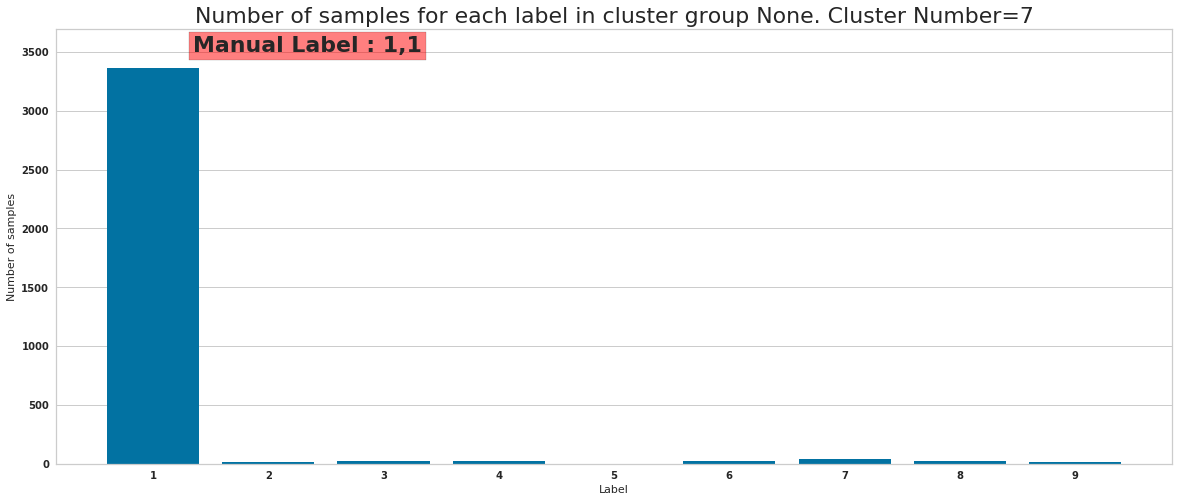

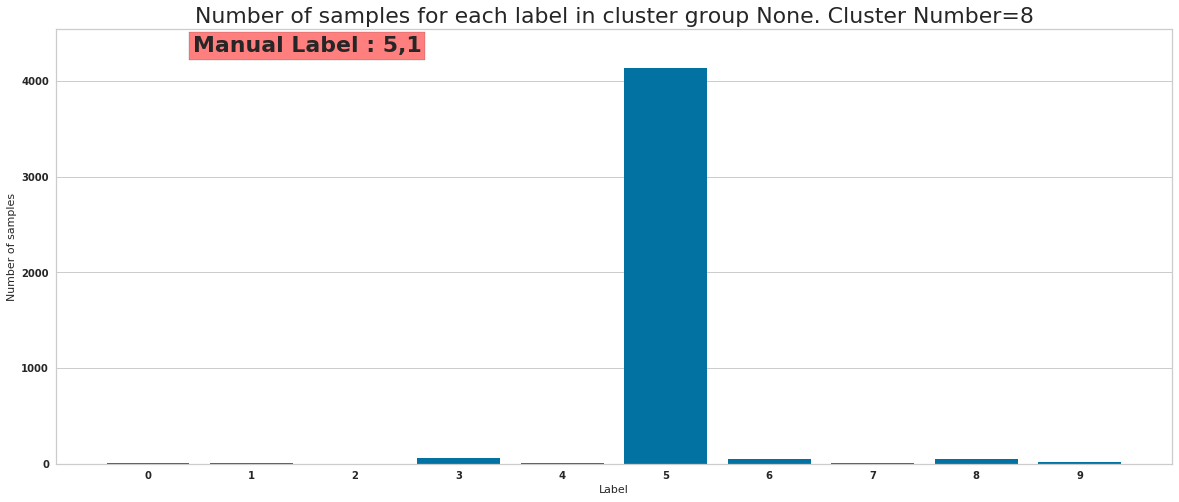

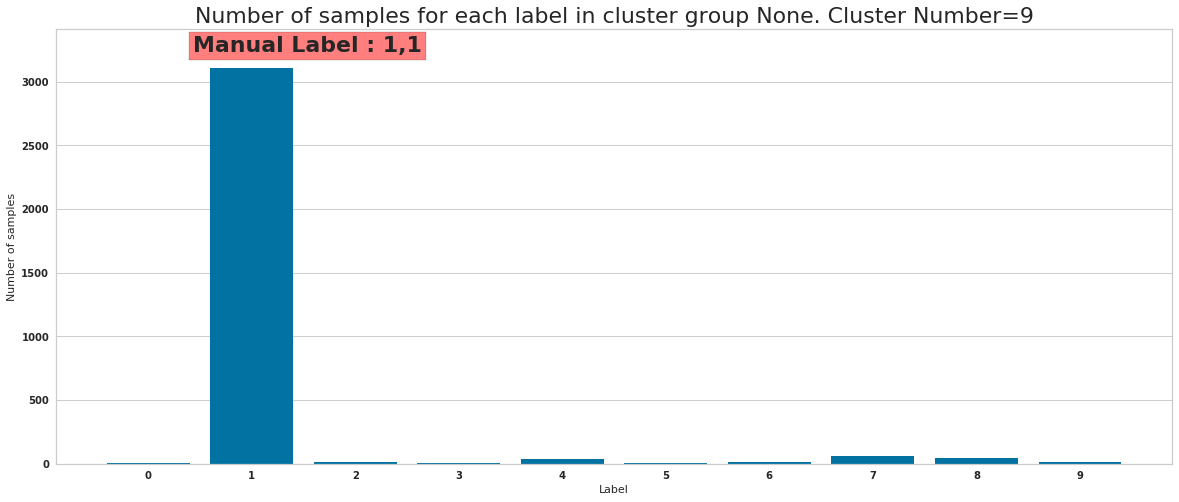

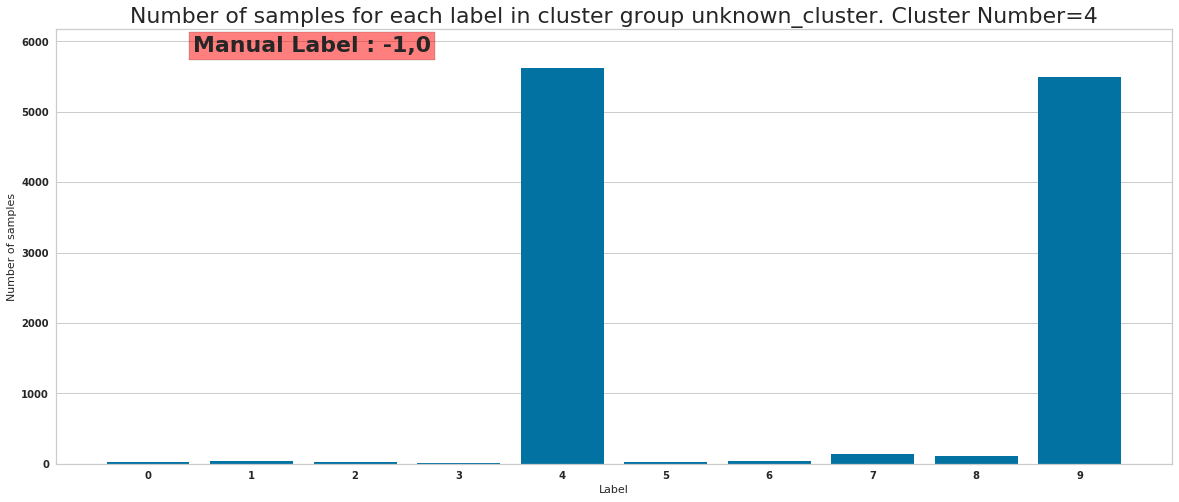

In [130]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 7, 8, 2,
                                           -1, 3, 0, 1,
                                           5, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               0, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



(5914, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6133, 10)
(5671, 10)
(6076, 10)
(11514, 10)
(7490, 10)
(5879, 10)
(3523, 10)
(4333, 10)
(3307, 10)
4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_5/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/s

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


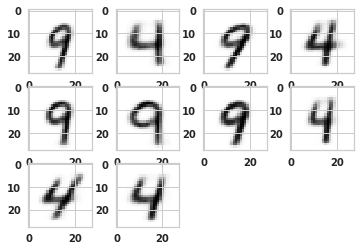

In [131]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [132]:
level2_manual_annotations =dict()

# TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [9, 4, 9, 4,
                                         9, 9, 9, 4,
                                         4, 4,
                                        ]
level_2_cluster_dict["manual_confidences"] = [1,1,1,1,
                                             1,1,1,1,
                                             1,1]
level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [138]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster,cluster_column_name_2)    

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated=assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5924, 47) (5924, 33)
Num correct=5611
Cluster 0 Manual Label 6 Percentage correct 94.71640783254557
********************************
Manual Label 2
(5943, 47) (5943, 33)
Num correct=5354
Cluster 1 Manual Label 2 Percentage correct 90.0891805485445
********************************
Manual Label 8
(5857, 47) (5857, 33)
Num correct=5190
Cluster 2 Manual Label 8 Percentage correct 88.61191736383815
********************************
Manual Label 4
(5675, 47) (5675, 33)
Num correct=5480
Cluster 3 Manual Label 4 Percentage correct 96.56387665198238
********************************
Manual Label 5
(5161, 47) (5161, 33)
Num correct=4896
Cluster 4 Manual Label 5 Percentage correct 94.86533617515985
********************************
Manual Label 0
(6008, 47) (6008, 33)
Num correct=5615
Cluster 5 Manual Label 0 Percentage correct 93.45872170439414
********************************
Manual Label 7
(6401, 47) (6401, 33)
Num correct=5904
Cluster 6 Manual Label 7 Percentage correct 92.235588

In [139]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        

manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)


Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5
manual_label_6


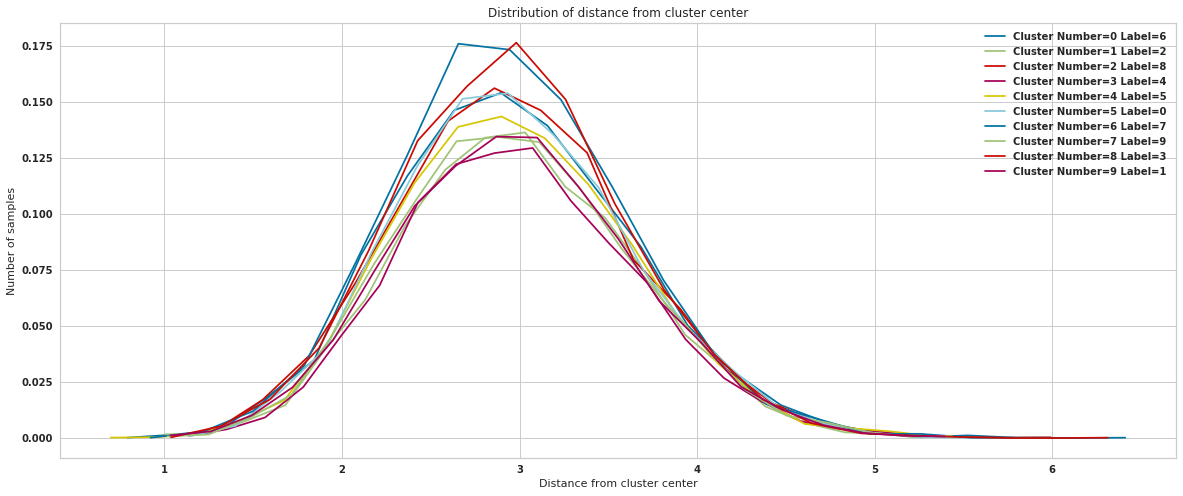

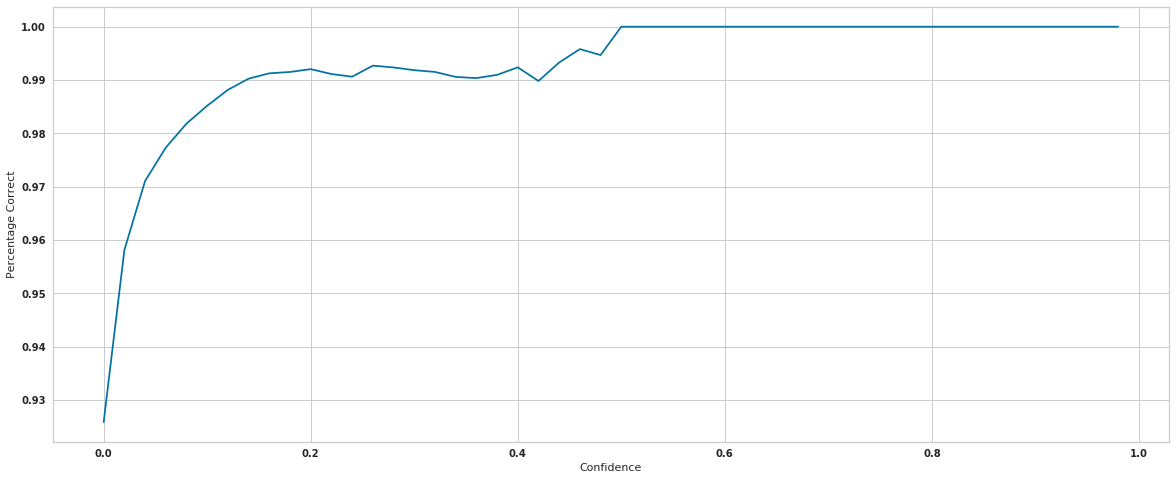

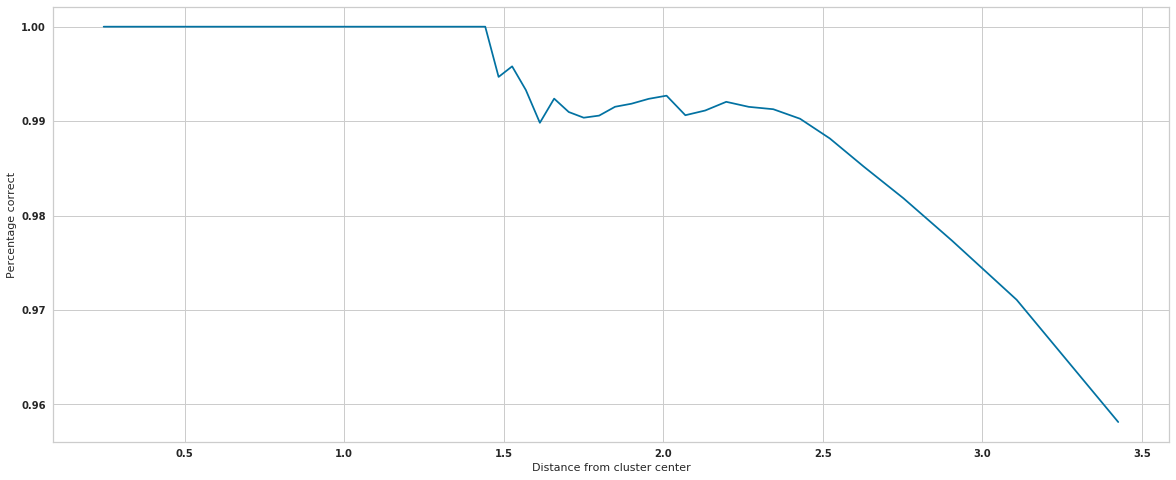

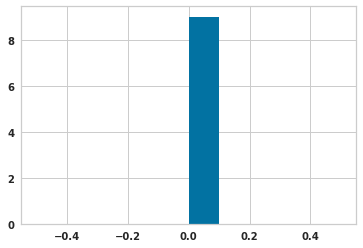

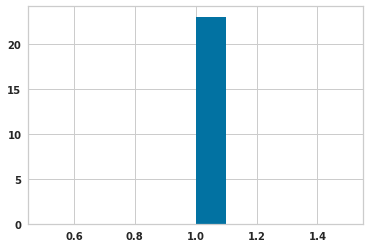

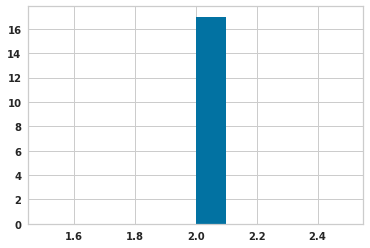

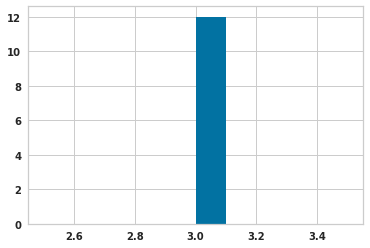

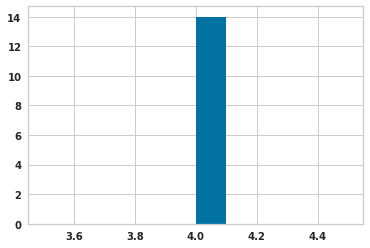

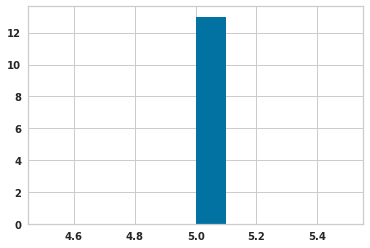

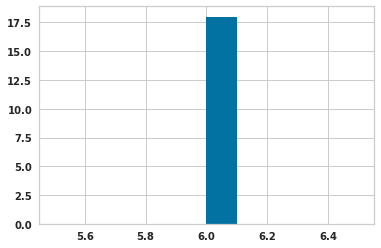

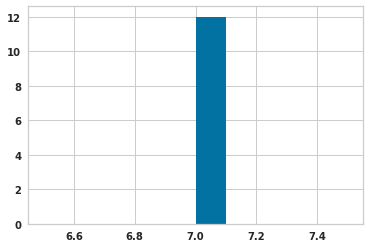

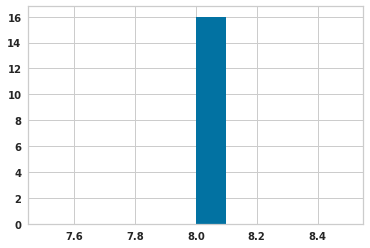

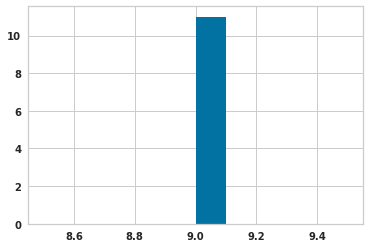

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [141]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)